In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: andrewhealey (roboflow2). Use `wandb login --relogin` to force relogin


True

In [4]:
use_cnn = False
grow_masks = False

mask_lora = True
vit_lora = True

In [5]:
import supervision as sv

from roboflow import login,Roboflow

login()
rf = Roboflow()

%cd datasets/
project = rf.workspace("roboflow-4rfmv").project("climbing-y56wy")
dataset = project.version(5).download("coco-segmentation")

train_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
    force_masks=True
)

valid_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/valid",
    annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
    force_masks=True
)

%cd ..

You are already logged into Roboflow. To make a different login, run roboflow.login(force=True).
/home/andrewhealey/sam-fine-tuning/datasets
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Climbing-5 in coco-segmentation:: 100%|██████████| 51/51 [00:00<00:00, 2951.25it/s]


/home/andrewhealey/sam-fine-tuning


In [6]:
from persam.load import load_predictor

predictor = load_predictor("vit_t")

from fine_tune.samed import LoRA_Mask_Decoder,LoRA_Tiny_Image_Encoder

mask_r = 8
vit_r = 8

if mask_lora:
    lora_mask_decoder = LoRA_Mask_Decoder(predictor.model.mask_decoder,r=mask_r)
    mask_decoder = lora_mask_decoder.mask_decoder.cuda()
else:
    mask_decoder = predictor.model.mask_decoder

if vit_lora:
    lora_image_encoder = LoRA_Tiny_Image_Encoder(predictor.model.image_encoder,r=vit_r)
    image_encoder = lora_image_encoder.image_encoder.cuda()
else:
    image_encoder = predictor.model.image_encoder

build_sam loaded
main segment_anything


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [7]:
from fine_tune.ladder_cnn import CNN_SAM

if use_cnn:
    cnn_sam = CNN_SAM().to("cuda")
else:
    cnn_sam = None

In [8]:
from fine_tune.common import grow_dataset_masks

growth_radius = 15

if grow_masks:
    grow_dataset_masks(train_dataset,growth_radius=growth_radius)
    grow_dataset_masks(valid_dataset,growth_radius=growth_radius)


In [9]:
from fine_tune.common import SamBoxDataset, SamPointDataset, SamNextMaskDataset, RandomPointDataset, SamSemSegDataset, get_max_iou_masks

import torch
device = torch.device('cuda:0')

from torch.utils.data import ConcatDataset

# rand_point_dataset = RandomPointDataset(train_dataset, predictor, device, points_per_img = 40)
point_dataset = SamPointDataset(train_dataset, predictor, device, points_per_mask = 1)
print("point dataset", len(point_dataset))
box_dataset = SamBoxDataset(train_dataset, predictor,device)

sem_seg_dataset = SamSemSegDataset(train_dataset,predictor,device)
print("sem seg dataset", len(sem_seg_dataset))

next_dataset = SamNextMaskDataset(train_dataset,predictor,device)
print("next dataset", len(next_dataset))

combo_dataset = ConcatDataset([point_dataset,next_dataset])


# print("next mask dataset")
# secondary_rand = RandomPointDataset(train_dataset, predictor, device, points_per_img = 40, top_k=None)
# next_rand_point_dataset = SamNextMaskDataset(train_dataset,predictor,device,secondary_prompter=secondary_rand)
# print("next point dataset")
# next_point_dataset = SamNextMaskDataset(train_dataset,predictor,device,secondary_prompter=point_dataset)


# next_combo_dataset = ConcatDataset([
#     next_rand_point_dataset, next_point_dataset,
#     rand_point_dataset, point_dataset,
#     next_dataset
# ])

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:04<00:00,  6.80it/s]


point dataset 2833


100%|██████████| 31/31 [00:00<00:00, 107.01it/s]


sem seg dataset 31


100%|██████████| 31/31 [00:01<00:00, 28.05it/s]

next dataset 0


In [10]:
# valid_point_dataset = SamPointDataset(valid_dataset, predictor, device, points_per_mask=1)
# valid_next_point_dataset = SamNextMaskDataset(valid_dataset, predictor, device, secondary_prompter=valid_point_dataset)

# valid_rand_point_dataset = RandomPointDataset(valid_dataset, predictor, device, points_per_img=100, top_k=None)
# valid_next_rand_point_dataset = SamNextMaskDataset(valid_dataset, predictor, device, secondary_prompter=valid_rand_point_dataset)

In [11]:
valid_point_dataset = SamPointDataset(valid_dataset,predictor,device,points_per_mask=5)
valid_box_dataset = SamBoxDataset(valid_dataset,predictor,device)
valid_sem_seg_dataset = SamSemSegDataset(valid_dataset,predictor,device)
valid_next_dataset = SamNextMaskDataset(valid_dataset,predictor,device)

valid_curr_dataset = ConcatDataset([
    valid_next_dataset,valid_point_dataset,
])

# valid_curr_dataset = ConcatDataset([
#     valid_point_dataset,valid_box_dataset,valid_sem_seg_dataset,valid_next_dataset
# ])

# valid_curr_dataset = ConcatDataset([
#     valid_next_rand_point_dataset,valid_next_point_dataset,
#     valid_point_dataset,valid_rand_point_dataset
# ])

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 35.69it/s]


In [12]:
curr_dataset = sem_seg_dataset#combo_dataset
valid_curr_dataset = valid_sem_seg_dataset
run_grad = True

In [13]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

# Hyperparameters
initial_lr = 2e-4
weight_decay = 0.1

warmup_steps = 25000
total_steps = 150_000
batch_size = 15 # perform gradient accumulation for this--they do 256 images per batch.
log_period = 200 # a few batches
wandb_log_period = 20

lr_decay_steps = [2/3., 0.95]
lr_decay_steps = [int(total_steps * step) for step in lr_decay_steps]

lr_decay_factor = 0.1

combined_params = list(predictor.model.mask_decoder.parameters())
if use_cnn: combined_params += list(cnn_sam.parameters())
optimizer = optim.AdamW(combined_params, lr=initial_lr, betas=(0.9, 0.999), weight_decay=weight_decay) # criterion = torch.nn.CrossEntropyLoss()

# Learning rate warmup schedule
def warmup_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return 1.0

warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)

# Step-wise learning rate decay schedule
def lr_decay_lambda(current_step):
    if current_step in lr_decay_steps:
        return lr_decay_factor
    return 1.0

lr_decay_scheduler = LambdaLR(optimizer, lr_lambda=lr_decay_lambda)

In [14]:
import torch
from torch import nn
import cv2
from torch.nn.functional import threshold, normalize
from numpy.random import permutation
from tqdm import tqdm

from persam.persam_f import calculate_sigmoid_focal_loss, calculate_dice_loss

from torch.nn import functional as F
import json

In [15]:
run = wandb.init(
    project="sam-fine-tune",
    config={
        "learning_rate": initial_lr,
        "iters": total_steps,
        "batch_size": batch_size,
        "lr_decay_steps": json.dumps(lr_decay_steps),
    })

loss_fn = nn.MSELoss()

curr_iters = 0
accumulated_loss = 0

# track running avg of loss
recent_losses = []
recent_mses = []

# iter through dataset in random order
while curr_iters < total_steps:
    for i,idx in enumerate(tqdm(permutation(len(curr_dataset)))):
        curr_iters += 1

        decoder_input, gt_masks, (input_size,original_size), img, resized_img = curr_dataset[idx]
        new_input = {**decoder_input}

        _,H,W = gt_masks.shape

        if use_cnn:
            cnn_embedding = cnn_sam(resized_img)[0]

            curr_embedding = decoder_input["image_embeddings"]

            new_input["image_embeddings"] = curr_embedding + cnn_embedding

        low_res_masks, iou_predictions = mask_decoder(**new_input)

        high_res_masks = F.interpolate(
                low_res_masks,
                (H, W),
                mode="bilinear",
                align_corners=False,
            )
        high_res_masks = high_res_masks.squeeze(0)
        assert len(high_res_masks.shape) == 3,f"Shape is {high_res_masks.shape}" # 1 or 3, H, W

        # upscaled_masks = F.interpolate(low_res_masks, size=img.shape[:2], mode="bilinear", align_corners=False)
        upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).to(device)
        binary_masks = normalize(threshold(upscaled_masks, 0.0, 0)).to(device)[0,:,:,:]

        gt_binary_mask, binary_mask, iou, pred_idx = get_max_iou_masks(gt_masks,binary_masks)
        pred_iou = iou_predictions[0,pred_idx]
        pred_mask = high_res_masks[pred_idx]

        assert gt_binary_mask.shape == binary_mask.shape,f"Mismatched shapes {gt_binary_mask.shape}, {binary_mask.shape}"
        h,w = gt_binary_mask.shape


        flat_pred_mask = pred_mask.view(1,-1)
        flat_gt_binary_mask = gt_binary_mask.view(1,-1)

        focal_loss = calculate_sigmoid_focal_loss(flat_pred_mask, flat_gt_binary_mask)
        dice_loss = calculate_dice_loss(flat_pred_mask, flat_gt_binary_mask)

        # mse loss between predicted and real IoU
        mse_loss = loss_fn(pred_iou, iou)

        loss = 20*focal_loss + dice_loss + mse_loss

        recent_losses += [loss.item()]
        recent_losses = recent_losses[-log_period:]

        if i % wandb_log_period == 0:
            wandb.log({
                "loss": loss.cpu().item(),
                "focal_loss": focal_loss.cpu().item(),
                "dice_loss": dice_loss.cpu().item(),
                "mse_loss": mse_loss.cpu().item(),
            })


        if i % log_period == 0:
            print(f"Loss: {sum(recent_losses)/len(recent_losses)}")

        if not run_grad: continue
        accumulated_loss += loss
        if curr_iters % batch_size == 0:
            optimizer.zero_grad()
            accumulated_loss /= batch_size
            accumulated_loss.backward()
            optimizer.step()
            accumulated_loss = 0
        
        warmup_scheduler.step(curr_iters)

        # Set learning rate for the step-wise decay phase
        lr_decay_scheduler.step(curr_iters)


  0%|          | 0/31 [00:00<?, ?it/s]Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  6%|▋         | 2/31 [00:01<00:19,  1.47it/s]

Loss: 5.084190845489502


  6%|▋         | 2/31 [00:00<00:02, 13.72it/s]

Loss: 4.158617369830608


  6%|▋         | 2/31 [00:00<00:02, 13.47it/s]

Loss: 3.5071178617931547


  6%|▋         | 2/31 [00:00<00:02, 13.93it/s]

Loss: 2.9450862103320183


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 2.598640085697174


  6%|▋         | 2/31 [00:00<00:02, 13.45it/s]

Loss: 2.3933498889972


  6%|▋         | 2/31 [00:00<00:02, 13.87it/s]

Loss: 2.2418250661482784


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 1.8767317762970925


  6%|▋         | 2/31 [00:00<00:02, 12.07it/s]

Loss: 1.580625153183937


  6%|▋         | 2/31 [00:00<00:02, 13.47it/s]

Loss: 1.451775635778904


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 1.3885046023130416


  6%|▋         | 2/31 [00:00<00:02, 13.07it/s]

Loss: 1.341203445494175


  6%|▋         | 2/31 [00:00<00:02, 13.54it/s]

Loss: 1.2732196143269539


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 1.2146332082152367


  3%|▎         | 1/31 [00:00<00:07,  4.17it/s]

Loss: 1.168920520544052


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 1.121903637945652


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 1.0832597744464874


  6%|▋         | 2/31 [00:00<00:02, 13.37it/s]

Loss: 1.050639649927616


  6%|▋         | 2/31 [00:00<00:02, 13.56it/s]

Loss: 1.013878112733364


  6%|▋         | 2/31 [00:00<00:02, 13.54it/s]

Loss: 0.9961180719733238


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.9708155262470245


  6%|▋         | 2/31 [00:00<00:02, 13.90it/s]

Loss: 0.9445331943035126


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.9231090754270553


  6%|▋         | 2/31 [00:00<00:02, 13.63it/s]

Loss: 0.9116563269495964


  6%|▋         | 2/31 [00:00<00:02, 14.03it/s]

Loss: 0.8856385368108749


  6%|▋         | 2/31 [00:00<00:02, 13.95it/s]

Loss: 0.8693389880657196


  6%|▋         | 2/31 [00:00<00:02, 13.78it/s]

Loss: 0.8524386015534401


  6%|▋         | 2/31 [00:00<00:02, 13.30it/s]

Loss: 0.8395908951759339


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.8208697199821472


  3%|▎         | 1/31 [00:00<00:07,  4.08it/s]

Loss: 0.8110534483194352


  6%|▋         | 2/31 [00:00<00:02, 13.41it/s]

Loss: 0.7997554266452789


  6%|▋         | 2/31 [00:00<00:02, 13.51it/s]

Loss: 0.790061217546463


  6%|▋         | 2/31 [00:00<00:02, 13.87it/s]

Loss: 0.7721130622923374


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.7624801282584667


  6%|▋         | 2/31 [00:00<00:02, 13.41it/s]

Loss: 0.7554447734355927


  6%|▋         | 2/31 [00:00<00:02, 13.73it/s]

Loss: 0.7452252635359764


  6%|▋         | 2/31 [00:00<00:02, 13.78it/s]

Loss: 0.7398116518557072


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.7255693759024143


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.7180485063791275


  6%|▋         | 2/31 [00:00<00:02, 13.92it/s]

Loss: 0.7141256828606128


  6%|▋         | 2/31 [00:00<00:02, 13.09it/s]

Loss: 0.7059340664744377


  6%|▋         | 2/31 [00:00<00:02, 13.35it/s]

Loss: 0.6902134607732296


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.6842270117998123


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.6786919781565666


  3%|▎         | 1/31 [00:00<00:07,  4.27it/s]

Loss: 0.6709905011951923


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.6651151889562607


  6%|▋         | 2/31 [00:00<00:02, 13.35it/s]

Loss: 0.6524758580327034


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.6438343136012554


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.640361363440752


  6%|▋         | 2/31 [00:00<00:02, 13.71it/s]

Loss: 0.6312099106609821


  6%|▋         | 2/31 [00:00<00:02, 13.01it/s]

Loss: 0.6221633493900299


  6%|▋         | 2/31 [00:00<00:02, 13.63it/s]

Loss: 0.6144798614084721


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.6096362029016018


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.6090173354744911


  6%|▋         | 2/31 [00:00<00:02, 13.77it/s]

Loss: 0.5984223917126655


  6%|▋         | 2/31 [00:00<00:02, 13.82it/s]

Loss: 0.5921184347569942


  6%|▋         | 2/31 [00:00<00:02, 13.29it/s]

Loss: 0.5838815619051456


  6%|▋         | 2/31 [00:00<00:02, 13.79it/s]

Loss: 0.5826095250248909


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.5733734573423862


  3%|▎         | 1/31 [00:00<00:07,  3.99it/s]

Loss: 0.5687699660658836


  6%|▋         | 2/31 [00:00<00:02, 13.54it/s]

Loss: 0.5619922764599323


  6%|▋         | 2/31 [00:00<00:02, 13.74it/s]

Loss: 0.5629465495049953


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.5529561863839626


  6%|▋         | 2/31 [00:00<00:02, 13.79it/s]

Loss: 0.5493602357804775


  6%|▋         | 2/31 [00:00<00:02, 13.67it/s]

Loss: 0.5475453536212445


  6%|▋         | 2/31 [00:00<00:02, 13.44it/s]

Loss: 0.5416910794377326


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.5400050018727779


  6%|▋         | 2/31 [00:00<00:02, 13.31it/s]

Loss: 0.5342234474420547


  6%|▋         | 2/31 [00:00<00:02, 13.51it/s]

Loss: 0.5308674283325672


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.5240826188027858


  6%|▋         | 2/31 [00:00<00:02, 13.73it/s]

Loss: 0.5252364055812359


  6%|▋         | 2/31 [00:00<00:02, 12.58it/s]

Loss: 0.5193928261101246


  6%|▋         | 2/31 [00:00<00:02, 13.79it/s]

Loss: 0.5142284139990807


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.5123351272940636


  3%|▎         | 1/31 [00:00<00:07,  4.11it/s]

Loss: 0.5053710539638996


  6%|▋         | 2/31 [00:00<00:02, 14.14it/s]

Loss: 0.5016914553940296


  6%|▋         | 2/31 [00:00<00:02, 13.37it/s]

Loss: 0.503490777015686


  6%|▋         | 2/31 [00:00<00:02, 13.77it/s]

Loss: 0.4984430606663227


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.4922224062681198


  6%|▋         | 2/31 [00:00<00:02, 13.44it/s]

Loss: 0.49173526361584663


  6%|▋         | 2/31 [00:00<00:02, 13.37it/s]

Loss: 0.48879571214318274


  6%|▋         | 2/31 [00:00<00:02, 13.81it/s]

Loss: 0.4825601260364056


  6%|▋         | 2/31 [00:00<00:02, 13.47it/s]

Loss: 0.4828468568623066


  6%|▋         | 2/31 [00:00<00:02, 13.81it/s]

Loss: 0.4788040299713612


  6%|▋         | 2/31 [00:00<00:02, 13.64it/s]

Loss: 0.47611056655645373


  6%|▋         | 2/31 [00:00<00:02, 11.92it/s]

Loss: 0.4726764233410358


  6%|▋         | 2/31 [00:00<00:02, 13.71it/s]

Loss: 0.4731093263626099


  6%|▋         | 2/31 [00:00<00:02, 13.46it/s]

Loss: 0.46816651880741117


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.46945681169629094


  3%|▎         | 1/31 [00:00<00:07,  3.90it/s]

Loss: 0.4680855539441109


  6%|▋         | 2/31 [00:00<00:02, 13.98it/s]

Loss: 0.46294036582112313


  6%|▋         | 2/31 [00:00<00:02, 13.63it/s]

Loss: 0.4583431629836559


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.4561918593943119


  6%|▋         | 2/31 [00:00<00:02, 13.31it/s]

Loss: 0.45641851782798765


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.4553662146627903


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.45173771291971204


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.4445871214568615


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.4465149354934692


  6%|▋         | 2/31 [00:00<00:02, 13.35it/s]

Loss: 0.44223139256238936


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.4416070455312729


  6%|▋         | 2/31 [00:00<00:02, 13.92it/s]

Loss: 0.4428101097047329


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.4377985605597496


  6%|▋         | 2/31 [00:00<00:02, 13.36it/s]

Loss: 0.4358513817191124


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.43453276947140695


  3%|▎         | 1/31 [00:00<00:07,  4.23it/s]

Loss: 0.4337502175569534


  6%|▋         | 2/31 [00:00<00:02, 14.03it/s]

Loss: 0.4348446598649025


  6%|▋         | 2/31 [00:00<00:02, 13.92it/s]

Loss: 0.42598139807581903


  6%|▋         | 2/31 [00:00<00:02, 12.70it/s]

Loss: 0.42667622447013853


  6%|▋         | 2/31 [00:00<00:02, 13.36it/s]

Loss: 0.42548749774694444


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.42211695343255995


  6%|▋         | 2/31 [00:00<00:02, 13.98it/s]

Loss: 0.4220960696041584


  6%|▋         | 2/31 [00:00<00:02, 12.95it/s]

Loss: 0.41797653257846834


  6%|▋         | 2/31 [00:00<00:02, 13.70it/s]

Loss: 0.4174715067446232


  6%|▋         | 2/31 [00:00<00:02, 13.67it/s]

Loss: 0.41645725443959236


  6%|▋         | 2/31 [00:00<00:02, 13.70it/s]

Loss: 0.4116728061437607


  6%|▋         | 2/31 [00:00<00:02, 12.98it/s]

Loss: 0.4108081656694412


  6%|▋         | 2/31 [00:00<00:02, 13.35it/s]

Loss: 0.40928976848721504


  6%|▋         | 2/31 [00:00<00:02, 14.02it/s]

Loss: 0.40492618553340437


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.40584681265056133


  3%|▎         | 1/31 [00:00<00:07,  4.14it/s]

Loss: 0.4032013303041458


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.402171251103282


  6%|▋         | 2/31 [00:00<00:02, 13.84it/s]

Loss: 0.40066991426050663


  6%|▋         | 2/31 [00:00<00:02, 13.05it/s]

Loss: 0.40222192198038104


  6%|▋         | 2/31 [00:00<00:02, 13.99it/s]

Loss: 0.3968519525974989


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.39849492721259594


  6%|▋         | 2/31 [00:00<00:02, 13.84it/s]

Loss: 0.39295169956982134


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.39214457929134366


  6%|▋         | 2/31 [00:00<00:02, 13.56it/s]

Loss: 0.3956128323078156


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.3926063470542431


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.38565767131745815


  6%|▋         | 2/31 [00:00<00:02, 11.96it/s]

Loss: 0.3848847720772028


  6%|▋         | 2/31 [00:00<00:02, 13.07it/s]

Loss: 0.3863867151737213


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.3835965042561293


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.381572889983654


  3%|▎         | 1/31 [00:00<00:07,  4.11it/s]

Loss: 0.3793553884327412


  6%|▋         | 2/31 [00:00<00:02, 13.79it/s]

Loss: 0.3791807130724192


  6%|▋         | 2/31 [00:00<00:02, 13.25it/s]

Loss: 0.3792638989537954


  6%|▋         | 2/31 [00:00<00:02, 13.72it/s]

Loss: 0.3752455087006092


  6%|▋         | 2/31 [00:00<00:02, 13.68it/s]

Loss: 0.3751793611049652


  6%|▋         | 2/31 [00:00<00:02, 13.44it/s]

Loss: 0.3728923252224922


  6%|▋         | 2/31 [00:00<00:02, 13.45it/s]

Loss: 0.3687839127331972


  6%|▋         | 2/31 [00:00<00:02, 13.25it/s]

Loss: 0.369297896027565


  6%|▋         | 2/31 [00:00<00:02, 13.47it/s]

Loss: 0.37017372317612174


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 0.3688291843235493


  6%|▋         | 2/31 [00:00<00:02, 13.91it/s]

Loss: 0.3665988460928202


  6%|▋         | 2/31 [00:00<00:02, 13.21it/s]

Loss: 0.36526947274804117


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 0.3616547626256943


  6%|▋         | 2/31 [00:00<00:02, 13.30it/s]

Loss: 0.3608518871665001


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.36100222885608674


  3%|▎         | 1/31 [00:00<00:07,  3.96it/s]

Loss: 0.3603016219288111


  6%|▋         | 2/31 [00:00<00:02, 14.00it/s]

Loss: 0.36001294560730457


  6%|▋         | 2/31 [00:00<00:02, 13.82it/s]

Loss: 0.35367945790290833


  6%|▋         | 2/31 [00:00<00:02, 13.00it/s]

Loss: 0.3573145195841789


  6%|▋         | 2/31 [00:00<00:02, 13.45it/s]

Loss: 0.35765295803546904


  6%|▋         | 2/31 [00:00<00:02, 13.64it/s]

Loss: 0.35464840069413184


  6%|▋         | 2/31 [00:00<00:02, 13.68it/s]

Loss: 0.3521030423790216


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.3506708546727896


  6%|▋         | 2/31 [00:00<00:02, 13.11it/s]

Loss: 0.35191447600722314


  6%|▋         | 2/31 [00:00<00:02, 13.71it/s]

Loss: 0.3505718860030174


  6%|▋         | 2/31 [00:00<00:02, 12.61it/s]

Loss: 0.34868028804659845


  6%|▋         | 2/31 [00:00<00:02, 13.99it/s]

Loss: 0.3464579640328884


  6%|▋         | 2/31 [00:00<00:02, 13.17it/s]

Loss: 0.3462940616905689


  6%|▋         | 2/31 [00:00<00:02, 13.24it/s]

Loss: 0.3451622988283634


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.34509031020104886


  3%|▎         | 1/31 [00:00<00:07,  4.11it/s]

Loss: 0.34218857780098916


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.3425327778607607


  6%|▋         | 2/31 [00:00<00:02, 13.48it/s]

Loss: 0.3416545886546373


  6%|▋         | 2/31 [00:00<00:02, 13.95it/s]

Loss: 0.3381884866952896


  6%|▋         | 2/31 [00:00<00:02, 13.70it/s]

Loss: 0.33870935916900635


  6%|▋         | 2/31 [00:00<00:02, 12.86it/s]

Loss: 0.3389221173524857


  6%|▋         | 2/31 [00:00<00:02, 13.87it/s]

Loss: 0.3349401967227459


  6%|▋         | 2/31 [00:00<00:02, 13.56it/s]

Loss: 0.33459432698786257


  6%|▋         | 2/31 [00:00<00:02, 13.87it/s]

Loss: 0.333884194791317


  6%|▋         | 2/31 [00:00<00:02, 13.79it/s]

Loss: 0.33440179206430914


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.3321469399333


  6%|▋         | 2/31 [00:00<00:02, 13.49it/s]

Loss: 0.33016690507531166


  6%|▋         | 2/31 [00:00<00:02, 13.78it/s]

Loss: 0.3315404949337244


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.3304935401678085


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.3259455892443657


  3%|▎         | 1/31 [00:00<00:07,  4.04it/s]

Loss: 0.3268622337281704


  6%|▋         | 2/31 [00:00<00:02, 13.19it/s]

Loss: 0.3289080885052681


  6%|▋         | 2/31 [00:00<00:02, 13.30it/s]

Loss: 0.3253143298625946


  6%|▋         | 2/31 [00:00<00:02, 13.30it/s]

Loss: 0.3237267705053091


  6%|▋         | 2/31 [00:00<00:02, 13.65it/s]

Loss: 0.3219034118205309


  6%|▋         | 2/31 [00:00<00:02, 13.04it/s]

Loss: 0.3237181658297777


  6%|▋         | 2/31 [00:00<00:02, 13.66it/s]

Loss: 0.31972933262586595


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.3174041935801506


  6%|▋         | 2/31 [00:00<00:02, 13.64it/s]

Loss: 0.3197655560076237


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.31946279913187026


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.3170822361856699


  6%|▋         | 2/31 [00:00<00:02, 13.27it/s]

Loss: 0.31593448773026467


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.31716337978839876


  6%|▋         | 2/31 [00:00<00:02, 13.51it/s]

Loss: 0.3145615853369236


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.3133379317820072


  3%|▎         | 1/31 [00:00<00:07,  4.24it/s]

Loss: 0.31482158780097963


  6%|▋         | 2/31 [00:00<00:02, 13.82it/s]

Loss: 0.3110169951617718


  6%|▋         | 2/31 [00:00<00:02, 13.65it/s]

Loss: 0.3130986231565476


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.31331869050860406


  6%|▋         | 2/31 [00:00<00:02, 12.49it/s]

Loss: 0.30757754512131213


  6%|▋         | 2/31 [00:00<00:02, 13.58it/s]

Loss: 0.3128010081499815


  6%|▋         | 2/31 [00:00<00:02, 12.96it/s]

Loss: 0.30658301189541814


  6%|▋         | 2/31 [00:00<00:02, 13.90it/s]

Loss: 0.307905455455184


  6%|▋         | 2/31 [00:00<00:02, 13.79it/s]

Loss: 0.30837742034345866


  6%|▋         | 2/31 [00:00<00:02, 13.16it/s]

Loss: 0.3090613967180252


  6%|▋         | 2/31 [00:00<00:02, 13.44it/s]

Loss: 0.3057542762905359


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.30314249005168675


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.30438519023358823


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.3026642643287778


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.30230720721185206


  3%|▎         | 1/31 [00:00<00:07,  3.95it/s]

Loss: 0.2986379552260041


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.30053670149296524


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.30151246417313815


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.30080480940639975


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.3002303643152118


  6%|▋         | 2/31 [00:00<00:02, 13.59it/s]

Loss: 0.29785470325499774


  6%|▋         | 2/31 [00:00<00:02, 13.22it/s]

Loss: 0.2960245517268777


  6%|▋         | 2/31 [00:00<00:02, 13.35it/s]

Loss: 0.2974756325408816


  6%|▋         | 2/31 [00:00<00:02, 13.30it/s]

Loss: 0.29688705429434775


  6%|▋         | 2/31 [00:00<00:02, 12.78it/s]

Loss: 0.2938184413686395


  6%|▋         | 2/31 [00:00<00:02, 14.05it/s]

Loss: 0.29058281797915697


  6%|▋         | 2/31 [00:00<00:02, 14.03it/s]

Loss: 0.29239276990294455


  6%|▋         | 2/31 [00:00<00:02, 13.12it/s]

Loss: 0.29014272693544624


  6%|▋         | 2/31 [00:00<00:02, 13.79it/s]

Loss: 0.2931969741359353


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.2911296585947275


  3%|▎         | 1/31 [00:00<00:07,  4.11it/s]

Loss: 0.2919335863739252


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.2876388342678547


  6%|▋         | 2/31 [00:00<00:02, 13.37it/s]

Loss: 0.29052226126194003


  6%|▋         | 2/31 [00:00<00:02, 13.74it/s]

Loss: 0.2869171801581979


  6%|▋         | 2/31 [00:00<00:02, 13.31it/s]

Loss: 0.28842290103435514


  6%|▋         | 2/31 [00:00<00:02, 13.90it/s]

Loss: 0.2872492917999625


  6%|▋         | 2/31 [00:00<00:02, 13.79it/s]

Loss: 0.2876185603439808


  6%|▋         | 2/31 [00:00<00:02, 13.69it/s]

Loss: 0.2851358249410987


  6%|▋         | 2/31 [00:00<00:02, 13.25it/s]

Loss: 0.2847188964858651


  6%|▋         | 2/31 [00:00<00:02, 13.77it/s]

Loss: 0.2866058363765478


  6%|▋         | 2/31 [00:00<00:02, 13.64it/s]

Loss: 0.2837040340155363


  6%|▋         | 2/31 [00:00<00:02, 13.00it/s]

Loss: 0.28240523297339676


  6%|▋         | 2/31 [00:00<00:02, 12.90it/s]

Loss: 0.2825964203849435


  6%|▋         | 2/31 [00:00<00:02, 13.84it/s]

Loss: 0.27986181784421205


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.27948546286672354


  3%|▎         | 1/31 [00:00<00:08,  3.67it/s]

Loss: 0.28409141711890695


  6%|▋         | 2/31 [00:00<00:02, 13.64it/s]

Loss: 0.280686050504446


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.2795582370832562


  6%|▋         | 2/31 [00:00<00:02, 13.13it/s]

Loss: 0.28068706173449753


  6%|▋         | 2/31 [00:00<00:02, 13.93it/s]

Loss: 0.2740727611258626


  6%|▋         | 2/31 [00:00<00:02, 12.91it/s]

Loss: 0.2757158585637808


  6%|▋         | 2/31 [00:00<00:02, 13.04it/s]

Loss: 0.2749105631932616


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.2752215300872922


  6%|▋         | 2/31 [00:00<00:02, 13.20it/s]

Loss: 0.2754232256487012


  6%|▋         | 2/31 [00:00<00:02, 13.45it/s]

Loss: 0.2733973588049412


  6%|▋         | 2/31 [00:00<00:02, 13.98it/s]

Loss: 0.27596271976828574


  6%|▋         | 2/31 [00:00<00:02, 14.04it/s]

Loss: 0.27238494012504816


  6%|▋         | 2/31 [00:00<00:02, 13.21it/s]

Loss: 0.27310593850910664


  6%|▋         | 2/31 [00:00<00:02, 13.80it/s]

Loss: 0.2761051765829325


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.2725030106306076


  3%|▎         | 1/31 [00:00<00:07,  4.20it/s]

Loss: 0.27240541726350787


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.27380229517817495


  6%|▋         | 2/31 [00:00<00:02, 13.65it/s]

Loss: 0.26992417566478255


  6%|▋         | 2/31 [00:00<00:02, 12.97it/s]

Loss: 0.2701372515782714


  6%|▋         | 2/31 [00:00<00:02, 13.87it/s]

Loss: 0.2696283983439207


  6%|▋         | 2/31 [00:00<00:02, 13.48it/s]

Loss: 0.2693881236761808


  6%|▋         | 2/31 [00:00<00:02, 13.68it/s]

Loss: 0.26653867471963166


  6%|▋         | 2/31 [00:00<00:02, 13.68it/s]

Loss: 0.26517612367868426


  6%|▋         | 2/31 [00:00<00:02, 13.78it/s]

Loss: 0.26628100253641607


  6%|▋         | 2/31 [00:00<00:02, 14.00it/s]

Loss: 0.2671367501094937


  6%|▋         | 2/31 [00:00<00:02, 13.90it/s]

Loss: 0.26761633388698103


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.26420398335903883


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.26540989335626364


  6%|▋         | 2/31 [00:00<00:02, 13.01it/s]

Loss: 0.26653812136501076


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.2620886508002877


  3%|▎         | 1/31 [00:00<00:07,  4.09it/s]

Loss: 0.26595933727920057


  6%|▋         | 2/31 [00:00<00:02, 13.95it/s]

Loss: 0.26131782464683057


  6%|▋         | 2/31 [00:00<00:02, 13.39it/s]

Loss: 0.2644094561412931


  6%|▋         | 2/31 [00:00<00:02, 13.80it/s]

Loss: 0.26153871465474365


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.2624091752246022


  6%|▋         | 2/31 [00:00<00:02, 12.61it/s]

Loss: 0.260500379242003


  6%|▋         | 2/31 [00:00<00:02, 12.91it/s]

Loss: 0.2610872822627425


  6%|▋         | 2/31 [00:00<00:02, 12.51it/s]

Loss: 0.25976712808012964


  6%|▋         | 2/31 [00:00<00:02, 14.14it/s]

Loss: 0.25754847083240745


  6%|▋         | 2/31 [00:00<00:02, 12.20it/s]

Loss: 0.25695373192429544


  6%|▋         | 2/31 [00:00<00:02, 12.98it/s]

Loss: 0.25578891325742004


  6%|▋         | 2/31 [00:00<00:02, 12.97it/s]

Loss: 0.25790532972663643


  6%|▋         | 2/31 [00:00<00:02, 13.82it/s]

Loss: 0.25687960535287857


  6%|▋         | 2/31 [00:00<00:02, 13.24it/s]

Loss: 0.2585468562319875


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.25861746951937675


  3%|▎         | 1/31 [00:00<00:07,  4.00it/s]

Loss: 0.2585951150208712


  6%|▋         | 2/31 [00:00<00:02, 13.77it/s]

Loss: 0.2559006505832076


  6%|▋         | 2/31 [00:00<00:02, 12.79it/s]

Loss: 0.25616878014057876


  6%|▋         | 2/31 [00:00<00:02, 13.84it/s]

Loss: 0.25244921654462815


  6%|▋         | 2/31 [00:00<00:02, 13.02it/s]

Loss: 0.2562621229887009


  6%|▋         | 2/31 [00:00<00:02, 11.99it/s]

Loss: 0.2514497636631131


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.25269747208803894


  6%|▋         | 2/31 [00:00<00:02, 13.37it/s]

Loss: 0.2515512911975384


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.2511829861998558


  6%|▋         | 2/31 [00:00<00:02, 13.67it/s]

Loss: 0.25115720484405757


  6%|▋         | 2/31 [00:00<00:02, 13.48it/s]

Loss: 0.2515820147097111


  6%|▋         | 2/31 [00:00<00:02, 13.82it/s]

Loss: 0.24766976989805697


  6%|▋         | 2/31 [00:00<00:02, 13.62it/s]

Loss: 0.25082066193223


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.25013307873159646


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.249523506462574


  3%|▎         | 1/31 [00:00<00:07,  4.03it/s]

Loss: 0.24952929891645909


  6%|▋         | 2/31 [00:00<00:02, 13.91it/s]

Loss: 0.2515917546674609


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.24777689132839442


  6%|▋         | 2/31 [00:00<00:02, 13.13it/s]

Loss: 0.2498990361019969


  6%|▋         | 2/31 [00:00<00:02, 13.80it/s]

Loss: 0.25106332905590534


  6%|▋         | 2/31 [00:00<00:02, 13.91it/s]

Loss: 0.2466922277212143


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 0.24930164437741043


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.24576521974056958


  6%|▋         | 2/31 [00:00<00:02, 13.93it/s]

Loss: 0.24722785759717225


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.24588398601859807


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.24423384334892034


  6%|▋         | 2/31 [00:00<00:02, 13.16it/s]

Loss: 0.24698537353426217


  6%|▋         | 2/31 [00:00<00:02, 13.84it/s]

Loss: 0.24571110785007477


  6%|▋         | 2/31 [00:00<00:02, 12.55it/s]

Loss: 0.24353923570364713


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.2416491762176156


  3%|▎         | 1/31 [00:00<00:07,  4.07it/s]

Loss: 0.2418566957116127


  6%|▋         | 2/31 [00:00<00:02, 13.96it/s]

Loss: 0.241942672803998


  6%|▋         | 2/31 [00:00<00:02, 13.03it/s]

Loss: 0.2410172776505351


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.2384399474784732


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.2390881387516856


  6%|▋         | 2/31 [00:00<00:02, 13.48it/s]

Loss: 0.24134003084152936


  6%|▋         | 2/31 [00:00<00:02, 13.59it/s]

Loss: 0.2394997275620699


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.23893481239676476


  6%|▋         | 2/31 [00:00<00:02, 13.20it/s]

Loss: 0.23989753812551498


  6%|▋         | 2/31 [00:00<00:02, 13.78it/s]

Loss: 0.2385413190536201


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.24111653879284858


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.2385262011922896


  6%|▋         | 2/31 [00:00<00:02, 13.70it/s]

Loss: 0.23749631045386196


  6%|▋         | 2/31 [00:00<00:02, 13.39it/s]

Loss: 0.23744559621438385


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.23717226872220634


  3%|▎         | 1/31 [00:00<00:07,  3.99it/s]

Loss: 0.23602861238643527


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 0.23991908457130193


  6%|▋         | 2/31 [00:00<00:02, 12.50it/s]

Loss: 0.2352652114443481


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.23587491143494843


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.2366491637378931


  6%|▋         | 2/31 [00:00<00:02, 13.27it/s]

Loss: 0.2355118205025792


  6%|▋         | 2/31 [00:00<00:02, 12.68it/s]

Loss: 0.23311300348490477


  6%|▋         | 2/31 [00:00<00:02, 13.65it/s]

Loss: 0.23403092835098505


  6%|▋         | 2/31 [00:00<00:02, 12.80it/s]

Loss: 0.23399260334670544


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.23032649576663972


  6%|▋         | 2/31 [00:00<00:02, 12.70it/s]

Loss: 0.2341892234608531


  6%|▋         | 2/31 [00:00<00:02, 13.99it/s]

Loss: 0.23292392702773212


  6%|▋         | 2/31 [00:00<00:02, 13.04it/s]

Loss: 0.23270323503762483


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.23107851637527346


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.2333121912367642


  3%|▎         | 1/31 [00:00<00:07,  4.15it/s]

Loss: 0.23236704533919691


  6%|▋         | 2/31 [00:00<00:02, 14.11it/s]

Loss: 0.2335294160619378


  6%|▋         | 2/31 [00:00<00:02, 13.77it/s]

Loss: 0.22942641675472258


  6%|▋         | 2/31 [00:00<00:02, 13.92it/s]

Loss: 0.23204934604465963


  6%|▋         | 2/31 [00:00<00:02, 13.69it/s]

Loss: 0.22951468316838144


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.23051053440198302


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.22836220636963844


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.22987519428133965


  6%|▋         | 2/31 [00:00<00:02, 13.05it/s]

Loss: 0.22532553127035498


  6%|▋         | 2/31 [00:00<00:02, 13.74it/s]

Loss: 0.22716860715299844


  6%|▋         | 2/31 [00:00<00:02, 13.44it/s]

Loss: 0.22986362665891646


  6%|▋         | 2/31 [00:00<00:02, 14.02it/s]

Loss: 0.2281583407521248


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.2269492986984551


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.22696058487519621


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.22581872422248125


  3%|▎         | 1/31 [00:00<00:07,  4.12it/s]

Loss: 0.22957266414538025


  6%|▋         | 2/31 [00:00<00:02, 14.00it/s]

Loss: 0.22566038705408573


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.22529856599867343


  6%|▋         | 2/31 [00:00<00:02, 14.00it/s]

Loss: 0.22903024666011335


  6%|▋         | 2/31 [00:00<00:02, 13.41it/s]

Loss: 0.22284584311768413


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.22418551919981838


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 0.22439786134287715


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 0.22653626726940274


  6%|▋         | 2/31 [00:00<00:02, 13.75it/s]

Loss: 0.22395565561950206


  6%|▋         | 2/31 [00:00<00:02, 13.99it/s]

Loss: 0.2230037786066532


  6%|▋         | 2/31 [00:00<00:02, 13.98it/s]

Loss: 0.2236452630162239


  6%|▋         | 2/31 [00:00<00:02, 13.26it/s]

Loss: 0.22373430646955966


  6%|▋         | 2/31 [00:00<00:02, 13.06it/s]

Loss: 0.22482840703800322


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.22145513407886028


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.22336478212848307


  3%|▎         | 1/31 [00:00<00:07,  4.23it/s]

Loss: 0.22125776428729296


  6%|▋         | 2/31 [00:00<00:02, 14.02it/s]

Loss: 0.22266054652631284


  6%|▋         | 2/31 [00:00<00:02, 13.84it/s]

Loss: 0.21875906633213163


  6%|▋         | 2/31 [00:00<00:02, 13.55it/s]

Loss: 0.22219268884509802


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.22052386766299606


  6%|▋         | 2/31 [00:00<00:02, 13.84it/s]

Loss: 0.22011115062981845


  6%|▋         | 2/31 [00:00<00:02, 13.46it/s]

Loss: 0.2230632644146681


  6%|▋         | 2/31 [00:00<00:02, 13.37it/s]

Loss: 0.21912335390225052


  6%|▋         | 2/31 [00:00<00:02, 13.80it/s]

Loss: 0.2207820402085781


  6%|▋         | 2/31 [00:00<00:02, 13.19it/s]

Loss: 0.21772698616608976


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.2186661507561803


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.21915651636198163


  6%|▋         | 2/31 [00:00<00:02, 14.05it/s]

Loss: 0.2165291129052639


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.21795441320165992


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.21778638763353228


  3%|▎         | 1/31 [00:00<00:07,  4.13it/s]

Loss: 0.21812334440648556


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.2152507222443819


  6%|▋         | 2/31 [00:00<00:02, 13.35it/s]

Loss: 0.21819310208782552


  6%|▋         | 2/31 [00:00<00:02, 13.55it/s]

Loss: 0.2155401123315096


  6%|▋         | 2/31 [00:00<00:02, 14.01it/s]

Loss: 0.21834764769300818


  6%|▋         | 2/31 [00:00<00:02, 12.96it/s]

Loss: 0.21688477110117674


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.21500431770458817


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.21557705204933883


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.21523291869089006


  6%|▋         | 2/31 [00:00<00:02, 13.90it/s]

Loss: 0.21672184640541672


  6%|▋         | 2/31 [00:00<00:02, 13.47it/s]

Loss: 0.21207029914483427


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.21553736951202154


  6%|▋         | 2/31 [00:00<00:02, 13.91it/s]

Loss: 0.21470097377896308


  6%|▋         | 2/31 [00:00<00:02, 13.75it/s]

Loss: 0.21425155827775597


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.21433211958035828


  3%|▎         | 1/31 [00:00<00:08,  3.64it/s]

Loss: 0.21382365768775344


  6%|▋         | 2/31 [00:00<00:02, 14.11it/s]

Loss: 0.20982547177001834


  6%|▋         | 2/31 [00:00<00:02, 13.13it/s]

Loss: 0.21696673445403575


  6%|▋         | 2/31 [00:00<00:02, 13.41it/s]

Loss: 0.21285746838897468


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.21171706641092897


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.2111690162681043


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.21370846008881927


  6%|▋         | 2/31 [00:00<00:02, 12.97it/s]

Loss: 0.21395209090784192


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.21226162081584335


  6%|▋         | 2/31 [00:00<00:02, 14.00it/s]

Loss: 0.21039341814815998


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.20781512789428233


  6%|▋         | 2/31 [00:00<00:02, 13.19it/s]

Loss: 0.21011886401101948


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.20845762161538006


  6%|▋         | 2/31 [00:00<00:02, 13.44it/s]

Loss: 0.21151489812880755


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.21212720407173039


  3%|▎         | 1/31 [00:00<00:07,  4.13it/s]

Loss: 0.20906807821244


  6%|▋         | 2/31 [00:00<00:02, 13.90it/s]

Loss: 0.2074372849613428


  6%|▋         | 2/31 [00:00<00:02, 13.25it/s]

Loss: 0.2103525995835662


  6%|▋         | 2/31 [00:00<00:02, 13.80it/s]

Loss: 0.20745086880400776


  6%|▋         | 2/31 [00:00<00:02, 13.62it/s]

Loss: 0.2106889080442488


  6%|▋         | 2/31 [00:00<00:02, 13.13it/s]

Loss: 0.20786903323605657


  6%|▋         | 2/31 [00:00<00:02, 13.46it/s]

Loss: 0.20796280201524497


  6%|▋         | 2/31 [00:00<00:02, 13.13it/s]

Loss: 0.2072665362805128


  6%|▋         | 2/31 [00:00<00:02, 13.62it/s]

Loss: 0.20907839227467775


  6%|▋         | 2/31 [00:00<00:02, 13.22it/s]

Loss: 0.20652172412723302


  6%|▋         | 2/31 [00:00<00:02, 14.12it/s]

Loss: 0.2096401834115386


  6%|▋         | 2/31 [00:00<00:02, 13.73it/s]

Loss: 0.2073235129006207


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.2052716292254627


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.2061698860861361


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.20591442791745065


  3%|▎         | 1/31 [00:00<00:07,  4.28it/s]

Loss: 0.20510957103222607


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.206351126935333


  6%|▋         | 2/31 [00:00<00:02, 13.25it/s]

Loss: 0.2042966939881444


  6%|▋         | 2/31 [00:00<00:02, 12.74it/s]

Loss: 0.20581847552210092


  6%|▋         | 2/31 [00:00<00:02, 13.15it/s]

Loss: 0.20461494311690331


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.20689828479662536


  6%|▋         | 2/31 [00:00<00:02, 13.81it/s]

Loss: 0.2041360591724515


  6%|▋         | 2/31 [00:00<00:02, 12.97it/s]

Loss: 0.20444647451862694


  6%|▋         | 2/31 [00:00<00:02, 13.11it/s]

Loss: 0.20600672943517565


  6%|▋         | 2/31 [00:00<00:02, 13.29it/s]

Loss: 0.2042925280891359


  6%|▋         | 2/31 [00:00<00:02, 13.82it/s]

Loss: 0.20226249642670155


  6%|▋         | 2/31 [00:00<00:02, 13.24it/s]

Loss: 0.20198568351566792


  6%|▋         | 2/31 [00:00<00:02, 13.66it/s]

Loss: 0.20439649280160666


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.20465004036203027


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.20413946798071264


  3%|▎         | 1/31 [00:00<00:07,  4.15it/s]

Loss: 0.20208689039573074


  6%|▋         | 2/31 [00:00<00:02, 14.09it/s]

Loss: 0.19963103940710425


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.2022830279543996


  6%|▋         | 2/31 [00:00<00:02, 13.27it/s]

Loss: 0.20050535852089524


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.20342170825228095


  6%|▋         | 2/31 [00:00<00:02, 12.76it/s]

Loss: 0.19922036619856953


  6%|▋         | 2/31 [00:00<00:02, 13.54it/s]

Loss: 0.20312289234250783


  6%|▋         | 2/31 [00:00<00:02, 13.90it/s]

Loss: 0.19960930079221725


  6%|▋         | 2/31 [00:00<00:02, 13.52it/s]

Loss: 0.20123816724866628


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.20102057697251438


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.20074340630322696


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.20018053086474538


  6%|▋         | 2/31 [00:00<00:02, 14.04it/s]

Loss: 0.20129055010154842


  6%|▋         | 2/31 [00:00<00:02, 13.95it/s]

Loss: 0.1997192813642323


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.20324312353506685


  3%|▎         | 1/31 [00:00<00:07,  4.18it/s]

Loss: 0.19866473210975527


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.20089314747601747


  6%|▋         | 2/31 [00:00<00:02, 13.37it/s]

Loss: 0.19984807642176747


  6%|▋         | 2/31 [00:00<00:02, 13.74it/s]

Loss: 0.19576960591599346


  6%|▋         | 2/31 [00:00<00:02, 13.91it/s]

Loss: 0.19959186689928174


  6%|▋         | 2/31 [00:00<00:02, 13.74it/s]

Loss: 0.19860512610524894


  6%|▋         | 2/31 [00:00<00:02, 13.91it/s]

Loss: 0.19818238724023104


  6%|▋         | 2/31 [00:00<00:02, 13.92it/s]

Loss: 0.19901827346533538


  6%|▋         | 2/31 [00:00<00:02, 13.84it/s]

Loss: 0.19890298686921595


  6%|▋         | 2/31 [00:00<00:02, 13.68it/s]

Loss: 0.20023188102990389


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.197221496142447


  6%|▋         | 2/31 [00:00<00:02, 13.48it/s]

Loss: 0.19688707696273922


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.1958792361803353


  6%|▋         | 2/31 [00:00<00:02, 13.70it/s]

Loss: 0.19635122925043105


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.19707719070836902


  3%|▎         | 1/31 [00:00<00:07,  4.18it/s]

Loss: 0.19667484181001782


  6%|▋         | 2/31 [00:00<00:02, 14.25it/s]

Loss: 0.19625587828457355


  6%|▋         | 2/31 [00:00<00:02, 13.82it/s]

Loss: 0.1973817532323301


  6%|▋         | 2/31 [00:00<00:02, 13.51it/s]

Loss: 0.194457801412791


  6%|▋         | 2/31 [00:00<00:02, 13.68it/s]

Loss: 0.19372057905420662


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.19528225669637322


  6%|▋         | 2/31 [00:00<00:02, 13.66it/s]

Loss: 0.19418886357918383


  6%|▋         | 2/31 [00:00<00:02, 13.01it/s]

Loss: 0.19602403979748487


  6%|▋         | 2/31 [00:00<00:02, 13.93it/s]

Loss: 0.19786608776077627


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.1934748386591673


  6%|▋         | 2/31 [00:00<00:02, 13.87it/s]

Loss: 0.19403854545205831


  6%|▋         | 2/31 [00:00<00:02, 13.74it/s]

Loss: 0.19249362371861933


  6%|▋         | 2/31 [00:00<00:02, 13.73it/s]

Loss: 0.19592411966994405


  6%|▋         | 2/31 [00:00<00:02, 13.75it/s]

Loss: 0.19579722644761205


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.19167911794036627


  3%|▎         | 1/31 [00:00<00:08,  3.74it/s]

Loss: 0.19361824255436658


  6%|▋         | 2/31 [00:00<00:02, 13.08it/s]

Loss: 0.19246591448783876


  6%|▋         | 2/31 [00:00<00:02, 13.68it/s]

Loss: 0.19486094800755382


  6%|▋         | 2/31 [00:00<00:02, 13.98it/s]

Loss: 0.195052708145231


  6%|▋         | 2/31 [00:00<00:02, 13.67it/s]

Loss: 0.19290159918367863


  6%|▋         | 2/31 [00:00<00:02, 13.20it/s]

Loss: 0.19220831243321299


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.18970808543264867


  6%|▋         | 2/31 [00:00<00:02, 13.04it/s]

Loss: 0.1905514351464808


  6%|▋         | 2/31 [00:00<00:02, 13.90it/s]

Loss: 0.19208449756726623


  6%|▋         | 2/31 [00:00<00:02, 13.75it/s]

Loss: 0.19102346761152147


  6%|▋         | 2/31 [00:00<00:02, 13.57it/s]

Loss: 0.1896633761934936


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.1901024396903813


  6%|▋         | 2/31 [00:00<00:02, 13.79it/s]

Loss: 0.19185106966644525


  6%|▋         | 2/31 [00:00<00:02, 13.99it/s]

Loss: 0.19068891314789652


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.19239275155588983


  3%|▎         | 1/31 [00:00<00:07,  4.12it/s]

Loss: 0.19379293486475946


  6%|▋         | 2/31 [00:00<00:02, 13.84it/s]

Loss: 0.19269164316356183


  6%|▋         | 2/31 [00:00<00:02, 14.03it/s]

Loss: 0.19091193575412035


  6%|▋         | 2/31 [00:00<00:02, 13.81it/s]

Loss: 0.19090345671400427


  6%|▋         | 2/31 [00:00<00:02, 13.31it/s]

Loss: 0.19036664437502623


  6%|▋         | 2/31 [00:00<00:02, 13.65it/s]

Loss: 0.19028448056429625


  6%|▋         | 2/31 [00:00<00:02, 13.45it/s]

Loss: 0.19106789536774157


  6%|▋         | 2/31 [00:00<00:02, 13.67it/s]

Loss: 0.18922469284385443


  6%|▋         | 2/31 [00:00<00:02, 13.41it/s]

Loss: 0.18984105078503488


  6%|▋         | 2/31 [00:00<00:02, 12.76it/s]

Loss: 0.19061550756916404


  6%|▋         | 2/31 [00:00<00:02, 13.41it/s]

Loss: 0.18678768515586852


  6%|▋         | 2/31 [00:00<00:02, 13.68it/s]

Loss: 0.18697831220924854


  6%|▋         | 2/31 [00:00<00:02, 13.24it/s]

Loss: 0.19143051791936158


  6%|▋         | 2/31 [00:00<00:02, 13.81it/s]

Loss: 0.19032400578260422


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.18767746513709427


  3%|▎         | 1/31 [00:00<00:07,  4.23it/s]

Loss: 0.1880228765308857


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 0.18926206218078734


  6%|▋         | 2/31 [00:00<00:02, 13.49it/s]

Loss: 0.18940734915435314


  6%|▋         | 2/31 [00:00<00:02, 13.96it/s]

Loss: 0.18691422544419767


  6%|▋         | 2/31 [00:00<00:02, 13.58it/s]

Loss: 0.18508970603346825


  6%|▋         | 2/31 [00:00<00:02, 13.22it/s]

Loss: 0.1888810332119465


  6%|▋         | 2/31 [00:00<00:02, 13.23it/s]

Loss: 0.1854595621675253


  6%|▋         | 2/31 [00:00<00:02, 14.03it/s]

Loss: 0.18595419049263


  6%|▋         | 2/31 [00:00<00:02, 14.01it/s]

Loss: 0.18552349714562297


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.18599985124543308


  6%|▋         | 2/31 [00:00<00:02, 13.98it/s]

Loss: 0.1866473257355392


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.1855416783131659


  6%|▋         | 2/31 [00:00<00:02, 13.56it/s]

Loss: 0.18570083241909743


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.18674754729494453


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.18496204260736704


  3%|▎         | 1/31 [00:00<00:07,  4.25it/s]

Loss: 0.18687193239107727


  6%|▋         | 2/31 [00:00<00:02, 13.99it/s]

Loss: 0.18562341177836061


  6%|▋         | 2/31 [00:00<00:02, 11.19it/s]

Loss: 0.1872492828965187


  6%|▋         | 2/31 [00:00<00:02, 14.04it/s]

Loss: 0.1849532241001725


  6%|▋         | 2/31 [00:00<00:02, 13.46it/s]

Loss: 0.18876156279817224


  6%|▋         | 2/31 [00:00<00:02, 13.48it/s]

Loss: 0.18300730776041746


  6%|▋         | 2/31 [00:00<00:02, 13.61it/s]

Loss: 0.18494849439710379


  6%|▋         | 2/31 [00:00<00:02, 13.39it/s]

Loss: 0.18536331148818136


  6%|▋         | 2/31 [00:00<00:02, 14.06it/s]

Loss: 0.1861763847246766


  6%|▋         | 2/31 [00:00<00:02, 13.87it/s]

Loss: 0.18370644034817815


  6%|▋         | 2/31 [00:00<00:02, 13.84it/s]

Loss: 0.18136865004897118


  6%|▋         | 2/31 [00:00<00:02, 13.63it/s]

Loss: 0.18194661289453506


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.18320844635367395


  6%|▋         | 2/31 [00:00<00:02, 13.92it/s]

Loss: 0.18389197977259755


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1828135921806097


  3%|▎         | 1/31 [00:00<00:06,  4.32it/s]

Loss: 0.18378536636009812


  6%|▋         | 2/31 [00:00<00:02, 13.45it/s]

Loss: 0.18314524600282311


  6%|▋         | 2/31 [00:00<00:02, 13.63it/s]

Loss: 0.18055596413090824


  6%|▋         | 2/31 [00:00<00:02, 12.60it/s]

Loss: 0.18452593069523573


  6%|▋         | 2/31 [00:00<00:02, 13.15it/s]

Loss: 0.1833064254373312


  6%|▋         | 2/31 [00:00<00:02, 13.24it/s]

Loss: 0.1846323725581169


  6%|▋         | 2/31 [00:00<00:02, 12.78it/s]

Loss: 0.18211657799780367


  6%|▋         | 2/31 [00:00<00:02, 12.84it/s]

Loss: 0.1825212361291051


  6%|▋         | 2/31 [00:00<00:02, 12.74it/s]

Loss: 0.1813088120520115


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.18255354067310692


  6%|▋         | 2/31 [00:00<00:02, 12.63it/s]

Loss: 0.17880580466240645


  6%|▋         | 2/31 [00:00<00:02, 12.98it/s]

Loss: 0.17880898216739297


  6%|▋         | 2/31 [00:00<00:02, 13.12it/s]

Loss: 0.18001879531890153


  6%|▋         | 2/31 [00:00<00:02, 13.04it/s]

Loss: 0.1797832960821688


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1801931201852858


  3%|▎         | 1/31 [00:00<00:07,  4.13it/s]

Loss: 0.18184919686987996


  6%|▋         | 2/31 [00:00<00:02, 13.67it/s]

Loss: 0.17819727417081593


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.18059146406129004


  6%|▋         | 2/31 [00:00<00:02, 13.75it/s]

Loss: 0.179604357406497


  6%|▋         | 2/31 [00:00<00:02, 13.47it/s]

Loss: 0.17923343663103877


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.17700475939549506


  6%|▋         | 2/31 [00:00<00:02, 12.81it/s]

Loss: 0.18010436751879752


  6%|▋         | 2/31 [00:00<00:02, 13.73it/s]

Loss: 0.1797164075728506


  6%|▋         | 2/31 [00:00<00:02, 13.84it/s]

Loss: 0.1801870552264154


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.17940825702622532


  6%|▋         | 2/31 [00:00<00:02, 14.06it/s]

Loss: 0.18106918642297387


  6%|▋         | 2/31 [00:00<00:02, 13.64it/s]

Loss: 0.1782536842674017


  6%|▋         | 2/31 [00:00<00:02, 13.72it/s]

Loss: 0.17725042713806033


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.1784887124225497


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.18163554239086807


  3%|▎         | 1/31 [00:00<00:07,  4.00it/s]

Loss: 0.17837971503846348


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 0.18083199355751275


  6%|▋         | 2/31 [00:00<00:02, 13.00it/s]

Loss: 0.1790353523567319


  6%|▋         | 2/31 [00:00<00:02, 14.01it/s]

Loss: 0.17879367320798337


  6%|▋         | 2/31 [00:00<00:02, 12.93it/s]

Loss: 0.1798561900295317


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.1764578115660697


  6%|▋         | 2/31 [00:00<00:02, 13.56it/s]

Loss: 0.17916345983743667


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 0.18074727429077028


  6%|▋         | 2/31 [00:00<00:02, 13.11it/s]

Loss: 0.17962677125819027


  6%|▋         | 2/31 [00:00<00:02, 14.00it/s]

Loss: 0.17831436540931464


  6%|▋         | 2/31 [00:00<00:02, 12.99it/s]

Loss: 0.17999603992328048


  6%|▋         | 2/31 [00:00<00:02, 13.26it/s]

Loss: 0.17676811108365656


  6%|▋         | 2/31 [00:00<00:02, 14.12it/s]

Loss: 0.1753415867127478


  6%|▋         | 2/31 [00:00<00:02, 13.54it/s]

Loss: 0.17673845620825887


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.17708170477300883


  3%|▎         | 1/31 [00:00<00:06,  4.34it/s]

Loss: 0.17897568602114916


  6%|▋         | 2/31 [00:00<00:02, 14.22it/s]

Loss: 0.17623326420783997


  6%|▋         | 2/31 [00:00<00:02, 13.68it/s]

Loss: 0.17681600825861096


  6%|▋         | 2/31 [00:00<00:02, 13.23it/s]

Loss: 0.17677868514321746


  6%|▋         | 2/31 [00:00<00:02, 13.71it/s]

Loss: 0.1746046258416027


  6%|▋         | 2/31 [00:00<00:02, 13.10it/s]

Loss: 0.17364739737473428


  6%|▋         | 2/31 [00:00<00:02, 13.54it/s]

Loss: 0.1751836762111634


  6%|▋         | 2/31 [00:00<00:02, 14.01it/s]

Loss: 0.17673332857899368


  6%|▋         | 2/31 [00:00<00:02, 13.57it/s]

Loss: 0.17438608726486562


  6%|▋         | 2/31 [00:00<00:02, 13.96it/s]

Loss: 0.17591629534959793


  6%|▋         | 2/31 [00:00<00:02, 12.63it/s]

Loss: 0.17472752108238637


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.17565540958195924


  6%|▋         | 2/31 [00:00<00:02, 12.88it/s]

Loss: 0.17304441038519144


  6%|▋         | 2/31 [00:00<00:02, 13.61it/s]

Loss: 0.17575554172508417


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.17287168318405746


  3%|▎         | 1/31 [00:00<00:06,  4.34it/s]

Loss: 0.17514733788557352


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.17475159788504244


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.1768949528131634


  6%|▋         | 2/31 [00:00<00:02, 13.44it/s]

Loss: 0.1724967897962779


  6%|▋         | 2/31 [00:00<00:02, 13.80it/s]

Loss: 0.17482930193655194


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.1742460755445063


  6%|▋         | 2/31 [00:00<00:02, 14.08it/s]

Loss: 0.17280613601207734


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.1732086964789778


  6%|▋         | 2/31 [00:00<00:02, 13.70it/s]

Loss: 0.17321549149230123


  6%|▋         | 2/31 [00:00<00:02, 13.74it/s]

Loss: 0.17154827238991857


  6%|▋         | 2/31 [00:00<00:02, 13.18it/s]

Loss: 0.17644689644686878


  6%|▋         | 2/31 [00:00<00:02, 13.77it/s]

Loss: 0.17431858924217522


  6%|▋         | 2/31 [00:00<00:02, 13.82it/s]

Loss: 0.1711032982263714


  6%|▋         | 2/31 [00:00<00:02, 13.28it/s]

Loss: 0.1722871423047036


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.17534081492573023


  3%|▎         | 1/31 [00:00<00:07,  4.18it/s]

Loss: 0.17204211422242224


  6%|▋         | 2/31 [00:00<00:02, 12.63it/s]

Loss: 0.17352793076075612


  6%|▋         | 2/31 [00:00<00:02, 13.75it/s]

Loss: 0.17144388135522604


  6%|▋         | 2/31 [00:00<00:02, 11.97it/s]

Loss: 0.1740465517435223


  6%|▋         | 2/31 [00:00<00:02, 13.22it/s]

Loss: 0.17287789892405273


  6%|▋         | 2/31 [00:00<00:02, 13.61it/s]

Loss: 0.17160890088416636


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.17141322882845997


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.17347155493684113


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.16962387434206902


  6%|▋         | 2/31 [00:00<00:02, 13.90it/s]

Loss: 0.17148074697703122


  6%|▋         | 2/31 [00:00<00:02, 12.92it/s]

Loss: 0.17028747597709298


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.16976653212681414


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.17123011644929648


  6%|▋         | 2/31 [00:00<00:02, 14.00it/s]

Loss: 0.17086942734196783


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.17085583532229065


  3%|▎         | 1/31 [00:00<00:06,  4.35it/s]

Loss: 0.17208169128745796


  6%|▋         | 2/31 [00:00<00:02, 13.64it/s]

Loss: 0.17160971325822175


  6%|▋         | 2/31 [00:00<00:02, 13.49it/s]

Loss: 0.1730827095732093


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.1754313285741955


  6%|▋         | 2/31 [00:00<00:02, 13.73it/s]

Loss: 0.17853859085589646


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.17800014634616673


  6%|▋         | 2/31 [00:00<00:02, 13.48it/s]

Loss: 0.1833764106221497


  6%|▋         | 2/31 [00:00<00:02, 13.91it/s]

Loss: 0.18111363821662962


  6%|▋         | 2/31 [00:00<00:02, 13.91it/s]

Loss: 0.1837887793406844


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.1842710124142468


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.1840412781573832


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 0.1782741334568709


  6%|▋         | 2/31 [00:00<00:02, 13.82it/s]

Loss: 0.18209851783700287


  6%|▋         | 2/31 [00:00<00:02, 13.47it/s]

Loss: 0.17873867531307042


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.18002527865581214


  3%|▎         | 1/31 [00:00<00:06,  4.35it/s]

Loss: 0.17728789950720966


  6%|▋         | 2/31 [00:00<00:02, 14.14it/s]

Loss: 0.17385972982272505


  6%|▋         | 2/31 [00:00<00:02, 14.07it/s]

Loss: 0.17190073305740952


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.1720784426946193


  6%|▋         | 2/31 [00:00<00:02, 14.04it/s]

Loss: 0.17216029965318738


  6%|▋         | 2/31 [00:00<00:02, 13.74it/s]

Loss: 0.17394527109339833


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.1713883218448609


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.17099192859604956


  6%|▋         | 2/31 [00:00<00:02, 13.31it/s]

Loss: 0.17285825237631797


  6%|▋         | 2/31 [00:00<00:02, 13.51it/s]

Loss: 0.16898976472206415


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.17146183256059885


  6%|▋         | 2/31 [00:00<00:02, 13.80it/s]

Loss: 0.1694800646789372


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.16962014759890734


  6%|▋         | 2/31 [00:00<00:02, 13.06it/s]

Loss: 0.1690041124727577


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.16852779888547956


  3%|▎         | 1/31 [00:00<00:07,  4.25it/s]

Loss: 0.1678954152110964


  6%|▋         | 2/31 [00:00<00:02, 14.09it/s]

Loss: 0.16991677009500564


  6%|▋         | 2/31 [00:00<00:02, 13.75it/s]

Loss: 0.16667708715423943


  6%|▋         | 2/31 [00:00<00:02, 14.01it/s]

Loss: 0.16822791585698724


  6%|▋         | 2/31 [00:00<00:02, 12.57it/s]

Loss: 0.16807853587903082


  6%|▋         | 2/31 [00:00<00:02, 13.74it/s]

Loss: 0.16604582590050995


  6%|▋         | 2/31 [00:00<00:02, 12.59it/s]

Loss: 0.16693028093315662


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.16638103465549647


  6%|▋         | 2/31 [00:00<00:02, 12.29it/s]

Loss: 0.168227553172037


  6%|▋         | 2/31 [00:00<00:02, 13.48it/s]

Loss: 0.16873656735755505


  6%|▋         | 2/31 [00:00<00:02, 12.94it/s]

Loss: 0.1652271987684071


  6%|▋         | 2/31 [00:00<00:02, 13.45it/s]

Loss: 0.16830449214205145


  6%|▋         | 2/31 [00:00<00:02, 13.63it/s]

Loss: 0.167153084538877


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.1648778957501054


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.16521883698180317


  3%|▎         | 1/31 [00:00<00:07,  4.23it/s]

Loss: 0.16483155488967896


  6%|▋         | 2/31 [00:00<00:02, 13.81it/s]

Loss: 0.16651193933561445


  6%|▋         | 2/31 [00:00<00:02, 13.90it/s]

Loss: 0.16398978386074303


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.1672715159971267


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.16535034290514886


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.1668061305768788


  6%|▋         | 2/31 [00:00<00:02, 13.81it/s]

Loss: 0.1653221049439162


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.16662977892905473


  6%|▋         | 2/31 [00:00<00:02, 14.00it/s]

Loss: 0.16352382416836916


  6%|▋         | 2/31 [00:00<00:02, 13.66it/s]

Loss: 0.1642297305818647


  6%|▋         | 2/31 [00:00<00:02, 13.55it/s]

Loss: 0.1658105611614883


  6%|▋         | 2/31 [00:00<00:02, 12.13it/s]

Loss: 0.16495287869125605


  6%|▋         | 2/31 [00:00<00:02, 12.36it/s]

Loss: 0.16322069673798978


  6%|▋         | 2/31 [00:00<00:02, 14.07it/s]

Loss: 0.16407122840173544


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1655312442034483


  3%|▎         | 1/31 [00:00<00:06,  4.34it/s]

Loss: 0.16538386697880925


  6%|▋         | 2/31 [00:00<00:02, 14.23it/s]

Loss: 0.16334760394878686


  6%|▋         | 2/31 [00:00<00:02, 13.12it/s]

Loss: 0.16209208669140934


  6%|▋         | 2/31 [00:00<00:02, 13.47it/s]

Loss: 0.16432890571653844


  6%|▋         | 2/31 [00:00<00:02, 13.06it/s]

Loss: 0.16560071155428888


  6%|▋         | 2/31 [00:00<00:02, 13.14it/s]

Loss: 0.16415879529900848


  6%|▋         | 2/31 [00:00<00:02, 14.04it/s]

Loss: 0.16307812117040157


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.16167698689736426


  6%|▋         | 2/31 [00:00<00:02, 13.70it/s]

Loss: 0.1619624109286815


  6%|▋         | 2/31 [00:00<00:02, 13.19it/s]

Loss: 0.163518260801211


  6%|▋         | 2/31 [00:00<00:02, 13.68it/s]

Loss: 0.16296724146232008


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.16284798187203706


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.16281881907954812


  6%|▋         | 2/31 [00:00<00:02, 12.97it/s]

Loss: 0.16296144019812345


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1635488239582628


  3%|▎         | 1/31 [00:00<00:07,  4.23it/s]

Loss: 0.16217350363731384


  6%|▋         | 2/31 [00:00<00:02, 13.55it/s]

Loss: 0.16255632656626404


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.16407152994535865


  6%|▋         | 2/31 [00:00<00:02, 13.72it/s]

Loss: 0.16135243236087263


  6%|▋         | 2/31 [00:00<00:02, 13.93it/s]

Loss: 0.159864820279181


  6%|▋         | 2/31 [00:00<00:02, 13.52it/s]

Loss: 0.1614505682885647


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.16170271169394254


  6%|▋         | 2/31 [00:00<00:02, 13.19it/s]

Loss: 0.16390976687893272


  6%|▋         | 2/31 [00:00<00:02, 14.05it/s]

Loss: 0.1621796528995037


  6%|▋         | 2/31 [00:00<00:02, 13.46it/s]

Loss: 0.1632660520169884


  6%|▋         | 2/31 [00:00<00:02, 12.87it/s]

Loss: 0.16317973578348755


  6%|▋         | 2/31 [00:00<00:02, 14.00it/s]

Loss: 0.16158061898313464


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.1616716599650681


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.16033654306083917


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.15973999677225947


  3%|▎         | 1/31 [00:00<00:07,  4.22it/s]

Loss: 0.16077843768522143


  6%|▋         | 2/31 [00:00<00:02, 14.08it/s]

Loss: 0.16126595036126673


  6%|▋         | 2/31 [00:00<00:02, 13.07it/s]

Loss: 0.16147613547742368


  6%|▋         | 2/31 [00:00<00:02, 13.96it/s]

Loss: 0.16095133158378302


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.160907175661996


  6%|▋         | 2/31 [00:00<00:02, 13.47it/s]

Loss: 0.16089330554939807


  6%|▋         | 2/31 [00:00<00:02, 12.81it/s]

Loss: 0.1601555701252073


  6%|▋         | 2/31 [00:00<00:02, 12.90it/s]

Loss: 0.15981328409165144


  6%|▋         | 2/31 [00:00<00:02, 13.35it/s]

Loss: 0.15973864178173244


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.16070932938717306


  6%|▋         | 2/31 [00:00<00:02, 14.10it/s]

Loss: 0.1605301675479859


  6%|▋         | 2/31 [00:00<00:02, 13.62it/s]

Loss: 0.16246098005212845


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.1601756205689162


  6%|▋         | 2/31 [00:00<00:02, 13.24it/s]

Loss: 0.15996251445263623


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1605099746864289


  3%|▎         | 1/31 [00:00<00:07,  4.17it/s]

Loss: 0.15989956922829152


  6%|▋         | 2/31 [00:00<00:02, 14.06it/s]

Loss: 0.1591636836156249


  6%|▋         | 2/31 [00:00<00:02, 12.51it/s]

Loss: 0.15996622511185707


  6%|▋         | 2/31 [00:00<00:02, 13.92it/s]

Loss: 0.1579586625378579


  6%|▋         | 2/31 [00:00<00:02, 12.63it/s]

Loss: 0.16129862425848843


  6%|▋         | 2/31 [00:00<00:02, 13.93it/s]

Loss: 0.16107225261628627


  6%|▋         | 2/31 [00:00<00:02, 12.59it/s]

Loss: 0.15884088966995477


  6%|▋         | 2/31 [00:00<00:02, 13.73it/s]

Loss: 0.16082140025682748


  6%|▋         | 2/31 [00:00<00:02, 13.79it/s]

Loss: 0.15927410802803935


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.16060698344372212


  6%|▋         | 2/31 [00:00<00:02, 13.82it/s]

Loss: 0.15815187826752664


  6%|▋         | 2/31 [00:00<00:02, 13.56it/s]

Loss: 0.1593004963453859


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.16017879018560052


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.15994151572696866


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.15856027440167964


  3%|▎         | 1/31 [00:00<00:07,  4.13it/s]

Loss: 0.16041666842065752


  6%|▋         | 2/31 [00:00<00:02, 13.98it/s]

Loss: 0.15915369752794503


  6%|▋         | 2/31 [00:00<00:02, 13.39it/s]

Loss: 0.1606803812459111


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.15969366097822785


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.16097439828328788


  6%|▋         | 2/31 [00:00<00:02, 13.13it/s]

Loss: 0.1628175735101104


  6%|▋         | 2/31 [00:00<00:02, 13.58it/s]

Loss: 0.1631199067644775


  6%|▋         | 2/31 [00:00<00:02, 13.78it/s]

Loss: 0.1649229035899043


  6%|▋         | 2/31 [00:00<00:02, 13.56it/s]

Loss: 0.1644540507066995


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.16675335135310887


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.16858884529210627


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.16675447731278836


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.16551647339016198


  6%|▋         | 2/31 [00:00<00:02, 12.97it/s]

Loss: 0.16467211486771702


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.16341530959121883


  3%|▎         | 1/31 [00:00<00:06,  4.32it/s]

Loss: 0.16226614147424698


  6%|▋         | 2/31 [00:00<00:02, 14.04it/s]

Loss: 0.1628997260145843


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.16032924756407738


  6%|▋         | 2/31 [00:00<00:02, 13.17it/s]

Loss: 0.16203595568425955


  6%|▋         | 2/31 [00:00<00:02, 14.09it/s]

Loss: 0.1640621371846646


  6%|▋         | 2/31 [00:00<00:02, 14.06it/s]

Loss: 0.16265804396942257


  6%|▋         | 2/31 [00:00<00:02, 13.01it/s]

Loss: 0.1643298977985978


  6%|▋         | 2/31 [00:00<00:02, 14.04it/s]

Loss: 0.15874307735823096


  6%|▋         | 2/31 [00:00<00:02, 13.77it/s]

Loss: 0.1614771215710789


  6%|▋         | 2/31 [00:00<00:02, 14.13it/s]

Loss: 0.16145762669853866


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.15918578376062215


  6%|▋         | 2/31 [00:00<00:02, 13.99it/s]

Loss: 0.16174727118574084


  6%|▋         | 2/31 [00:00<00:02, 13.46it/s]

Loss: 0.1616519391257316


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.160334783969447


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1611988166719675


  3%|▎         | 1/31 [00:00<00:07,  4.15it/s]

Loss: 0.1579924391862005


  6%|▋         | 2/31 [00:00<00:02, 13.93it/s]

Loss: 0.15976098911836745


  6%|▋         | 2/31 [00:00<00:02, 13.80it/s]

Loss: 0.16142543855123223


  6%|▋         | 2/31 [00:00<00:02, 13.10it/s]

Loss: 0.1602048667240888


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.16074079156853258


  6%|▋         | 2/31 [00:00<00:02, 13.63it/s]

Loss: 0.16065950172953308


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.16448799099773168


  6%|▋         | 2/31 [00:00<00:02, 13.87it/s]

Loss: 0.15974509336054324


  6%|▋         | 2/31 [00:00<00:02, 14.07it/s]

Loss: 0.16040898937731982


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.1598464910220355


  6%|▋         | 2/31 [00:00<00:02, 13.48it/s]

Loss: 0.15959772390313445


  6%|▋         | 2/31 [00:00<00:02, 13.59it/s]

Loss: 0.16212221573106944


  6%|▋         | 2/31 [00:00<00:02, 13.82it/s]

Loss: 0.15943203004077078


  6%|▋         | 2/31 [00:00<00:02, 13.37it/s]

Loss: 0.15932096866890788


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.15961166352964937


  3%|▎         | 1/31 [00:00<00:07,  4.28it/s]

Loss: 0.15946861436590554


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.15690525397658348


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.15933924436569213


  6%|▋         | 2/31 [00:00<00:02, 13.91it/s]

Loss: 0.15881415210664274


  6%|▋         | 2/31 [00:00<00:02, 13.49it/s]

Loss: 0.15707230710424483


  6%|▋         | 2/31 [00:00<00:02, 14.00it/s]

Loss: 0.159007415920496


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.1580251160543412


  6%|▋         | 2/31 [00:00<00:02, 12.81it/s]

Loss: 0.15807417683303357


  6%|▋         | 2/31 [00:00<00:02, 13.95it/s]

Loss: 0.15869695742614567


  6%|▋         | 2/31 [00:00<00:02, 13.51it/s]

Loss: 0.15775610771030188


  6%|▋         | 2/31 [00:00<00:02, 14.06it/s]

Loss: 0.15543702146969735


  6%|▋         | 2/31 [00:00<00:02, 12.55it/s]

Loss: 0.15669850786216558


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.15545081293210386


  6%|▋         | 2/31 [00:00<00:02, 12.81it/s]

Loss: 0.15610556137748063


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.15716023738496004


  3%|▎         | 1/31 [00:00<00:07,  4.26it/s]

Loss: 0.15563164596445858


  6%|▋         | 2/31 [00:00<00:02, 14.21it/s]

Loss: 0.15494808060117066


  6%|▋         | 2/31 [00:00<00:02, 13.29it/s]

Loss: 0.15429884865880011


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.15594270099885763


  6%|▋         | 2/31 [00:00<00:02, 13.75it/s]

Loss: 0.1536951141990721


  6%|▋         | 2/31 [00:00<00:02, 12.99it/s]

Loss: 0.15613634836860002


  6%|▋         | 2/31 [00:00<00:02, 13.70it/s]

Loss: 0.15402184158563614


  6%|▋         | 2/31 [00:00<00:02, 13.80it/s]

Loss: 0.15244966994971038


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.15461897899396718


  6%|▋         | 2/31 [00:00<00:02, 13.98it/s]

Loss: 0.1537422853335738


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.1542983162496239


  6%|▋         | 2/31 [00:00<00:02, 14.01it/s]

Loss: 0.15285087632015348


  6%|▋         | 2/31 [00:00<00:02, 13.51it/s]

Loss: 0.1521473237965256


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.15416909196414053


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.15274998903274536


  3%|▎         | 1/31 [00:00<00:08,  3.61it/s]

Loss: 0.15400372806936502


  6%|▋         | 2/31 [00:00<00:02, 14.14it/s]

Loss: 0.15499277222901583


  6%|▋         | 2/31 [00:00<00:02, 13.22it/s]

Loss: 0.15329617749899627


  6%|▋         | 2/31 [00:00<00:02, 13.00it/s]

Loss: 0.1530953540187329


  6%|▋         | 2/31 [00:00<00:02, 13.07it/s]

Loss: 0.15367830418050288


  6%|▋         | 2/31 [00:00<00:02, 13.77it/s]

Loss: 0.15265626579523087


  6%|▋         | 2/31 [00:00<00:02, 14.04it/s]

Loss: 0.15587154615670443


  6%|▋         | 2/31 [00:00<00:02, 14.00it/s]

Loss: 0.1532770445384085


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.1528839559201151


  6%|▋         | 2/31 [00:00<00:02, 13.14it/s]

Loss: 0.15263555345125496


  6%|▋         | 2/31 [00:00<00:02, 14.05it/s]

Loss: 0.15399921799078584


  6%|▋         | 2/31 [00:00<00:02, 13.80it/s]

Loss: 0.15450437053106725


  6%|▋         | 2/31 [00:00<00:02, 13.67it/s]

Loss: 0.15058482069522142


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.15277381671592594


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.15205602866597473


  3%|▎         | 1/31 [00:00<00:07,  4.21it/s]

Loss: 0.15389838844537734


  6%|▋         | 2/31 [00:00<00:02, 14.07it/s]

Loss: 0.15246146654710174


  6%|▋         | 2/31 [00:00<00:02, 13.63it/s]

Loss: 0.15251227377913892


  6%|▋         | 2/31 [00:00<00:02, 14.08it/s]

Loss: 0.15119931807741524


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.15235975760966539


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.1497856530174613


  6%|▋         | 2/31 [00:00<00:02, 13.75it/s]

Loss: 0.15141113861463965


  6%|▋         | 2/31 [00:00<00:02, 13.30it/s]

Loss: 0.1504547834582627


  6%|▋         | 2/31 [00:00<00:02, 13.05it/s]

Loss: 0.1530051038041711


  6%|▋         | 2/31 [00:00<00:02, 13.95it/s]

Loss: 0.1519391024671495


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.15054832405410706


  6%|▋         | 2/31 [00:00<00:02, 13.41it/s]

Loss: 0.15117169668897987


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.1518885322008282


  6%|▋         | 2/31 [00:00<00:02, 14.02it/s]

Loss: 0.15044889893382787


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.15059442715719343


  3%|▎         | 1/31 [00:00<00:07,  4.03it/s]

Loss: 0.15210374360904097


  6%|▋         | 2/31 [00:00<00:02, 14.08it/s]

Loss: 0.15080639149993658


  6%|▋         | 2/31 [00:00<00:02, 13.55it/s]

Loss: 0.14965829133987427


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.14970256231725215


  6%|▋         | 2/31 [00:00<00:02, 13.00it/s]

Loss: 0.15231872433796526


  6%|▋         | 2/31 [00:00<00:02, 13.55it/s]

Loss: 0.15180987847968935


  6%|▋         | 2/31 [00:00<00:02, 13.64it/s]

Loss: 0.14943004932254553


  6%|▋         | 2/31 [00:00<00:02, 13.69it/s]

Loss: 0.1516917438618839


  6%|▋         | 2/31 [00:00<00:02, 13.87it/s]

Loss: 0.15267556296661497


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.14978196527808904


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.15019228084012867


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.1491854945756495


  6%|▋         | 2/31 [00:00<00:02, 13.73it/s]

Loss: 0.1502427915483713


  6%|▋         | 2/31 [00:00<00:02, 14.11it/s]

Loss: 0.1492760743945837


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.15033109098672867


  3%|▎         | 1/31 [00:00<00:07,  4.08it/s]

Loss: 0.15014471871778368


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.15011618854478


  6%|▋         | 2/31 [00:00<00:02, 13.02it/s]

Loss: 0.14862977379001677


  6%|▋         | 2/31 [00:00<00:02, 14.07it/s]

Loss: 0.14908647096715869


  6%|▋         | 2/31 [00:00<00:02, 13.90it/s]

Loss: 0.1497310674469918


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.1487083939369768


  6%|▋         | 2/31 [00:00<00:02, 13.93it/s]

Loss: 0.1485292496625334


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 0.1483310842793435


  6%|▋         | 2/31 [00:00<00:02, 13.58it/s]

Loss: 0.14982341488823295


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.14950928675942124


  6%|▋         | 2/31 [00:00<00:02, 13.71it/s]

Loss: 0.14931410290300845


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.14978677971288562


  6%|▋         | 2/31 [00:00<00:02, 13.35it/s]

Loss: 0.1496403278131038


  6%|▋         | 2/31 [00:00<00:02, 13.93it/s]

Loss: 0.14874573447741568


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1485694682504982


  3%|▎         | 1/31 [00:00<00:07,  4.27it/s]

Loss: 0.14797832362353802


  6%|▋         | 2/31 [00:00<00:02, 13.55it/s]

Loss: 0.14764241406694054


  6%|▋         | 2/31 [00:00<00:02, 12.42it/s]

Loss: 0.14948797267861663


  6%|▋         | 2/31 [00:00<00:02, 13.71it/s]

Loss: 0.14866329308599233


  6%|▋         | 2/31 [00:00<00:02, 13.51it/s]

Loss: 0.1473339412268251


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.14794691669754684


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.1489893739297986


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.14880156446248294


  6%|▋         | 2/31 [00:00<00:02, 12.82it/s]

Loss: 0.14784610354341565


  6%|▋         | 2/31 [00:00<00:02, 13.12it/s]

Loss: 0.1479103538673371


  6%|▋         | 2/31 [00:00<00:02, 13.09it/s]

Loss: 0.14760435406118633


  6%|▋         | 2/31 [00:00<00:02, 14.02it/s]

Loss: 0.14794853280298412


  6%|▋         | 2/31 [00:00<00:02, 13.20it/s]

Loss: 0.1467652097903192


  6%|▋         | 2/31 [00:00<00:02, 13.46it/s]

Loss: 0.14916778948158027


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1491659895889461


  3%|▎         | 1/31 [00:00<00:07,  4.28it/s]

Loss: 0.14910327198915183


  6%|▋         | 2/31 [00:00<00:02, 13.36it/s]

Loss: 0.1470116107724607


  6%|▋         | 2/31 [00:00<00:02, 13.16it/s]

Loss: 0.14772568735294045


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.14835856520570814


  6%|▋         | 2/31 [00:00<00:02, 13.29it/s]

Loss: 0.14738601889461278


  6%|▋         | 2/31 [00:00<00:02, 12.47it/s]

Loss: 0.14667224601842463


  6%|▋         | 2/31 [00:00<00:02, 13.66it/s]

Loss: 0.1470745287835598


  6%|▋         | 2/31 [00:00<00:02, 10.40it/s]

Loss: 0.14751292743720115


  6%|▋         | 2/31 [00:00<00:02, 13.54it/s]

Loss: 0.1471126315370202


  6%|▋         | 2/31 [00:00<00:02, 13.10it/s]

Loss: 0.14645692517980932


  6%|▋         | 2/31 [00:00<00:02, 13.48it/s]

Loss: 0.1465021294914186


  6%|▋         | 2/31 [00:00<00:02, 13.55it/s]

Loss: 0.14692853290587662


  6%|▋         | 2/31 [00:00<00:02, 13.51it/s]

Loss: 0.14720143711194397


  6%|▋         | 2/31 [00:00<00:02, 13.80it/s]

Loss: 0.14844321097247304


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.14621095071546733


  3%|▎         | 1/31 [00:00<00:06,  4.35it/s]

Loss: 0.14658720682375134


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.14507491489872337


  6%|▋         | 2/31 [00:00<00:02, 13.61it/s]

Loss: 0.14675917446613312


  6%|▋         | 2/31 [00:00<00:02, 13.57it/s]

Loss: 0.14769493537954986


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.145666377870366


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.1465248756110668


  6%|▋         | 2/31 [00:00<00:02, 13.14it/s]

Loss: 0.14694138643331825


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.14671360686421395


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.1464040499832481


  6%|▋         | 2/31 [00:00<00:02, 13.18it/s]

Loss: 0.14690971376374365


  6%|▋         | 2/31 [00:00<00:02, 13.08it/s]

Loss: 0.1472351045999676


  6%|▋         | 2/31 [00:00<00:02, 13.82it/s]

Loss: 0.14412023657932876


  6%|▋         | 2/31 [00:00<00:02, 13.06it/s]

Loss: 0.14678713052533568


  6%|▋         | 2/31 [00:00<00:02, 13.73it/s]

Loss: 0.1444966608006507


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.14666959134861826


  3%|▎         | 1/31 [00:00<00:06,  4.30it/s]

Loss: 0.14818260013125836


  6%|▋         | 2/31 [00:00<00:02, 12.02it/s]

Loss: 0.1466535974573344


  6%|▋         | 2/31 [00:00<00:02, 13.75it/s]

Loss: 0.1461070537287742


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.14443534658290447


  6%|▋         | 2/31 [00:00<00:02, 14.02it/s]

Loss: 0.14624020812101662


  6%|▋         | 2/31 [00:00<00:02, 13.55it/s]

Loss: 0.1481344423443079


  6%|▋         | 2/31 [00:00<00:02, 12.90it/s]

Loss: 0.14604448744095863


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.14684753293171526


  6%|▋         | 2/31 [00:00<00:02, 14.20it/s]

Loss: 0.14792074375785888


  6%|▋         | 2/31 [00:00<00:02, 13.61it/s]

Loss: 0.14471019736491145


  6%|▋         | 2/31 [00:00<00:02, 13.75it/s]

Loss: 0.14528346564620734


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.14520777280442418


  6%|▋         | 2/31 [00:00<00:02, 12.99it/s]

Loss: 0.14677557514049114


  6%|▋         | 2/31 [00:00<00:02, 13.63it/s]

Loss: 0.14605045918375253


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.14599720326252283


  3%|▎         | 1/31 [00:00<00:06,  4.31it/s]

Loss: 0.14542337466031313


  6%|▋         | 2/31 [00:00<00:02, 14.11it/s]

Loss: 0.14490157764405012


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.14501958157867192


  6%|▋         | 2/31 [00:00<00:02, 13.92it/s]

Loss: 0.14441102229990066


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.14607330145314334


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.14553077493794261


  6%|▋         | 2/31 [00:00<00:02, 12.86it/s]

Loss: 0.1473408764693886


  6%|▋         | 2/31 [00:00<00:02, 13.99it/s]

Loss: 0.1438729003071785


  6%|▋         | 2/31 [00:00<00:02, 12.76it/s]

Loss: 0.14408180772326887


  6%|▋         | 2/31 [00:00<00:02, 13.35it/s]

Loss: 0.1456421500723809


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.14581077300012113


  6%|▋         | 2/31 [00:00<00:02, 14.06it/s]

Loss: 0.14476225814782084


  6%|▋         | 2/31 [00:00<00:02, 13.65it/s]

Loss: 0.14328084246255457


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 0.1450760560296476


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.14704249694012106


  3%|▎         | 1/31 [00:00<00:07,  4.26it/s]

Loss: 0.14536318604834378


  6%|▋         | 2/31 [00:00<00:02, 14.05it/s]

Loss: 0.14573380954563617


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.14780539465136827


  6%|▋         | 2/31 [00:00<00:02, 12.70it/s]

Loss: 0.14617013812065124


  6%|▋         | 2/31 [00:00<00:02, 13.95it/s]

Loss: 0.1440829569287598


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.14513250451534987


  6%|▋         | 2/31 [00:00<00:02, 13.26it/s]

Loss: 0.14524139718152582


  6%|▋         | 2/31 [00:00<00:02, 14.01it/s]

Loss: 0.14403050468303263


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.14356231158599259


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.1433437327016145


  6%|▋         | 2/31 [00:00<00:02, 13.64it/s]

Loss: 0.14304755351506174


  6%|▋         | 2/31 [00:00<00:02, 13.59it/s]

Loss: 0.14353782833553852


  6%|▋         | 2/31 [00:00<00:02, 14.02it/s]

Loss: 0.1439426057972014


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.14263781616464258


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.14684705179184676


  3%|▎         | 1/31 [00:00<00:06,  4.30it/s]

Loss: 0.14545441745780407


  6%|▋         | 2/31 [00:00<00:02, 13.13it/s]

Loss: 0.14387622342444956


  6%|▋         | 2/31 [00:00<00:02, 13.35it/s]

Loss: 0.14451590389944613


  6%|▋         | 2/31 [00:00<00:02, 13.03it/s]

Loss: 0.14593158431351186


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.14702118501998485


  6%|▋         | 2/31 [00:00<00:02, 13.01it/s]

Loss: 0.14740191647782921


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.14647160155698657


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.14690718797035515


  6%|▋         | 2/31 [00:00<00:02, 13.46it/s]

Loss: 0.1465616742707789


  6%|▋         | 2/31 [00:00<00:02, 13.77it/s]

Loss: 0.1496503513213247


  6%|▋         | 2/31 [00:00<00:02, 13.96it/s]

Loss: 0.14825766732916235


  6%|▋         | 2/31 [00:00<00:02, 13.02it/s]

Loss: 0.14894240360707045


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.1510970358736813


  6%|▋         | 2/31 [00:00<00:02, 14.04it/s]

Loss: 0.14712035631760956


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.15046523441560566


  3%|▎         | 1/31 [00:00<00:07,  4.16it/s]

Loss: 0.14730934400111437


  6%|▋         | 2/31 [00:00<00:02, 14.14it/s]

Loss: 0.14881584448739887


  6%|▋         | 2/31 [00:00<00:02, 13.07it/s]

Loss: 0.14554728398099542


  6%|▋         | 2/31 [00:00<00:02, 13.05it/s]

Loss: 0.14814537903293967


  6%|▋         | 2/31 [00:00<00:02, 13.00it/s]

Loss: 0.1489091166201979


  6%|▋         | 2/31 [00:00<00:02, 13.87it/s]

Loss: 0.14946549299173056


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.14803576678968966


  6%|▋         | 2/31 [00:00<00:02, 13.12it/s]

Loss: 0.14837650744244457


  6%|▋         | 2/31 [00:00<00:02, 13.55it/s]

Loss: 0.1488138751965016


  6%|▋         | 2/31 [00:00<00:02, 12.66it/s]

Loss: 0.14731173257343472


  6%|▋         | 2/31 [00:00<00:02, 14.14it/s]

Loss: 0.14763574258424342


  6%|▋         | 2/31 [00:00<00:02, 13.51it/s]

Loss: 0.1443414199259132


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.14779234992340207


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.14411877939477563


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.14756881567649544


  3%|▎         | 1/31 [00:00<00:07,  4.03it/s]

Loss: 0.14646145856939255


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.14479496457614005


  6%|▋         | 2/31 [00:00<00:02, 13.92it/s]

Loss: 0.1449427777249366


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.14422212061472237


  6%|▋         | 2/31 [00:00<00:02, 12.66it/s]

Loss: 0.1443801112100482


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.1440053825080395


  6%|▋         | 2/31 [00:00<00:02, 13.92it/s]

Loss: 0.1442935518361628


  6%|▋         | 2/31 [00:00<00:02, 13.05it/s]

Loss: 0.1419012560043484


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.14122065628878772


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.14077485555782915


  6%|▋         | 2/31 [00:00<00:02, 14.05it/s]

Loss: 0.14257614535279572


  6%|▋         | 2/31 [00:00<00:02, 13.62it/s]

Loss: 0.141925617326051


  6%|▋         | 2/31 [00:00<00:02, 13.65it/s]

Loss: 0.14134588591754438


  6%|▋         | 2/31 [00:00<00:02, 13.56it/s]

Loss: 0.1409349369443953


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.14126984532922507


  3%|▎         | 1/31 [00:00<00:07,  4.22it/s]

Loss: 0.14108256337232888


  6%|▋         | 2/31 [00:00<00:02, 13.57it/s]

Loss: 0.13929508877918123


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.14010098416358233


  6%|▋         | 2/31 [00:00<00:02, 14.06it/s]

Loss: 0.1396917959023267


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 0.141674234746024


  6%|▋         | 2/31 [00:00<00:02, 14.21it/s]

Loss: 0.140389645639807


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.14243831765837967


  6%|▋         | 2/31 [00:00<00:02, 13.15it/s]

Loss: 0.1397991482168436


  6%|▋         | 2/31 [00:00<00:02, 13.07it/s]

Loss: 0.140697233453393


  6%|▋         | 2/31 [00:00<00:02, 13.63it/s]

Loss: 0.1392452955711633


  6%|▋         | 2/31 [00:00<00:02, 13.63it/s]

Loss: 0.1406959125585854


  6%|▋         | 2/31 [00:00<00:02, 14.06it/s]

Loss: 0.1404021310992539


  6%|▋         | 2/31 [00:00<00:02, 13.12it/s]

Loss: 0.1407391902152449


  6%|▋         | 2/31 [00:00<00:02, 13.73it/s]

Loss: 0.14189931509085


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.14151817684061826


  3%|▎         | 1/31 [00:00<00:06,  4.46it/s]

Loss: 0.13981718343682586


  6%|▋         | 2/31 [00:00<00:02, 14.40it/s]

Loss: 0.1391638996824622


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.1403087126556784


  6%|▋         | 2/31 [00:00<00:02, 13.12it/s]

Loss: 0.13890439135953783


  6%|▋         | 2/31 [00:00<00:02, 14.09it/s]

Loss: 0.13884642846882345


  6%|▋         | 2/31 [00:00<00:02, 13.45it/s]

Loss: 0.14031494463793934


  6%|▋         | 2/31 [00:00<00:02, 13.59it/s]

Loss: 0.1408105282392353


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.13945941481739282


  6%|▋         | 2/31 [00:00<00:02, 13.57it/s]

Loss: 0.14100228376686574


  6%|▋         | 2/31 [00:00<00:02, 13.55it/s]

Loss: 0.13812818192876875


  6%|▋         | 2/31 [00:00<00:02, 12.94it/s]

Loss: 0.13917990164831281


  6%|▋         | 2/31 [00:00<00:02, 14.07it/s]

Loss: 0.13693056960590183


  6%|▋         | 2/31 [00:00<00:02, 12.99it/s]

Loss: 0.13841834374703466


  6%|▋         | 2/31 [00:00<00:02, 13.77it/s]

Loss: 0.13834857352077962


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.14024785045534371


  3%|▎         | 1/31 [00:00<00:06,  4.30it/s]

Loss: 0.14064929732121528


  6%|▋         | 2/31 [00:00<00:02, 14.19it/s]

Loss: 0.13879499435424805


  6%|▋         | 2/31 [00:00<00:02, 13.39it/s]

Loss: 0.13979298683814703


  6%|▋         | 2/31 [00:00<00:02, 13.56it/s]

Loss: 0.1409191170334816


  6%|▋         | 2/31 [00:00<00:02, 13.73it/s]

Loss: 0.14043918290175497


  6%|▋         | 2/31 [00:00<00:02, 12.17it/s]

Loss: 0.13934450693428516


  6%|▋         | 2/31 [00:00<00:02, 14.08it/s]

Loss: 0.14059315903112293


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.1408445235155523


  6%|▋         | 2/31 [00:00<00:02, 13.21it/s]

Loss: 0.14062688470818102


  6%|▋         | 2/31 [00:00<00:02, 14.02it/s]

Loss: 0.14143118901178242


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.14220308665186165


  6%|▋         | 2/31 [00:00<00:02, 14.04it/s]

Loss: 0.1422658559679985


  6%|▋         | 2/31 [00:00<00:02, 13.99it/s]

Loss: 0.14081430059857666


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.14453206812031566


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1475378357898444


  3%|▎         | 1/31 [00:00<00:07,  4.18it/s]

Loss: 0.15007164194248618


  6%|▋         | 2/31 [00:00<00:02, 14.11it/s]

Loss: 0.1522314111702144


  6%|▋         | 2/31 [00:00<00:02, 13.21it/s]

Loss: 0.1519886271469295


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.15328747962601483


  6%|▋         | 2/31 [00:00<00:02, 13.96it/s]

Loss: 0.15045354520902038


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.15078094813972712


  6%|▋         | 2/31 [00:00<00:02, 13.51it/s]

Loss: 0.14845880958251656


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.14899686858989297


  6%|▋         | 2/31 [00:00<00:02, 13.81it/s]

Loss: 0.14808247240260244


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.14569175999611617


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.145612118197605


  6%|▋         | 2/31 [00:00<00:02, 12.49it/s]

Loss: 0.1444321881234646


  6%|▋         | 2/31 [00:00<00:02, 13.58it/s]

Loss: 0.14417845112271607


  6%|▋         | 2/31 [00:00<00:02, 12.10it/s]

Loss: 0.14346679736860096


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.14256724665872753


  3%|▎         | 1/31 [00:00<00:06,  4.44it/s]

Loss: 0.14112853950820864


  6%|▋         | 2/31 [00:00<00:02, 14.00it/s]

Loss: 0.14122413352131843


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.14312796433456243


  6%|▋         | 2/31 [00:00<00:02, 13.59it/s]

Loss: 0.14486345749348403


  6%|▋         | 2/31 [00:00<00:02, 14.02it/s]

Loss: 0.1432281905412674


  6%|▋         | 2/31 [00:00<00:02, 13.72it/s]

Loss: 0.14499684950336814


  6%|▋         | 2/31 [00:00<00:02, 13.81it/s]

Loss: 0.14626994783058764


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.14649687905795872


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.14713199716061354


  6%|▋         | 2/31 [00:00<00:02, 13.57it/s]

Loss: 0.15029353686608374


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.151479761460796


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.1535499639622867


  6%|▋         | 2/31 [00:00<00:02, 13.95it/s]

Loss: 0.15594170078635217


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.15537592543289067


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.15532567454501986


  3%|▎         | 1/31 [00:00<00:07,  4.14it/s]

Loss: 0.15243830708786846


  6%|▋         | 2/31 [00:00<00:02, 13.78it/s]

Loss: 0.15024964748881758


  6%|▋         | 2/31 [00:00<00:02, 13.31it/s]

Loss: 0.14773498308844865


  6%|▋         | 2/31 [00:00<00:02, 12.97it/s]

Loss: 0.1468529766611755


  6%|▋         | 2/31 [00:00<00:02, 14.02it/s]

Loss: 0.14843939297832548


  6%|▋         | 2/31 [00:00<00:02, 13.58it/s]

Loss: 0.14643859138712287


  6%|▋         | 2/31 [00:00<00:02, 12.57it/s]

Loss: 0.14549172609113156


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.1424938367679715


  6%|▋         | 2/31 [00:00<00:02, 13.99it/s]

Loss: 0.14411869583651424


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.14283103993162513


  6%|▋         | 2/31 [00:00<00:02, 13.91it/s]

Loss: 0.14324818878434598


  6%|▋         | 2/31 [00:00<00:02, 13.44it/s]

Loss: 0.1411379475146532


  6%|▋         | 2/31 [00:00<00:02, 13.90it/s]

Loss: 0.1407504276931286


  6%|▋         | 2/31 [00:00<00:02, 13.10it/s]

Loss: 0.1415217613428831


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.13866581976413728


  3%|▎         | 1/31 [00:00<00:07,  4.27it/s]

Loss: 0.13799106028862299


  6%|▋         | 2/31 [00:00<00:02, 13.68it/s]

Loss: 0.138547745924443


  6%|▋         | 2/31 [00:00<00:02, 12.85it/s]

Loss: 0.14084467437118292


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.1364072914328426


  6%|▋         | 2/31 [00:00<00:02, 13.96it/s]

Loss: 0.14013482111506165


  6%|▋         | 2/31 [00:00<00:02, 13.95it/s]

Loss: 0.1401010680850595


  6%|▋         | 2/31 [00:00<00:02, 13.93it/s]

Loss: 0.14034319034777581


  6%|▋         | 2/31 [00:00<00:02, 13.91it/s]

Loss: 0.14003307760693132


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.1375907514244318


  6%|▋         | 2/31 [00:00<00:02, 13.15it/s]

Loss: 0.1394047815911472


  6%|▋         | 2/31 [00:00<00:02, 13.64it/s]

Loss: 0.13838474588468672


  6%|▋         | 2/31 [00:00<00:02, 13.96it/s]

Loss: 0.14023316407576203


  6%|▋         | 2/31 [00:00<00:02, 14.20it/s]

Loss: 0.13734484914690256


  6%|▋         | 2/31 [00:00<00:02, 13.25it/s]

Loss: 0.13942769704386593


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.13696893365122378


  3%|▎         | 1/31 [00:00<00:07,  4.27it/s]

Loss: 0.1390567861776799


  6%|▋         | 2/31 [00:00<00:02, 13.67it/s]

Loss: 0.13848245358094574


  6%|▋         | 2/31 [00:00<00:02, 13.49it/s]

Loss: 0.13777661861851812


  6%|▋         | 2/31 [00:00<00:02, 13.14it/s]

Loss: 0.13689559473656118


  6%|▋         | 2/31 [00:00<00:02, 14.02it/s]

Loss: 0.1385190169606358


  6%|▋         | 2/31 [00:00<00:02, 13.52it/s]

Loss: 0.13727691463194788


  6%|▋         | 2/31 [00:00<00:02, 13.39it/s]

Loss: 0.13717204513028264


  6%|▋         | 2/31 [00:00<00:02, 13.91it/s]

Loss: 0.1366116420738399


  6%|▋         | 2/31 [00:00<00:02, 13.77it/s]

Loss: 0.13797880157828332


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.13945871762931347


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.13937894227914513


  6%|▋         | 2/31 [00:00<00:02, 13.91it/s]

Loss: 0.13910963385365904


  6%|▋         | 2/31 [00:00<00:02, 13.52it/s]

Loss: 0.13966992978937923


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.1397286931052804


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.14094663833267987


  3%|▎         | 1/31 [00:00<00:07,  4.16it/s]

Loss: 0.13815061598084866


  6%|▋         | 2/31 [00:00<00:02, 14.04it/s]

Loss: 0.1400650898553431


  6%|▋         | 2/31 [00:00<00:02, 13.36it/s]

Loss: 0.1401406245585531


  6%|▋         | 2/31 [00:00<00:02, 13.54it/s]

Loss: 0.13831406010314823


  6%|▋         | 2/31 [00:00<00:02, 14.05it/s]

Loss: 0.13721858497709036


  6%|▋         | 2/31 [00:00<00:02, 13.67it/s]

Loss: 0.13582967390306294


  6%|▋         | 2/31 [00:00<00:02, 13.79it/s]

Loss: 0.13501002051867544


  6%|▋         | 2/31 [00:00<00:02, 13.51it/s]

Loss: 0.13615902196615934


  6%|▋         | 2/31 [00:00<00:02, 14.08it/s]

Loss: 0.13501090586185455


  6%|▋         | 2/31 [00:00<00:02, 13.95it/s]

Loss: 0.13584703479893506


  6%|▋         | 2/31 [00:00<00:02, 13.87it/s]

Loss: 0.13351012384518982


  6%|▋         | 2/31 [00:00<00:02, 13.67it/s]

Loss: 0.13492903319187463


  6%|▋         | 2/31 [00:00<00:02, 13.71it/s]

Loss: 0.13744050393812357


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.13447010235860943


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.13734994414262475


  3%|▎         | 1/31 [00:00<00:06,  4.32it/s]

Loss: 0.13699191566556693


  6%|▋         | 2/31 [00:00<00:02, 14.19it/s]

Loss: 0.13646019184961916


  6%|▋         | 2/31 [00:00<00:02, 12.92it/s]

Loss: 0.1376337803620845


  6%|▋         | 2/31 [00:00<00:02, 13.57it/s]

Loss: 0.1358917855191976


  6%|▋         | 2/31 [00:00<00:02, 14.09it/s]

Loss: 0.13623721316456794


  6%|▋         | 2/31 [00:00<00:02, 13.67it/s]

Loss: 0.13613382796756923


  6%|▋         | 2/31 [00:00<00:02, 14.11it/s]

Loss: 0.13857890158891678


  6%|▋         | 2/31 [00:00<00:02, 14.06it/s]

Loss: 0.1352130147628486


  6%|▋         | 2/31 [00:00<00:02, 14.09it/s]

Loss: 0.13677881984971463


  6%|▋         | 2/31 [00:00<00:02, 13.46it/s]

Loss: 0.13561076265759767


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.13733040782622993


  6%|▋         | 2/31 [00:00<00:02, 13.77it/s]

Loss: 0.13503216008655727


  6%|▋         | 2/31 [00:00<00:02, 13.63it/s]

Loss: 0.13614599611610173


  6%|▋         | 2/31 [00:00<00:02, 13.80it/s]

Loss: 0.1365313833579421


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.13484154051169753


  3%|▎         | 1/31 [00:00<00:07,  4.18it/s]

Loss: 0.1354753345064819


  6%|▋         | 2/31 [00:00<00:02, 14.16it/s]

Loss: 0.13592648214660585


  6%|▋         | 2/31 [00:00<00:02, 13.44it/s]

Loss: 0.13377535274252295


  6%|▋         | 2/31 [00:00<00:02, 13.63it/s]

Loss: 0.13264406100846826


  6%|▋         | 2/31 [00:00<00:02, 13.45it/s]

Loss: 0.13432785231620073


  6%|▋         | 2/31 [00:00<00:02, 13.77it/s]

Loss: 0.13438019725494088


  6%|▋         | 2/31 [00:00<00:02, 13.59it/s]

Loss: 0.1320362820941955


  6%|▋         | 2/31 [00:00<00:02, 14.12it/s]

Loss: 0.13189590271562338


  6%|▋         | 2/31 [00:00<00:02, 13.71it/s]

Loss: 0.13384783661924302


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.13089089162647724


  6%|▋         | 2/31 [00:00<00:02, 13.30it/s]

Loss: 0.13142950425855815


  6%|▋         | 2/31 [00:00<00:02, 13.51it/s]

Loss: 0.13232319974340498


  6%|▋         | 2/31 [00:00<00:02, 13.65it/s]

Loss: 0.13237996383570136


  6%|▋         | 2/31 [00:00<00:02, 13.44it/s]

Loss: 0.135550045883283


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1328579112701118


  3%|▎         | 1/31 [00:00<00:07,  4.15it/s]

Loss: 0.13195414463989436


  6%|▋         | 2/31 [00:00<00:02, 13.62it/s]

Loss: 0.13370813301764428


  6%|▋         | 2/31 [00:00<00:02, 13.92it/s]

Loss: 0.1337601603101939


  6%|▋         | 2/31 [00:00<00:02, 13.80it/s]

Loss: 0.13372863778844477


  6%|▋         | 2/31 [00:00<00:02, 14.06it/s]

Loss: 0.13418453120626508


  6%|▋         | 2/31 [00:00<00:02, 14.00it/s]

Loss: 0.13255963175557553


  6%|▋         | 2/31 [00:00<00:02, 13.52it/s]

Loss: 0.1329840692318976


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.13104310259222984


  6%|▋         | 2/31 [00:00<00:02, 12.91it/s]

Loss: 0.1317259393259883


  6%|▋         | 2/31 [00:00<00:02, 13.72it/s]

Loss: 0.13260992893017828


  6%|▋         | 2/31 [00:00<00:02, 13.71it/s]

Loss: 0.13371376622468234


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.13050661735236646


  6%|▋         | 2/31 [00:00<00:02, 13.87it/s]

Loss: 0.1332967703975737


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.13001340453512966


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1305365090444684


  3%|▎         | 1/31 [00:00<00:07,  3.90it/s]

Loss: 0.13150756100192665


  6%|▋         | 2/31 [00:00<00:02, 14.09it/s]

Loss: 0.1306085913721472


  6%|▋         | 2/31 [00:00<00:02, 12.99it/s]

Loss: 0.13133317979983986


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.13088251041248442


  6%|▋         | 2/31 [00:00<00:02, 13.05it/s]

Loss: 0.1303391120582819


  6%|▋         | 2/31 [00:00<00:02, 13.65it/s]

Loss: 0.13085818738676608


  6%|▋         | 2/31 [00:00<00:02, 12.79it/s]

Loss: 0.13100904681719838


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.13240571095608175


  6%|▋         | 2/31 [00:00<00:02, 13.72it/s]

Loss: 0.12996711301617325


  6%|▋         | 2/31 [00:00<00:02, 13.84it/s]

Loss: 0.1304268522467464


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 0.1309995301812887


  6%|▋         | 2/31 [00:00<00:02, 13.96it/s]

Loss: 0.13282408429309725


  6%|▋         | 2/31 [00:00<00:02, 13.54it/s]

Loss: 0.13090561606921255


  6%|▋         | 2/31 [00:00<00:02, 13.62it/s]

Loss: 0.13069738534279168


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.13084114151075482


  3%|▎         | 1/31 [00:00<00:06,  4.51it/s]

Loss: 0.1323108448367566


  6%|▋         | 2/31 [00:00<00:02, 13.07it/s]

Loss: 0.13130211312323808


  6%|▋         | 2/31 [00:00<00:02, 13.58it/s]

Loss: 0.13256563717499376


  6%|▋         | 2/31 [00:00<00:02, 13.39it/s]

Loss: 0.13113649149425327


  6%|▋         | 2/31 [00:00<00:02, 13.51it/s]

Loss: 0.1304866221640259


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.12954101989977063


  6%|▋         | 2/31 [00:00<00:02, 14.01it/s]

Loss: 0.13108313714154066


  6%|▋         | 2/31 [00:00<00:02, 13.58it/s]

Loss: 0.13168507684022188


  6%|▋         | 2/31 [00:00<00:02, 13.58it/s]

Loss: 0.13141544084995985


  6%|▋         | 2/31 [00:00<00:02, 14.03it/s]

Loss: 0.1312250678613782


  6%|▋         | 2/31 [00:00<00:02, 13.01it/s]

Loss: 0.131044496698305


  6%|▋         | 2/31 [00:00<00:02, 13.22it/s]

Loss: 0.1310529152583331


  6%|▋         | 2/31 [00:00<00:02, 14.03it/s]

Loss: 0.1314549981150776


  6%|▋         | 2/31 [00:00<00:02, 13.54it/s]

Loss: 0.13207796646282077


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.13015774770639837


  3%|▎         | 1/31 [00:00<00:07,  4.19it/s]

Loss: 0.13071092983707785


  6%|▋         | 2/31 [00:00<00:02, 14.04it/s]

Loss: 0.12968490920960904


  6%|▋         | 2/31 [00:00<00:02, 13.01it/s]

Loss: 0.1324766389466822


  6%|▋         | 2/31 [00:00<00:02, 12.74it/s]

Loss: 0.13090135951526463


  6%|▋         | 2/31 [00:00<00:02, 12.80it/s]

Loss: 0.12803539126180113


  6%|▋         | 2/31 [00:00<00:02, 13.10it/s]

Loss: 0.12929728776216506


  6%|▋         | 2/31 [00:00<00:02, 13.10it/s]

Loss: 0.13030628714710474


  6%|▋         | 2/31 [00:00<00:02, 13.14it/s]

Loss: 0.12979915028437972


  6%|▋         | 2/31 [00:00<00:02, 13.17it/s]

Loss: 0.1293780784495175


  6%|▋         | 2/31 [00:00<00:02, 12.50it/s]

Loss: 0.12900651536881924


  6%|▋         | 2/31 [00:00<00:02, 13.23it/s]

Loss: 0.12965138666331769


  6%|▋         | 2/31 [00:00<00:02, 13.14it/s]

Loss: 0.13016095075756312


  6%|▋         | 2/31 [00:00<00:02, 13.22it/s]

Loss: 0.12979872161522507


  6%|▋         | 2/31 [00:00<00:02, 12.04it/s]

Loss: 0.13066585921682417


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.12906220280565323


  3%|▎         | 1/31 [00:00<00:07,  4.23it/s]

Loss: 0.12920505749061703


  6%|▋         | 2/31 [00:00<00:02, 14.19it/s]

Loss: 0.12942033506929873


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 0.13035417381674053


  6%|▋         | 2/31 [00:00<00:02, 14.25it/s]

Loss: 0.12859411765821277


  6%|▋         | 2/31 [00:00<00:02, 12.68it/s]

Loss: 0.12945176486857235


  6%|▋         | 2/31 [00:00<00:02, 14.05it/s]

Loss: 0.12981454216875135


  6%|▋         | 2/31 [00:00<00:02, 13.98it/s]

Loss: 0.13022151860408485


  6%|▋         | 2/31 [00:00<00:02, 13.82it/s]

Loss: 0.12983274971134962


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.12917040604166685


  6%|▋         | 2/31 [00:00<00:02, 13.36it/s]

Loss: 0.12930446379818022


  6%|▋         | 2/31 [00:00<00:02, 14.00it/s]

Loss: 0.1284937939979136


  6%|▋         | 2/31 [00:00<00:02, 14.07it/s]

Loss: 0.13086891108192503


  6%|▋         | 2/31 [00:00<00:02, 13.28it/s]

Loss: 0.1308182801119983


  6%|▋         | 2/31 [00:00<00:02, 14.12it/s]

Loss: 0.13009077516384424


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.12959441101178526


  3%|▎         | 1/31 [00:00<00:06,  4.30it/s]

Loss: 0.12914746734313667


  6%|▋         | 2/31 [00:00<00:02, 14.08it/s]

Loss: 0.13035031536594033


  6%|▋         | 2/31 [00:00<00:02, 12.79it/s]

Loss: 0.1313070231024176


  6%|▋         | 2/31 [00:00<00:02, 13.92it/s]

Loss: 0.1310811649914831


  6%|▋         | 2/31 [00:00<00:02, 13.59it/s]

Loss: 0.1305751477368176


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.12798337403684854


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.1287060862965882


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.1308793762885034


  6%|▋         | 2/31 [00:00<00:02, 14.06it/s]

Loss: 0.13011534051969648


  6%|▋         | 2/31 [00:00<00:02, 12.91it/s]

Loss: 0.12967349670827388


  6%|▋         | 2/31 [00:00<00:02, 13.98it/s]

Loss: 0.1312636999320239


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.13227848190814256


  6%|▋         | 2/31 [00:00<00:02, 13.61it/s]

Loss: 0.13208588094450532


  6%|▋         | 2/31 [00:00<00:02, 13.90it/s]

Loss: 0.13110438568517566


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1320075404178351


  3%|▎         | 1/31 [00:00<00:06,  4.30it/s]

Loss: 0.13188268593512475


  6%|▋         | 2/31 [00:00<00:02, 13.73it/s]

Loss: 0.13286442883312702


  6%|▋         | 2/31 [00:00<00:02, 13.64it/s]

Loss: 0.13335252881981433


  6%|▋         | 2/31 [00:00<00:02, 14.13it/s]

Loss: 0.1338144914340228


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.1372573235910386


  6%|▋         | 2/31 [00:00<00:02, 13.24it/s]

Loss: 0.13857690413482487


  6%|▋         | 2/31 [00:00<00:02, 13.96it/s]

Loss: 0.1414127121306956


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.1426362220849842


  6%|▋         | 2/31 [00:00<00:02, 13.52it/s]

Loss: 0.14300417440012098


  6%|▋         | 2/31 [00:00<00:02, 14.05it/s]

Loss: 0.14382278761826456


  6%|▋         | 2/31 [00:00<00:02, 12.05it/s]

Loss: 0.14357837134040893


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.14282267638482155


  6%|▋         | 2/31 [00:00<00:02, 13.45it/s]

Loss: 0.1392784864269197


  6%|▋         | 2/31 [00:00<00:02, 12.98it/s]

Loss: 0.14050365657545627


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.13809376334771514


  3%|▎         | 1/31 [00:00<00:07,  4.03it/s]

Loss: 0.13750005430541934


  6%|▋         | 2/31 [00:00<00:02, 14.11it/s]

Loss: 0.13688755269162356


  6%|▋         | 2/31 [00:00<00:02, 13.91it/s]

Loss: 0.13661460518836976


  6%|▋         | 2/31 [00:00<00:02, 14.06it/s]

Loss: 0.1353467791993171


  6%|▋         | 2/31 [00:00<00:02, 14.09it/s]

Loss: 0.13216747629456221


  6%|▋         | 2/31 [00:00<00:02, 13.98it/s]

Loss: 0.13251706616021694


  6%|▋         | 2/31 [00:00<00:02, 13.68it/s]

Loss: 0.13194792015478016


  6%|▋         | 2/31 [00:00<00:02, 14.01it/s]

Loss: 0.13092402660287916


  6%|▋         | 2/31 [00:00<00:02, 14.29it/s]

Loss: 0.12867289864458142


  6%|▋         | 2/31 [00:00<00:02, 13.67it/s]

Loss: 0.13086573032662271


  6%|▋         | 2/31 [00:00<00:02, 14.03it/s]

Loss: 0.12987988426350058


  6%|▋         | 2/31 [00:00<00:02, 14.07it/s]

Loss: 0.1288017382286489


  6%|▋         | 2/31 [00:00<00:02, 13.78it/s]

Loss: 0.12939272149465977


  6%|▋         | 2/31 [00:00<00:02, 13.66it/s]

Loss: 0.12894987585954368


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.12972177386283876


  3%|▎         | 1/31 [00:00<00:07,  4.18it/s]

Loss: 0.13001639164984227


  6%|▋         | 2/31 [00:00<00:02, 14.05it/s]

Loss: 0.12937946408987044


  6%|▋         | 2/31 [00:00<00:02, 13.66it/s]

Loss: 0.1292647476773709


  6%|▋         | 2/31 [00:00<00:02, 13.73it/s]

Loss: 0.12981972513720394


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.12896638725884257


  6%|▋         | 2/31 [00:00<00:02, 14.20it/s]

Loss: 0.1291010940913111


  6%|▋         | 2/31 [00:00<00:02, 13.44it/s]

Loss: 0.12840452283620835


  6%|▋         | 2/31 [00:00<00:02, 13.06it/s]

Loss: 0.1280392590444535


  6%|▋         | 2/31 [00:00<00:02, 13.04it/s]

Loss: 0.12862339127808808


  6%|▋         | 2/31 [00:00<00:02, 13.49it/s]

Loss: 0.1292276190407574


  6%|▋         | 2/31 [00:00<00:02, 13.12it/s]

Loss: 0.1301377026643604


  6%|▋         | 2/31 [00:00<00:02, 13.82it/s]

Loss: 0.1286701849848032


  6%|▋         | 2/31 [00:00<00:02, 13.51it/s]

Loss: 0.12825098638422788


  6%|▋         | 2/31 [00:00<00:02, 14.05it/s]

Loss: 0.12992148102261125


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.12833530431613327


  3%|▎         | 1/31 [00:00<00:06,  4.46it/s]

Loss: 0.12745315797626972


  6%|▋         | 2/31 [00:00<00:02, 13.49it/s]

Loss: 0.12875717028044165


  6%|▋         | 2/31 [00:00<00:02, 13.55it/s]

Loss: 0.12759717940352858


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.12916445147246122


  6%|▋         | 2/31 [00:00<00:02, 13.54it/s]

Loss: 0.1279737746808678


  6%|▋         | 2/31 [00:00<00:02, 13.56it/s]

Loss: 0.12737301921471952


  6%|▋         | 2/31 [00:00<00:02, 13.91it/s]

Loss: 0.12725549343973397


  6%|▋         | 2/31 [00:00<00:02, 13.79it/s]

Loss: 0.127098043076694


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.12803222289308905


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.12771980255842208


  6%|▋         | 2/31 [00:00<00:02, 13.07it/s]

Loss: 0.12617656427435578


  6%|▋         | 2/31 [00:00<00:02, 14.03it/s]

Loss: 0.12969612664543093


  6%|▋         | 2/31 [00:00<00:02, 13.51it/s]

Loss: 0.12895974074490368


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.13005336864851416


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.12861622355878352


  3%|▎         | 1/31 [00:00<00:07,  4.19it/s]

Loss: 0.1303585772868246


  6%|▋         | 2/31 [00:00<00:02, 13.75it/s]

Loss: 0.13129437731578947


  6%|▋         | 2/31 [00:00<00:02, 13.31it/s]

Loss: 0.13193520030938088


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.13159702139906584


  6%|▋         | 2/31 [00:00<00:02, 12.94it/s]

Loss: 0.12827548900619148


  6%|▋         | 2/31 [00:00<00:02, 13.46it/s]

Loss: 0.1310743611305952


  6%|▋         | 2/31 [00:00<00:02, 13.25it/s]

Loss: 0.13113984855823219


  6%|▋         | 2/31 [00:00<00:02, 13.73it/s]

Loss: 0.13091144970618188


  6%|▋         | 2/31 [00:00<00:02, 13.77it/s]

Loss: 0.13039932544343175


  6%|▋         | 2/31 [00:00<00:02, 14.02it/s]

Loss: 0.13017923856154084


  6%|▋         | 2/31 [00:00<00:02, 14.17it/s]

Loss: 0.1292143836338073


  6%|▋         | 2/31 [00:00<00:02, 13.87it/s]

Loss: 0.12892740986309945


  6%|▋         | 2/31 [00:00<00:02, 13.87it/s]

Loss: 0.13057427575811745


  6%|▋         | 2/31 [00:00<00:02, 13.98it/s]

Loss: 0.12825018528848886


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.13044783236458898


  3%|▎         | 1/31 [00:00<00:06,  4.34it/s]

Loss: 0.12995415911078453


  6%|▋         | 2/31 [00:00<00:02, 14.18it/s]

Loss: 0.12834610717371106


  6%|▋         | 2/31 [00:00<00:02, 13.58it/s]

Loss: 0.1297591131553054


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.12623851758427918


  6%|▋         | 2/31 [00:00<00:02, 12.79it/s]

Loss: 0.1274451498594135


  6%|▋         | 2/31 [00:00<00:02, 14.04it/s]

Loss: 0.12724917185492812


  6%|▋         | 2/31 [00:00<00:02, 13.21it/s]

Loss: 0.12913699298165737


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.12828514165244997


  6%|▋         | 2/31 [00:00<00:02, 13.90it/s]

Loss: 0.12733286855742335


  6%|▋         | 2/31 [00:00<00:02, 14.05it/s]

Loss: 0.12793563320301474


  6%|▋         | 2/31 [00:00<00:02, 14.00it/s]

Loss: 0.13143225817009807


  6%|▋         | 2/31 [00:00<00:02, 14.02it/s]

Loss: 0.12873794821090997


  6%|▋         | 2/31 [00:00<00:02, 13.24it/s]

Loss: 0.13036228833720087


  6%|▋         | 2/31 [00:00<00:02, 13.67it/s]

Loss: 0.12945759661495684


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.129838789626956


  3%|▎         | 1/31 [00:00<00:07,  4.25it/s]

Loss: 0.13160490744747222


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.1298704464826733


  6%|▋         | 2/31 [00:00<00:02, 13.93it/s]

Loss: 0.1288401254452765


  6%|▋         | 2/31 [00:00<00:02, 14.11it/s]

Loss: 0.12916032652370632


  6%|▋         | 2/31 [00:00<00:02, 13.91it/s]

Loss: 0.12787344307638704


  6%|▋         | 2/31 [00:00<00:02, 13.99it/s]

Loss: 0.12871509074233473


  6%|▋         | 2/31 [00:00<00:02, 13.90it/s]

Loss: 0.12836034489795567


  6%|▋         | 2/31 [00:00<00:02, 13.96it/s]

Loss: 0.12797046173363924


  6%|▋         | 2/31 [00:00<00:02, 14.01it/s]

Loss: 0.12769991130568087


  6%|▋         | 2/31 [00:00<00:02, 14.10it/s]

Loss: 0.12661485256627203


  6%|▋         | 2/31 [00:00<00:02, 13.67it/s]

Loss: 0.12447881073690951


  6%|▋         | 2/31 [00:00<00:02, 13.58it/s]

Loss: 0.12691124929115177


  6%|▋         | 2/31 [00:00<00:02, 13.79it/s]

Loss: 0.12596134783700108


  6%|▋         | 2/31 [00:00<00:02, 12.82it/s]

Loss: 0.12558205099776387


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.12586691054515542


  3%|▎         | 1/31 [00:00<00:07,  4.28it/s]

Loss: 0.12784737805835902


  6%|▋         | 2/31 [00:00<00:02, 13.69it/s]

Loss: 0.12771466785110533


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 0.1271620910614729


  6%|▋         | 2/31 [00:00<00:02, 13.78it/s]

Loss: 0.12495125720277428


  6%|▋         | 2/31 [00:00<00:02, 13.41it/s]

Loss: 0.12579198027960956


  6%|▋         | 2/31 [00:00<00:02, 12.98it/s]

Loss: 0.12422190971672535


  6%|▋         | 2/31 [00:00<00:02, 14.10it/s]

Loss: 0.12700449829921126


  6%|▋         | 2/31 [00:00<00:02, 13.92it/s]

Loss: 0.12448161399923265


  6%|▋         | 2/31 [00:00<00:02, 13.70it/s]

Loss: 0.1256285978667438


  6%|▋         | 2/31 [00:00<00:02, 13.46it/s]

Loss: 0.12696077783592044


  6%|▋         | 2/31 [00:00<00:02, 13.55it/s]

Loss: 0.12571806265041233


  6%|▋         | 2/31 [00:00<00:02, 13.96it/s]

Loss: 0.12466714791022242


  6%|▋         | 2/31 [00:00<00:02, 13.84it/s]

Loss: 0.12586814854294062


  6%|▋         | 2/31 [00:00<00:02, 13.96it/s]

Loss: 0.12511359458789229


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.12698117182590068


  3%|▎         | 1/31 [00:00<00:07,  4.23it/s]

Loss: 0.1250338519271463


  6%|▋         | 2/31 [00:00<00:02, 13.65it/s]

Loss: 0.12688051271252335


  6%|▋         | 2/31 [00:00<00:02, 13.45it/s]

Loss: 0.12475958776660263


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.12575951950624586


  6%|▋         | 2/31 [00:00<00:02, 13.90it/s]

Loss: 0.12541708818636835


  6%|▋         | 2/31 [00:00<00:02, 12.90it/s]

Loss: 0.12482785476371645


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.12473668599501252


  6%|▋         | 2/31 [00:00<00:02, 14.05it/s]

Loss: 0.12526909897103905


  6%|▋         | 2/31 [00:00<00:02, 13.62it/s]

Loss: 0.1239384716656059


  6%|▋         | 2/31 [00:00<00:02, 14.04it/s]

Loss: 0.12397565556690097


  6%|▋         | 2/31 [00:00<00:02, 13.12it/s]

Loss: 0.12465682094916701


  6%|▋         | 2/31 [00:00<00:02, 14.01it/s]

Loss: 0.12474437572993338


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.12566145812161267


  6%|▋         | 2/31 [00:00<00:02, 14.06it/s]

Loss: 0.12489836960099637


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.12439149797894061


  3%|▎         | 1/31 [00:00<00:07,  4.27it/s]

Loss: 0.12565199153497816


  6%|▋         | 2/31 [00:00<00:02, 13.75it/s]

Loss: 0.12521776186302305


  6%|▋         | 2/31 [00:00<00:02, 13.67it/s]

Loss: 0.12390726764686405


  6%|▋         | 2/31 [00:00<00:02, 13.56it/s]

Loss: 0.12519853548146784


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.1262198578659445


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.1263672602083534


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.12695016702637077


  6%|▋         | 2/31 [00:00<00:02, 14.09it/s]

Loss: 0.12569675697013735


  6%|▋         | 2/31 [00:00<00:02, 13.92it/s]

Loss: 0.12838482317514718


  6%|▋         | 2/31 [00:00<00:02, 13.99it/s]

Loss: 0.12504061543382705


  6%|▋         | 2/31 [00:00<00:02, 14.01it/s]

Loss: 0.1253408692032099


  6%|▋         | 2/31 [00:00<00:02, 13.79it/s]

Loss: 0.12584389633499085


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.1251558891311288


  6%|▋         | 2/31 [00:00<00:02, 13.92it/s]

Loss: 0.12457149726338684


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.12432222310453653


  3%|▎         | 1/31 [00:00<00:07,  4.21it/s]

Loss: 0.1252521057240665


  6%|▋         | 2/31 [00:00<00:02, 14.22it/s]

Loss: 0.12285771287977695


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.12350815752521158


  6%|▋         | 2/31 [00:00<00:02, 12.41it/s]

Loss: 0.1228579075820744


  6%|▋         | 2/31 [00:00<00:02, 14.10it/s]

Loss: 0.1247317599505186


  6%|▋         | 2/31 [00:00<00:02, 13.56it/s]

Loss: 0.12260569450445473


  6%|▋         | 2/31 [00:00<00:02, 14.04it/s]

Loss: 0.12374995231628418


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.12353284322656691


  6%|▋         | 2/31 [00:00<00:02, 14.05it/s]

Loss: 0.12488528231158852


  6%|▋         | 2/31 [00:00<00:02, 13.56it/s]

Loss: 0.12109668261371553


  6%|▋         | 2/31 [00:00<00:02, 14.15it/s]

Loss: 0.12427676379680634


  6%|▋         | 2/31 [00:00<00:02, 13.92it/s]

Loss: 0.12445905046537518


  6%|▋         | 2/31 [00:00<00:02, 14.11it/s]

Loss: 0.12326508685015142


  6%|▋         | 2/31 [00:00<00:02, 14.05it/s]

Loss: 0.12453527692705393


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1228783206641674


  3%|▎         | 1/31 [00:00<00:06,  4.32it/s]

Loss: 0.12486180451698602


  6%|▋         | 2/31 [00:00<00:02, 13.58it/s]

Loss: 0.12286072865128517


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.12217970062978566


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.1215832369029522


  6%|▋         | 2/31 [00:00<00:02, 13.95it/s]

Loss: 0.12248052564449609


  6%|▋         | 2/31 [00:00<00:02, 13.47it/s]

Loss: 0.12457597689703107


  6%|▋         | 2/31 [00:00<00:02, 13.69it/s]

Loss: 0.1226626381278038


  6%|▋         | 2/31 [00:00<00:02, 13.87it/s]

Loss: 0.12324158140458166


  6%|▋         | 2/31 [00:00<00:02, 14.12it/s]

Loss: 0.1227278801612556


  6%|▋         | 2/31 [00:00<00:02, 12.98it/s]

Loss: 0.12260322311893106


  6%|▋         | 2/31 [00:00<00:02, 14.08it/s]

Loss: 0.12294710730202496


  6%|▋         | 2/31 [00:00<00:02, 14.08it/s]

Loss: 0.12209025704301894


  6%|▋         | 2/31 [00:00<00:02, 14.23it/s]

Loss: 0.12246608707122504


  6%|▋         | 2/31 [00:00<00:02, 14.05it/s]

Loss: 0.1228571505844593


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.12130129770375789


  3%|▎         | 1/31 [00:00<00:07,  4.08it/s]

Loss: 0.12148861248977483


  6%|▋         | 2/31 [00:00<00:02, 13.58it/s]

Loss: 0.12206628037616611


  6%|▋         | 2/31 [00:00<00:02, 13.09it/s]

Loss: 0.12202307521365582


  6%|▋         | 2/31 [00:00<00:02, 14.22it/s]

Loss: 0.1201329337991774


  6%|▋         | 2/31 [00:00<00:02, 14.11it/s]

Loss: 0.12194982375018298


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.12199117375537753


  6%|▋         | 2/31 [00:00<00:02, 13.22it/s]

Loss: 0.12205576749518514


  6%|▋         | 2/31 [00:00<00:02, 13.65it/s]

Loss: 0.12225257670506835


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.12083227542228997


  6%|▋         | 2/31 [00:00<00:02, 13.30it/s]

Loss: 0.12214263748377562


  6%|▋         | 2/31 [00:00<00:02, 13.58it/s]

Loss: 0.12172552519477904


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.12140641541220248


  6%|▋         | 2/31 [00:00<00:02, 13.29it/s]

Loss: 0.12317015769891441


  6%|▋         | 2/31 [00:00<00:02, 13.21it/s]

Loss: 0.1206766218226403


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1220260555576533


  3%|▎         | 1/31 [00:00<00:07,  4.15it/s]

Loss: 0.11984003292396665


  6%|▋         | 2/31 [00:00<00:02, 13.95it/s]

Loss: 0.12121411139145494


  6%|▋         | 2/31 [00:00<00:02, 13.20it/s]

Loss: 0.12120327633805573


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.12129531706683337


  6%|▋         | 2/31 [00:00<00:02, 14.03it/s]

Loss: 0.12056251524947584


  6%|▋         | 2/31 [00:00<00:02, 13.51it/s]

Loss: 0.11987905933521688


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 0.12320894635282457


  6%|▋         | 2/31 [00:00<00:02, 13.66it/s]

Loss: 0.12049047712236644


  6%|▋         | 2/31 [00:00<00:02, 14.09it/s]

Loss: 0.1218572345469147


  6%|▋         | 2/31 [00:00<00:02, 13.88it/s]

Loss: 0.12199617013335227


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.12107971091754735


  6%|▋         | 2/31 [00:00<00:02, 13.96it/s]

Loss: 0.12179615122266113


  6%|▋         | 2/31 [00:00<00:02, 13.69it/s]

Loss: 0.12126420519314707


  6%|▋         | 2/31 [00:00<00:02, 13.92it/s]

Loss: 0.12013498184271157


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.12183642340824008


  3%|▎         | 1/31 [00:00<00:06,  4.45it/s]

Loss: 0.12184884344227612


  6%|▋         | 2/31 [00:00<00:02, 14.43it/s]

Loss: 0.11990128779783844


  6%|▋         | 2/31 [00:00<00:02, 12.99it/s]

Loss: 0.12120399625040591


  6%|▋         | 2/31 [00:00<00:02, 13.95it/s]

Loss: 0.12109128513373435


  6%|▋         | 2/31 [00:00<00:02, 13.68it/s]

Loss: 0.12152983453124762


  6%|▋         | 2/31 [00:00<00:02, 13.67it/s]

Loss: 0.12233128677122294


  6%|▋         | 2/31 [00:00<00:02, 13.91it/s]

Loss: 0.12313549167476595


  6%|▋         | 2/31 [00:00<00:02, 13.95it/s]

Loss: 0.12466185261495412


  6%|▋         | 2/31 [00:00<00:02, 13.64it/s]

Loss: 0.1248694133758545


  6%|▋         | 2/31 [00:00<00:02, 11.81it/s]

Loss: 0.12563636041246354


  6%|▋         | 2/31 [00:00<00:02, 13.49it/s]

Loss: 0.1255818814691156


  6%|▋         | 2/31 [00:00<00:02, 13.31it/s]

Loss: 0.12933265663683413


  6%|▋         | 2/31 [00:00<00:02, 13.57it/s]

Loss: 0.1280654992815107


  6%|▋         | 2/31 [00:00<00:02, 14.10it/s]

Loss: 0.12882082770578562


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.12990041102282704


  3%|▎         | 1/31 [00:00<00:06,  4.29it/s]

Loss: 0.13227310043759644


  6%|▋         | 2/31 [00:00<00:02, 14.02it/s]

Loss: 0.13596967951394617


  6%|▋         | 2/31 [00:00<00:02, 11.29it/s]

Loss: 0.13898924719542266


  6%|▋         | 2/31 [00:00<00:02, 12.58it/s]

Loss: 0.14043131297454237


  6%|▋         | 2/31 [00:00<00:02, 13.52it/s]

Loss: 0.14139794983901083


  6%|▋         | 2/31 [00:00<00:02, 13.47it/s]

Loss: 0.14144655443727971


  6%|▋         | 2/31 [00:00<00:02, 13.37it/s]

Loss: 0.14176724622026085


  6%|▋         | 2/31 [00:00<00:02, 12.91it/s]

Loss: 0.13836805921047926


  6%|▋         | 2/31 [00:00<00:02, 13.05it/s]

Loss: 0.13567822909913957


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.13745995252393187


  6%|▋         | 2/31 [00:00<00:02, 13.77it/s]

Loss: 0.13756192548200488


  6%|▋         | 2/31 [00:00<00:02, 13.57it/s]

Loss: 0.13745536541566253


  6%|▋         | 2/31 [00:00<00:02, 12.81it/s]

Loss: 0.1366594170220196


  6%|▋         | 2/31 [00:00<00:02, 13.74it/s]

Loss: 0.13681608105078338


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.13473694150336088


  3%|▎         | 1/31 [00:00<00:07,  4.09it/s]

Loss: 0.1343586233817041


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.13293371737003326


  6%|▋         | 2/31 [00:00<00:02, 13.67it/s]

Loss: 0.13244241842068732


  6%|▋         | 2/31 [00:00<00:02, 13.29it/s]

Loss: 0.1299355150386691


  6%|▋         | 2/31 [00:00<00:02, 13.24it/s]

Loss: 0.12960900288075208


  6%|▋         | 2/31 [00:00<00:02, 13.26it/s]

Loss: 0.12745584208518268


  6%|▋         | 2/31 [00:00<00:02, 13.07it/s]

Loss: 0.12802749909460545


  6%|▋         | 2/31 [00:00<00:02, 13.30it/s]

Loss: 0.1295991279371083


  6%|▋         | 2/31 [00:00<00:02, 13.28it/s]

Loss: 0.12840413155965508


  6%|▋         | 2/31 [00:00<00:02, 13.39it/s]

Loss: 0.13095118443481624


  6%|▋         | 2/31 [00:00<00:02, 13.45it/s]

Loss: 0.13119315810501575


  6%|▋         | 2/31 [00:00<00:02, 13.17it/s]

Loss: 0.13334755810908974


  6%|▋         | 2/31 [00:00<00:02, 13.20it/s]

Loss: 0.1321944168396294


  6%|▋         | 2/31 [00:00<00:02, 12.87it/s]

Loss: 0.13191820389591158


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.13000248153693975


  3%|▎         | 1/31 [00:00<00:07,  4.04it/s]

Loss: 0.12837063026614487


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.12848750459961594


  6%|▋         | 2/31 [00:00<00:02, 12.72it/s]

Loss: 0.12469578525051475


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.12302611771970988


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.12243988448753954


  6%|▋         | 2/31 [00:00<00:02, 13.55it/s]

Loss: 0.1234984616842121


  6%|▋         | 2/31 [00:00<00:02, 13.13it/s]

Loss: 0.1217668619286269


  6%|▋         | 2/31 [00:00<00:02, 12.69it/s]

Loss: 0.12194213356822729


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.12062670197337866


  6%|▋         | 2/31 [00:00<00:02, 12.37it/s]

Loss: 0.12096035327762365


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.12010071429423988


  6%|▋         | 2/31 [00:00<00:02, 13.59it/s]

Loss: 0.12116514481604099


  6%|▋         | 2/31 [00:00<00:02, 13.28it/s]

Loss: 0.12025036551989615


  6%|▋         | 2/31 [00:00<00:02, 13.46it/s]

Loss: 0.12194352863356471


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.12235382772050798


  3%|▎         | 1/31 [00:00<00:07,  4.01it/s]

Loss: 0.12055348698049784


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.12188399803824723


  6%|▋         | 2/31 [00:00<00:02, 13.19it/s]

Loss: 0.12044682078063489


  6%|▋         | 2/31 [00:00<00:02, 13.14it/s]

Loss: 0.12157156873028725


  6%|▋         | 2/31 [00:00<00:02, 13.46it/s]

Loss: 0.1211946838721633


  6%|▋         | 2/31 [00:00<00:02, 12.46it/s]

Loss: 0.12362335001118481


  6%|▋         | 2/31 [00:00<00:02, 13.24it/s]

Loss: 0.12107335926033556


  6%|▋         | 2/31 [00:00<00:02, 12.43it/s]

Loss: 0.12333613199181855


  6%|▋         | 2/31 [00:00<00:02, 13.06it/s]

Loss: 0.12282953566871584


  6%|▋         | 2/31 [00:00<00:02, 13.30it/s]

Loss: 0.1251913440460339


  6%|▋         | 2/31 [00:00<00:02, 12.98it/s]

Loss: 0.12598934452980756


  6%|▋         | 2/31 [00:00<00:02, 13.05it/s]

Loss: 0.12458781400695443


  6%|▋         | 2/31 [00:00<00:02, 12.91it/s]

Loss: 0.12667428893037141


  6%|▋         | 2/31 [00:00<00:02, 12.96it/s]

Loss: 0.12894578324630857


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.12871065340936183


  3%|▎         | 1/31 [00:00<00:08,  3.75it/s]

Loss: 0.1319319134671241


  6%|▋         | 2/31 [00:00<00:02, 12.76it/s]

Loss: 0.13355093392543493


  6%|▋         | 2/31 [00:00<00:02, 12.93it/s]

Loss: 0.13119056787341832


  6%|▋         | 2/31 [00:00<00:02, 13.24it/s]

Loss: 0.1308026701025665


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.13268623935058713


  6%|▋         | 2/31 [00:00<00:02, 12.63it/s]

Loss: 0.13203058733604847


  6%|▋         | 2/31 [00:00<00:02, 12.76it/s]

Loss: 0.12884425795637072


  6%|▋         | 2/31 [00:00<00:02, 12.71it/s]

Loss: 0.12633169006556272


  6%|▋         | 2/31 [00:00<00:02, 13.48it/s]

Loss: 0.12829639249481262


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.12821080398745835


  6%|▋         | 2/31 [00:00<00:02, 12.84it/s]

Loss: 0.13012176750227808


  6%|▋         | 2/31 [00:00<00:02, 13.26it/s]

Loss: 0.13357409030199052


  6%|▋         | 2/31 [00:00<00:02, 13.03it/s]

Loss: 0.13004364473745228


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.13265143041498959


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1298931552004069


  3%|▎         | 1/31 [00:00<00:07,  3.83it/s]

Loss: 0.1274259111750871


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.12618626703508198


  6%|▋         | 2/31 [00:00<00:02, 13.16it/s]

Loss: 0.12569977169856428


  6%|▋         | 2/31 [00:00<00:02, 12.80it/s]

Loss: 0.1257976496219635


  6%|▋         | 2/31 [00:00<00:02, 13.07it/s]

Loss: 0.12687717859633266


  6%|▋         | 2/31 [00:00<00:02, 12.81it/s]

Loss: 0.12790600137785077


  6%|▋         | 2/31 [00:00<00:02, 12.81it/s]

Loss: 0.12556291577406228


  6%|▋         | 2/31 [00:00<00:02, 13.11it/s]

Loss: 0.1258782911207527


  6%|▋         | 2/31 [00:00<00:02, 13.61it/s]

Loss: 0.12443180144764483


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.1243865417316556


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.1229534498322755


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.12357648654840886


  6%|▋         | 2/31 [00:00<00:02, 12.57it/s]

Loss: 0.1247182136029005


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.12331140780821442


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.12232280034571887


  3%|▎         | 1/31 [00:00<00:07,  3.98it/s]

Loss: 0.12137374819256365


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.12146216982044279


  6%|▋         | 2/31 [00:00<00:02, 13.26it/s]

Loss: 0.12239502429962158


  6%|▋         | 2/31 [00:00<00:02, 12.86it/s]

Loss: 0.12106707468628883


  6%|▋         | 2/31 [00:00<00:02, 13.37it/s]

Loss: 0.12103830889333039


  6%|▋         | 2/31 [00:00<00:02, 13.20it/s]

Loss: 0.12105561225209385


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.12110624871682375


  6%|▋         | 2/31 [00:00<00:02, 13.21it/s]

Loss: 0.11916501187253743


  6%|▋         | 2/31 [00:00<00:02, 13.23it/s]

Loss: 0.12162773899268359


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.1199046595953405


  6%|▋         | 2/31 [00:00<00:02, 12.81it/s]

Loss: 0.11979416796006262


  6%|▋         | 2/31 [00:00<00:02, 12.91it/s]

Loss: 0.11902207264211029


  6%|▋         | 2/31 [00:00<00:02, 13.39it/s]

Loss: 0.11855787080712617


  6%|▋         | 2/31 [00:00<00:02, 13.39it/s]

Loss: 0.11904079812578856


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11902606628835201


  3%|▎         | 1/31 [00:00<00:07,  3.81it/s]

Loss: 0.11951001159381121


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.1171869857236743


  6%|▋         | 2/31 [00:00<00:02, 12.85it/s]

Loss: 0.11798856560606509


  6%|▋         | 2/31 [00:00<00:02, 12.77it/s]

Loss: 0.11859170828014612


  6%|▋         | 2/31 [00:00<00:02, 12.82it/s]

Loss: 0.11863105450756847


  6%|▋         | 2/31 [00:00<00:02, 13.37it/s]

Loss: 0.11764931643847376


  6%|▋         | 2/31 [00:00<00:02, 13.31it/s]

Loss: 0.11879512362647801


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.11754557157866657


  6%|▋         | 2/31 [00:00<00:02, 13.39it/s]

Loss: 0.11751006938517093


  6%|▋         | 2/31 [00:00<00:02, 12.80it/s]

Loss: 0.11978582181967795


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.1175768973119557


  6%|▋         | 2/31 [00:00<00:02, 12.84it/s]

Loss: 0.11733250138815493


  6%|▋         | 2/31 [00:00<00:02, 13.36it/s]

Loss: 0.11990984645672143


  6%|▋         | 2/31 [00:00<00:02, 12.89it/s]

Loss: 0.11963193703442812


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11925415846519172


  3%|▎         | 1/31 [00:00<00:07,  3.88it/s]

Loss: 0.11963248137384654


  6%|▋         | 2/31 [00:00<00:02, 11.65it/s]

Loss: 0.118396578412503


  6%|▋         | 2/31 [00:00<00:02, 13.16it/s]

Loss: 0.11946859393268823


  6%|▋         | 2/31 [00:00<00:02, 12.82it/s]

Loss: 0.12162291108630598


  6%|▋         | 2/31 [00:00<00:02, 12.81it/s]

Loss: 0.1183521462744102


  6%|▋         | 2/31 [00:00<00:02, 12.88it/s]

Loss: 0.11952366776764393


  6%|▋         | 2/31 [00:00<00:02, 13.16it/s]

Loss: 0.11752432445529848


  6%|▋         | 2/31 [00:00<00:02, 12.90it/s]

Loss: 0.11972767787519842


  6%|▋         | 2/31 [00:00<00:02, 13.49it/s]

Loss: 0.11873007803224027


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.11899092730600387


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.12079884914215654


  6%|▋         | 2/31 [00:00<00:02, 12.40it/s]

Loss: 0.11815741064958274


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.11920636042021215


  6%|▋         | 2/31 [00:00<00:02, 13.63it/s]

Loss: 0.11797203494235874


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11856802500784397


  3%|▎         | 1/31 [00:00<00:07,  3.90it/s]

Loss: 0.11830906504765153


  6%|▋         | 2/31 [00:00<00:02, 13.54it/s]

Loss: 0.11783275668043643


  6%|▋         | 2/31 [00:00<00:02, 13.23it/s]

Loss: 0.11688335882499815


  6%|▋         | 2/31 [00:00<00:02, 12.89it/s]

Loss: 0.11691562945023179


  6%|▋         | 2/31 [00:00<00:02, 12.86it/s]

Loss: 0.11777560943271964


  6%|▋         | 2/31 [00:00<00:02, 13.13it/s]

Loss: 0.11791949211154133


  6%|▋         | 2/31 [00:00<00:02, 12.38it/s]

Loss: 0.11883452722802758


  6%|▋         | 2/31 [00:00<00:02, 12.74it/s]

Loss: 0.11857496436685323


  6%|▋         | 2/31 [00:00<00:02, 12.22it/s]

Loss: 0.11838386461138725


  6%|▋         | 2/31 [00:00<00:02, 11.94it/s]

Loss: 0.11673887327313423


  6%|▋         | 2/31 [00:00<00:02, 12.36it/s]

Loss: 0.11756975390017033


  6%|▋         | 2/31 [00:00<00:02, 13.39it/s]

Loss: 0.11686843011993915


  6%|▋         | 2/31 [00:00<00:02, 13.30it/s]

Loss: 0.11480420147534459


  6%|▋         | 2/31 [00:00<00:02, 11.11it/s]

Loss: 0.11744951661210506


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11656520110089331


  3%|▎         | 1/31 [00:00<00:07,  3.94it/s]

Loss: 0.11587877447716892


  6%|▋         | 2/31 [00:00<00:02, 13.05it/s]

Loss: 0.11827755839563907


  6%|▋         | 2/31 [00:00<00:02, 13.31it/s]

Loss: 0.1182565418118611


  6%|▋         | 2/31 [00:00<00:02, 12.86it/s]

Loss: 0.11745651084929705


  6%|▋         | 2/31 [00:00<00:02, 12.94it/s]

Loss: 0.11713399114552886


  6%|▋         | 2/31 [00:00<00:02, 13.57it/s]

Loss: 0.11624379483051599


  6%|▋         | 2/31 [00:00<00:02, 13.05it/s]

Loss: 0.11752174304798245


  6%|▋         | 2/31 [00:00<00:02, 13.79it/s]

Loss: 0.11541022145189345


  6%|▋         | 2/31 [00:00<00:02, 13.79it/s]

Loss: 0.11514288675505668


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.1152111412351951


  6%|▋         | 2/31 [00:00<00:02, 13.67it/s]

Loss: 0.11619202309288085


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.11509832568932325


  6%|▋         | 2/31 [00:00<00:02, 13.05it/s]

Loss: 0.114916454507038


  6%|▋         | 2/31 [00:00<00:02, 12.76it/s]

Loss: 0.11610547355376184


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11569148016162217


  3%|▎         | 1/31 [00:00<00:07,  4.21it/s]

Loss: 0.11521186968311667


  6%|▋         | 2/31 [00:00<00:02, 12.52it/s]

Loss: 0.11618366920389235


  6%|▋         | 2/31 [00:00<00:02, 12.91it/s]

Loss: 0.1170495796063915


  6%|▋         | 2/31 [00:00<00:02, 13.64it/s]

Loss: 0.11635924595408141


  6%|▋         | 2/31 [00:00<00:02, 13.78it/s]

Loss: 0.11587855167686939


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.11545240648556501


  6%|▋         | 2/31 [00:00<00:02, 12.52it/s]

Loss: 0.11555939424782992


  6%|▋         | 2/31 [00:00<00:02, 13.26it/s]

Loss: 0.11516786920838058


  6%|▋         | 2/31 [00:00<00:02, 14.08it/s]

Loss: 0.11432478877250105


  6%|▋         | 2/31 [00:00<00:02, 13.48it/s]

Loss: 0.11528983396943658


  6%|▋         | 2/31 [00:00<00:02, 13.68it/s]

Loss: 0.11670732439961284


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.1149277532659471


  6%|▋         | 2/31 [00:00<00:02, 13.23it/s]

Loss: 0.11358545241877437


  6%|▋         | 2/31 [00:00<00:02, 13.45it/s]

Loss: 0.11511877958662808


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11316823204979301


  3%|▎         | 1/31 [00:00<00:07,  3.99it/s]

Loss: 0.11578516516368836


  6%|▋         | 2/31 [00:00<00:02, 13.97it/s]

Loss: 0.11577474174555391


  6%|▋         | 2/31 [00:00<00:02, 13.61it/s]

Loss: 0.11796327991876751


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.11463045949116349


  6%|▋         | 2/31 [00:00<00:02, 13.48it/s]

Loss: 0.11447512794286013


  6%|▋         | 2/31 [00:00<00:02, 12.93it/s]

Loss: 0.11490948631428183


  6%|▋         | 2/31 [00:00<00:02, 13.90it/s]

Loss: 0.11655615331605076


  6%|▋         | 2/31 [00:00<00:02, 13.19it/s]

Loss: 0.11621011170092971


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.11485472832340747


  6%|▋         | 2/31 [00:00<00:02, 13.29it/s]

Loss: 0.11449303533881902


  6%|▋         | 2/31 [00:00<00:02, 12.73it/s]

Loss: 0.11552884972654283


  6%|▋         | 2/31 [00:00<00:02, 13.55it/s]

Loss: 0.11441845898516476


  6%|▋         | 2/31 [00:00<00:02, 13.85it/s]

Loss: 0.11485579753294588


  6%|▋         | 2/31 [00:00<00:02, 13.59it/s]

Loss: 0.11450773294549435


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11667746752500534


  3%|▎         | 1/31 [00:00<00:07,  4.19it/s]

Loss: 0.11478216214571148


  6%|▋         | 2/31 [00:00<00:02, 14.05it/s]

Loss: 0.1148734587058425


  6%|▋         | 2/31 [00:00<00:02, 13.80it/s]

Loss: 0.11537425241898745


  6%|▋         | 2/31 [00:00<00:02, 12.97it/s]

Loss: 0.11398082801140845


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.11615622951183469


  6%|▋         | 2/31 [00:00<00:02, 13.39it/s]

Loss: 0.11449203573632985


  6%|▋         | 2/31 [00:00<00:02, 13.80it/s]

Loss: 0.11516717313788831


  6%|▋         | 2/31 [00:00<00:02, 12.99it/s]

Loss: 0.11431718545034528


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.11335389206651598


  6%|▋         | 2/31 [00:00<00:02, 13.49it/s]

Loss: 0.11568720578681678


  6%|▋         | 2/31 [00:00<00:02, 13.99it/s]

Loss: 0.11476983360014856


  6%|▋         | 2/31 [00:00<00:02, 13.35it/s]

Loss: 0.11519768635742367


  6%|▋         | 2/31 [00:00<00:02, 13.63it/s]

Loss: 0.11622136939316988


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.11382614788599313


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11510086133144797


  3%|▎         | 1/31 [00:00<00:07,  4.19it/s]

Loss: 0.11407943047117441


  6%|▋         | 2/31 [00:00<00:02, 13.83it/s]

Loss: 0.11335596275515854


  6%|▋         | 2/31 [00:00<00:02, 13.23it/s]

Loss: 0.11350886732805521


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.1134214891307056


  6%|▋         | 2/31 [00:00<00:02, 13.89it/s]

Loss: 0.11292866555508226


  6%|▋         | 2/31 [00:00<00:02, 13.94it/s]

Loss: 0.11433672367595137


  6%|▋         | 2/31 [00:00<00:02, 13.29it/s]

Loss: 0.11504973957315087


  6%|▋         | 2/31 [00:00<00:02, 12.57it/s]

Loss: 0.1146446083439514


  6%|▋         | 2/31 [00:00<00:02, 13.58it/s]

Loss: 0.11438948467373848


  6%|▋         | 2/31 [00:00<00:02, 14.03it/s]

Loss: 0.11499766837339848


  6%|▋         | 2/31 [00:00<00:02, 13.73it/s]

Loss: 0.1146797791402787


  6%|▋         | 2/31 [00:00<00:02, 13.86it/s]

Loss: 0.11296077750157565


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.11495309696532786


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.11474905340000988


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11350753903854638


  3%|▎         | 1/31 [00:00<00:07,  4.17it/s]

Loss: 0.1135613904101774


  6%|▋         | 2/31 [00:00<00:02, 14.11it/s]

Loss: 0.11435027901548893


  6%|▋         | 2/31 [00:00<00:02, 13.99it/s]

Loss: 0.11389396427664905


  6%|▋         | 2/31 [00:00<00:02, 13.68it/s]

Loss: 0.11444181296043097


  6%|▋         | 2/31 [00:00<00:02, 13.49it/s]

Loss: 0.11380938613787293


  6%|▋         | 2/31 [00:00<00:02, 13.44it/s]

Loss: 0.11310270936228335


  6%|▋         | 2/31 [00:00<00:02, 13.09it/s]

Loss: 0.11391146772541105


  6%|▋         | 2/31 [00:00<00:02, 13.65it/s]

Loss: 0.1141538613056764


  6%|▋         | 2/31 [00:00<00:02, 13.44it/s]

Loss: 0.11323252455331385


  6%|▋         | 2/31 [00:00<00:02, 11.51it/s]

Loss: 0.1135208573518321


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.11272268424276262


  6%|▋         | 2/31 [00:00<00:02, 13.13it/s]

Loss: 0.11363511618226767


  6%|▋         | 2/31 [00:00<00:02, 13.78it/s]

Loss: 0.11327272058930248


  6%|▋         | 2/31 [00:00<00:02, 13.64it/s]

Loss: 0.112844173242338


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1134093952504918


  3%|▎         | 1/31 [00:00<00:07,  4.03it/s]

Loss: 0.11419290384277701


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.1156758599448949


  6%|▋         | 2/31 [00:00<00:02, 12.69it/s]

Loss: 0.11186260994523764


  6%|▋         | 2/31 [00:00<00:02, 13.15it/s]

Loss: 0.11231081555131822


  6%|▋         | 2/31 [00:00<00:02, 13.30it/s]

Loss: 0.11381941967643798


  6%|▋         | 2/31 [00:00<00:02, 12.79it/s]

Loss: 0.11326948646921664


  6%|▋         | 2/31 [00:00<00:02, 13.26it/s]

Loss: 0.11300068387296051


  6%|▋         | 2/31 [00:00<00:02, 13.31it/s]

Loss: 0.11357767363078893


  6%|▋         | 2/31 [00:00<00:02, 13.06it/s]

Loss: 0.11383317705243826


  6%|▋         | 2/31 [00:00<00:02, 13.10it/s]

Loss: 0.11276415375992656


  6%|▋         | 2/31 [00:00<00:02, 13.45it/s]

Loss: 0.11286355465650559


  6%|▋         | 2/31 [00:00<00:02, 13.08it/s]

Loss: 0.11204795175231994


  6%|▋         | 2/31 [00:00<00:02, 13.07it/s]

Loss: 0.11238848503213376


  6%|▋         | 2/31 [00:00<00:02, 13.26it/s]

Loss: 0.11320500821806491


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11482027746271342


  3%|▎         | 1/31 [00:00<00:07,  3.88it/s]

Loss: 0.1153585908235982


  6%|▋         | 2/31 [00:00<00:02, 12.97it/s]

Loss: 0.11341381596401334


  6%|▋         | 2/31 [00:00<00:02, 12.90it/s]

Loss: 0.11487964098807424


  6%|▋         | 2/31 [00:00<00:02, 13.43it/s]

Loss: 0.11493846729863436


  6%|▋         | 2/31 [00:00<00:02, 13.23it/s]

Loss: 0.11468499118927866


  6%|▋         | 2/31 [00:00<00:02, 12.68it/s]

Loss: 0.11327014530543238


  6%|▋         | 2/31 [00:00<00:02, 12.80it/s]

Loss: 0.11613673903979362


  6%|▋         | 2/31 [00:00<00:02, 12.07it/s]

Loss: 0.11466853903140872


  6%|▋         | 2/31 [00:00<00:02, 12.91it/s]

Loss: 0.11667086094152182


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.11942136878613382


  6%|▋         | 2/31 [00:00<00:02, 12.95it/s]

Loss: 0.12569116722792387


  6%|▋         | 2/31 [00:00<00:02, 13.36it/s]

Loss: 0.129230724661611


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.1326646175654605


  6%|▋         | 2/31 [00:00<00:02, 12.88it/s]

Loss: 0.14268555626273155


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1470173058565706


  3%|▎         | 1/31 [00:00<00:08,  3.67it/s]

Loss: 0.15243733427952974


  6%|▋         | 2/31 [00:00<00:02, 13.04it/s]

Loss: 0.15769256005063653


  6%|▋         | 2/31 [00:00<00:02, 13.62it/s]

Loss: 0.15968478163704275


  6%|▋         | 2/31 [00:00<00:02, 13.09it/s]

Loss: 0.1613684307783842


  6%|▋         | 2/31 [00:00<00:02, 13.26it/s]

Loss: 0.15952222789637743


  6%|▋         | 2/31 [00:00<00:02, 12.46it/s]

Loss: 0.1531597745604813


  6%|▋         | 2/31 [00:00<00:02, 12.42it/s]

Loss: 0.1530289057455957


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.14623105137608947


  6%|▋         | 2/31 [00:00<00:02, 12.73it/s]

Loss: 0.1420721881929785


  6%|▋         | 2/31 [00:00<00:02, 12.38it/s]

Loss: 0.14162648583762347


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.13566378728486597


  6%|▋         | 2/31 [00:00<00:02, 12.62it/s]

Loss: 0.1317840216588229


  6%|▋         | 2/31 [00:00<00:02, 12.94it/s]

Loss: 0.13147987302392722


  6%|▋         | 2/31 [00:00<00:02, 11.71it/s]

Loss: 0.13061650498770178


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.1278949111048132


  3%|▎         | 1/31 [00:00<00:07,  3.88it/s]

Loss: 0.12635208170861006


  6%|▋         | 2/31 [00:00<00:02, 13.52it/s]

Loss: 0.12426310992334039


  6%|▋         | 2/31 [00:00<00:02, 12.91it/s]

Loss: 0.12436025941278786


  6%|▋         | 2/31 [00:00<00:02, 13.00it/s]

Loss: 0.12289197311736644


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.12111893608234822


  6%|▋         | 2/31 [00:00<00:02, 12.81it/s]

Loss: 0.12024775577709079


  6%|▋         | 2/31 [00:00<00:02, 13.19it/s]

Loss: 0.11813578988425434


  6%|▋         | 2/31 [00:00<00:02, 12.89it/s]

Loss: 0.11818208523560315


  6%|▋         | 2/31 [00:00<00:02, 13.24it/s]

Loss: 0.11536581514403224


  6%|▋         | 2/31 [00:00<00:02, 12.56it/s]

Loss: 0.11512087094131856


  6%|▋         | 2/31 [00:00<00:02, 12.91it/s]

Loss: 0.11507583159487694


  6%|▋         | 2/31 [00:00<00:02, 13.44it/s]

Loss: 0.1152007645694539


  6%|▋         | 2/31 [00:00<00:02, 13.27it/s]

Loss: 0.1146825505560264


  6%|▋         | 2/31 [00:00<00:02, 12.42it/s]

Loss: 0.11529390159994364


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11466577571816743


  3%|▎         | 1/31 [00:00<00:07,  3.86it/s]

Loss: 0.11582396457437426


  6%|▋         | 2/31 [00:00<00:02, 12.23it/s]

Loss: 0.11507249344605952


  6%|▋         | 2/31 [00:00<00:02, 12.63it/s]

Loss: 0.11526585909537972


  6%|▋         | 2/31 [00:00<00:02, 13.54it/s]

Loss: 0.11514482875354588


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.11549955026712269


  6%|▋         | 2/31 [00:00<00:02, 12.93it/s]

Loss: 0.11726529555395246


  6%|▋         | 2/31 [00:00<00:02, 12.42it/s]

Loss: 0.11526797934435308


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.11387311055324972


  6%|▋         | 2/31 [00:00<00:02, 13.39it/s]

Loss: 0.11385013736318797


  6%|▋         | 2/31 [00:00<00:02, 13.62it/s]

Loss: 0.11472019400913268


  6%|▋         | 2/31 [00:00<00:02, 12.42it/s]

Loss: 0.11345440737437457


  6%|▋         | 2/31 [00:00<00:02, 12.59it/s]

Loss: 0.11518112963065505


  6%|▋         | 2/31 [00:00<00:02, 13.22it/s]

Loss: 0.11346000245772302


  6%|▋         | 2/31 [00:00<00:02, 13.29it/s]

Loss: 0.11292604818474501


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11460290341172368


  3%|▎         | 1/31 [00:00<00:07,  3.92it/s]

Loss: 0.11390227795578539


  6%|▋         | 2/31 [00:00<00:02, 13.44it/s]

Loss: 0.11187092336826027


  6%|▋         | 2/31 [00:00<00:02, 13.40it/s]

Loss: 0.11504355447366833


  6%|▋         | 2/31 [00:00<00:02, 13.45it/s]

Loss: 0.11319745658896864


  6%|▋         | 2/31 [00:00<00:02, 13.20it/s]

Loss: 0.11389551831874996


  6%|▋         | 2/31 [00:00<00:02, 13.15it/s]

Loss: 0.11223442373331637


  6%|▋         | 2/31 [00:00<00:02, 13.62it/s]

Loss: 0.1137355799227953


  6%|▋         | 2/31 [00:00<00:02, 13.56it/s]

Loss: 0.11206883989740163


  6%|▋         | 2/31 [00:00<00:02, 13.28it/s]

Loss: 0.11252083886880428


  6%|▋         | 2/31 [00:00<00:02, 12.75it/s]

Loss: 0.114769377685152


  6%|▋         | 2/31 [00:00<00:02, 13.59it/s]

Loss: 0.11190918579231948


  6%|▋         | 2/31 [00:00<00:02, 13.32it/s]

Loss: 0.11157958322204649


  6%|▋         | 2/31 [00:00<00:02, 13.20it/s]

Loss: 0.11411479468457401


  6%|▋         | 2/31 [00:00<00:02, 13.39it/s]

Loss: 0.11280641356483102


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11389609501231462


  3%|▎         | 1/31 [00:00<00:07,  3.97it/s]

Loss: 0.11166459190659225


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.11224412243347615


  6%|▋         | 2/31 [00:00<00:02, 13.47it/s]

Loss: 0.11328906049020589


  6%|▋         | 2/31 [00:00<00:02, 13.48it/s]

Loss: 0.11220615617465228


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.11253994630649686


  6%|▋         | 2/31 [00:00<00:02, 13.08it/s]

Loss: 0.11232179168146103


  6%|▋         | 2/31 [00:00<00:02, 12.96it/s]

Loss: 0.11080062875989824


  6%|▋         | 2/31 [00:00<00:02, 13.35it/s]

Loss: 0.11141573708504439


  6%|▋         | 2/31 [00:00<00:02, 13.31it/s]

Loss: 0.11070922660175711


  6%|▋         | 2/31 [00:00<00:02, 13.30it/s]

Loss: 0.1107019387697801


  6%|▋         | 2/31 [00:00<00:02, 12.81it/s]

Loss: 0.11197336536832153


  6%|▋         | 2/31 [00:00<00:02, 13.47it/s]

Loss: 0.11258535244502127


  6%|▋         | 2/31 [00:00<00:02, 13.61it/s]

Loss: 0.1106961429398507


  6%|▋         | 2/31 [00:00<00:02, 13.34it/s]

Loss: 0.11200072575826198


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.10996981688309461


  3%|▎         | 1/31 [00:00<00:08,  3.75it/s]

Loss: 0.11127851863391697


  6%|▋         | 2/31 [00:00<00:02, 12.75it/s]

Loss: 0.11088601720519364


  6%|▋         | 2/31 [00:00<00:02, 12.76it/s]

Loss: 0.11078365897294135


  6%|▋         | 2/31 [00:00<00:02, 12.79it/s]

Loss: 0.11308602430857718


  6%|▋         | 2/31 [00:00<00:02, 12.14it/s]

Loss: 0.11167562704999


  6%|▋         | 2/31 [00:00<00:02, 12.83it/s]

Loss: 0.11346022287849337


  6%|▋         | 2/31 [00:00<00:02, 12.97it/s]

Loss: 0.11056725359987468


  6%|▋         | 2/31 [00:00<00:02, 12.50it/s]

Loss: 0.11167979061137885


  6%|▋         | 2/31 [00:00<00:02, 13.00it/s]

Loss: 0.11106689836364239


  6%|▋         | 2/31 [00:00<00:02, 12.82it/s]

Loss: 0.1103732424788177


  6%|▋         | 2/31 [00:00<00:02, 13.31it/s]

Loss: 0.1102917224727571


  6%|▋         | 2/31 [00:00<00:02, 13.06it/s]

Loss: 0.11432144176680595


  6%|▋         | 2/31 [00:00<00:02, 13.71it/s]

Loss: 0.11186778395902365


  6%|▋         | 2/31 [00:00<00:02, 13.28it/s]

Loss: 0.11084519376046956


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11258338644634933


  3%|▎         | 1/31 [00:00<00:07,  3.75it/s]

Loss: 0.11170746975578368


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.11176713523454965


  6%|▋         | 2/31 [00:00<00:02, 13.27it/s]

Loss: 0.11288246939424425


  6%|▋         | 2/31 [00:00<00:02, 12.88it/s]

Loss: 0.10998188308440149


  6%|▋         | 2/31 [00:00<00:02, 13.01it/s]

Loss: 0.11074298346415162


  6%|▋         | 2/31 [00:00<00:02, 13.20it/s]

Loss: 0.11253742875531315


  6%|▋         | 2/31 [00:00<00:02, 12.81it/s]

Loss: 0.10915761915966868


  6%|▋         | 2/31 [00:00<00:02, 12.72it/s]

Loss: 0.1099153673928231


  6%|▋         | 2/31 [00:00<00:02, 12.74it/s]

Loss: 0.11265072011854499


  6%|▋         | 2/31 [00:00<00:02, 13.53it/s]

Loss: 0.11128990926779807


  6%|▋         | 2/31 [00:00<00:02, 12.84it/s]

Loss: 0.11245950669050217


  6%|▋         | 2/31 [00:00<00:02, 11.01it/s]

Loss: 0.11076432285364718


  6%|▋         | 2/31 [00:00<00:02, 13.27it/s]

Loss: 0.1111034041363746


  6%|▋         | 2/31 [00:00<00:02, 13.65it/s]

Loss: 0.1113418135838583


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11172408358659595


  3%|▎         | 1/31 [00:00<00:07,  3.76it/s]

Loss: 0.11142117627430707


  6%|▋         | 2/31 [00:00<00:02, 13.55it/s]

Loss: 0.11114616594277323


  6%|▋         | 2/31 [00:00<00:02, 12.73it/s]

Loss: 0.11180596278514714


  6%|▋         | 2/31 [00:00<00:02, 12.96it/s]

Loss: 0.11173050644341856


  6%|▋         | 2/31 [00:00<00:02, 13.00it/s]

Loss: 0.11157717963680625


  6%|▋         | 2/31 [00:00<00:02, 13.08it/s]

Loss: 0.10991317701991647


  6%|▋         | 2/31 [00:00<00:02, 13.08it/s]

Loss: 0.1092438309174031


  6%|▋         | 2/31 [00:00<00:02, 13.44it/s]

Loss: 0.1101087450236082


  6%|▋         | 2/31 [00:00<00:02, 13.29it/s]

Loss: 0.11094250897411256


  6%|▋         | 2/31 [00:00<00:02, 13.46it/s]

Loss: 0.11013839079998433


  6%|▋         | 2/31 [00:00<00:02, 13.55it/s]

Loss: 0.11012593958061188


  6%|▋         | 2/31 [00:00<00:02, 13.35it/s]

Loss: 0.11010963149368763


  6%|▋         | 2/31 [00:00<00:02, 13.21it/s]

Loss: 0.11103076256811618


  6%|▋         | 2/31 [00:00<00:02, 13.00it/s]

Loss: 0.10916019716765732


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.10965263001155108


  3%|▎         | 1/31 [00:00<00:08,  3.59it/s]

Loss: 0.11012299339752644


  6%|▋         | 2/31 [00:00<00:02, 13.46it/s]

Loss: 0.10878167019225657


  6%|▋         | 2/31 [00:00<00:02, 13.28it/s]

Loss: 0.10884357685223221


  6%|▋         | 2/31 [00:00<00:02, 12.21it/s]

Loss: 0.10939957642927765


  6%|▋         | 2/31 [00:00<00:02, 13.44it/s]

Loss: 0.10867047754582018


  6%|▋         | 2/31 [00:00<00:02, 12.88it/s]

Loss: 0.10881750755012036


  6%|▋         | 2/31 [00:00<00:02, 12.75it/s]

Loss: 0.10981228307820856


  6%|▋         | 2/31 [00:00<00:02, 13.24it/s]

Loss: 0.10960142433643341


  6%|▋         | 2/31 [00:00<00:02, 13.31it/s]

Loss: 0.10991374898701906


  6%|▋         | 2/31 [00:00<00:02, 12.98it/s]

Loss: 0.10888524549081921


  6%|▋         | 2/31 [00:00<00:02, 12.91it/s]

Loss: 0.10998307358007878


  6%|▋         | 2/31 [00:00<00:02, 13.54it/s]

Loss: 0.10764476512558759


  6%|▋         | 2/31 [00:00<00:02, 13.09it/s]

Loss: 0.10879754133056849


  6%|▋         | 2/31 [00:00<00:02, 12.94it/s]

Loss: 0.10960117579437792


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11132837011478841


  3%|▎         | 1/31 [00:00<00:07,  3.86it/s]

Loss: 0.11002406232059002


  6%|▋         | 2/31 [00:00<00:02, 13.93it/s]

Loss: 0.10800795641262084


  6%|▋         | 2/31 [00:00<00:02, 13.13it/s]

Loss: 0.10836700566112994


  6%|▋         | 2/31 [00:00<00:02, 13.08it/s]

Loss: 0.10927976520732045


  6%|▋         | 2/31 [00:00<00:02, 12.17it/s]

Loss: 0.10898771977517754


  6%|▋         | 2/31 [00:00<00:02, 12.71it/s]

Loss: 0.10957885323092341


  6%|▋         | 2/31 [00:00<00:02, 12.94it/s]

Loss: 0.11026013663038611


  6%|▋         | 2/31 [00:00<00:02, 12.74it/s]

Loss: 0.10850693568587304


  6%|▋         | 2/31 [00:00<00:02, 12.61it/s]

Loss: 0.10967538265045733


  6%|▋         | 2/31 [00:00<00:02, 12.66it/s]

Loss: 0.10948048907797783


  6%|▋         | 2/31 [00:00<00:02, 12.21it/s]

Loss: 0.10947395053226501


  6%|▋         | 2/31 [00:00<00:02, 12.33it/s]

Loss: 0.11075896561611444


  6%|▋         | 2/31 [00:00<00:02, 12.42it/s]

Loss: 0.10909404744394123


  6%|▋         | 2/31 [00:00<00:02, 12.09it/s]

Loss: 0.10884664397221058


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11036551592405885


  3%|▎         | 1/31 [00:00<00:08,  3.73it/s]

Loss: 0.10814018834382295


  6%|▋         | 2/31 [00:00<00:02, 13.10it/s]

Loss: 0.10852795548737049


  6%|▋         | 2/31 [00:00<00:02, 12.64it/s]

Loss: 0.1093744462216273


  6%|▋         | 2/31 [00:00<00:02, 12.49it/s]

Loss: 0.11058761147782206


  6%|▋         | 2/31 [00:00<00:02, 12.68it/s]

Loss: 0.11106300062965602


  6%|▋         | 2/31 [00:00<00:02, 13.22it/s]

Loss: 0.11087535879109055


  6%|▋         | 2/31 [00:00<00:02, 13.76it/s]

Loss: 0.10986292941030115


  6%|▋         | 2/31 [00:00<00:02, 13.24it/s]

Loss: 0.11116125179920346


  6%|▋         | 2/31 [00:00<00:02, 12.47it/s]

Loss: 0.11095834460109472


  6%|▋         | 2/31 [00:00<00:02, 12.79it/s]

Loss: 0.1111040963139385


  6%|▋         | 2/31 [00:00<00:02, 13.58it/s]

Loss: 0.11375071643386037


  6%|▋         | 2/31 [00:00<00:02, 13.17it/s]

Loss: 0.11339537574443966


  6%|▋         | 2/31 [00:00<00:02, 13.36it/s]

Loss: 0.11148510214872659


  6%|▋         | 2/31 [00:00<00:02, 11.95it/s]

Loss: 0.1117006197758019


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.10963899744674563


  3%|▎         | 1/31 [00:00<00:08,  3.71it/s]

Loss: 0.11273188151419163


  6%|▋         | 2/31 [00:00<00:02, 13.41it/s]

Loss: 0.11213367105927319


  6%|▋         | 2/31 [00:00<00:02, 13.41it/s]

Loss: 0.11297270754817873


  6%|▋         | 2/31 [00:00<00:02, 13.01it/s]

Loss: 0.11138094896450638


  6%|▋         | 2/31 [00:00<00:02, 12.71it/s]

Loss: 0.1134202805859968


  6%|▋         | 2/31 [00:00<00:02, 13.38it/s]

Loss: 0.11420275672338903


  6%|▋         | 2/31 [00:00<00:02, 13.64it/s]

Loss: 0.11454830758739262


  6%|▋         | 2/31 [00:00<00:02, 13.39it/s]

Loss: 0.11604457254055887


  6%|▋         | 2/31 [00:00<00:02, 13.07it/s]

Loss: 0.11573525125626474


  6%|▋         | 2/31 [00:00<00:02, 13.22it/s]

Loss: 0.11743793729227037


  6%|▋         | 2/31 [00:00<00:02, 12.99it/s]

Loss: 0.11617175992112606


  6%|▋         | 2/31 [00:00<00:02, 13.08it/s]

Loss: 0.1163612680742517


  6%|▋         | 2/31 [00:00<00:02, 13.04it/s]

Loss: 0.11683496988378465


  6%|▋         | 2/31 [00:00<00:02, 13.26it/s]

Loss: 0.11428058123216032


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11674371080473066


  3%|▎         | 1/31 [00:00<00:07,  4.00it/s]

Loss: 0.11572748438920825


  6%|▋         | 2/31 [00:00<00:02, 13.52it/s]

Loss: 0.11619378336239607


  6%|▋         | 2/31 [00:00<00:02, 12.89it/s]

Loss: 0.1140346231078729


  6%|▋         | 2/31 [00:00<00:02, 12.68it/s]

Loss: 0.1139553222572431


  6%|▋         | 2/31 [00:00<00:02, 13.25it/s]

Loss: 0.11163254901301116


  6%|▋         | 2/31 [00:00<00:02, 12.90it/s]

Loss: 0.11186211362481117


  6%|▋         | 2/31 [00:00<00:02, 13.54it/s]

Loss: 0.1099270822154358


  6%|▋         | 2/31 [00:00<00:02, 13.56it/s]

Loss: 0.11160197447985411


  6%|▋         | 2/31 [00:00<00:02, 12.37it/s]

Loss: 0.11251919058617205


  6%|▋         | 2/31 [00:00<00:02, 13.44it/s]

Loss: 0.11097019941546023


  6%|▋         | 2/31 [00:00<00:02, 12.75it/s]

Loss: 0.11150137686170637


  6%|▋         | 2/31 [00:00<00:02, 12.97it/s]

Loss: 0.11322159802075475


  6%|▋         | 2/31 [00:00<00:02, 13.60it/s]

Loss: 0.11392044777050614


  6%|▋         | 2/31 [00:00<00:02, 12.57it/s]

Loss: 0.11508934072684497


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11650666004046797


  3%|▎         | 1/31 [00:00<00:07,  3.84it/s]

Loss: 0.11774132868275046


  6%|▋         | 2/31 [00:00<00:02, 12.66it/s]

Loss: 0.11879501562565566


  6%|▋         | 2/31 [00:00<00:02, 12.74it/s]

Loss: 0.11918066217098384


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.11858618984930218


  6%|▋         | 2/31 [00:00<00:02, 13.08it/s]

Loss: 0.11657468822784722


  6%|▋         | 2/31 [00:00<00:02, 13.31it/s]

Loss: 0.11623106708284467


  6%|▋         | 2/31 [00:00<00:02, 12.72it/s]

Loss: 0.1129471947113052


  6%|▋         | 2/31 [00:00<00:02, 13.23it/s]

Loss: 0.11387474121991545


  6%|▋         | 2/31 [00:00<00:02, 12.82it/s]

Loss: 0.11521546487230808


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.11296436842065305


  6%|▋         | 2/31 [00:00<00:02, 12.01it/s]

Loss: 0.11566472872160376


  6%|▋         | 2/31 [00:00<00:02, 13.12it/s]

Loss: 0.11578692093025893


  6%|▋         | 2/31 [00:00<00:02, 13.17it/s]

Loss: 0.1193399209761992


  6%|▋         | 2/31 [00:00<00:02, 13.45it/s]

Loss: 0.12139022633899003


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.12297743616625667


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.12570798439439387


  6%|▋         | 2/31 [00:00<00:02, 13.41it/s]

Loss: 0.12518258405383675


  6%|▋         | 2/31 [00:00<00:02, 12.90it/s]

Loss: 0.12388850502669811


  6%|▋         | 2/31 [00:00<00:02, 13.46it/s]

Loss: 0.12498647141736001


  6%|▋         | 2/31 [00:00<00:02, 12.87it/s]

Loss: 0.12274157621432095


  6%|▋         | 2/31 [00:00<00:02, 13.37it/s]

Loss: 0.11988456976599991


  6%|▋         | 2/31 [00:00<00:02, 12.91it/s]

Loss: 0.1197557591367513


  6%|▋         | 2/31 [00:00<00:02, 13.26it/s]

Loss: 0.11749391192104668


  6%|▋         | 2/31 [00:00<00:02, 13.06it/s]

Loss: 0.11622599045280367


  6%|▋         | 2/31 [00:00<00:02, 13.33it/s]

Loss: 0.11461629200261086


  6%|▋         | 2/31 [00:00<00:02, 13.55it/s]

Loss: 0.11414712945930659


  6%|▋         | 2/31 [00:00<00:02, 13.50it/s]

Loss: 0.1139454731438309


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.11331444087438286


  6%|▋         | 2/31 [00:00<00:02, 13.14it/s]

Loss: 0.11111795247066766


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.11399129155091942


  3%|▎         | 1/31 [00:00<00:06,  4.30it/s]

Loss: 0.11250974021852017


  6%|▋         | 2/31 [00:00<00:02, 13.42it/s]

Loss: 0.11455033552832901


  6%|▋         | 2/31 [00:00<00:02, 12.46it/s]

Loss: 0.11353774423711002


  6%|▋         | 2/31 [00:00<00:02, 12.63it/s]

Loss: 0.11677842226810753


  6%|▋         | 2/31 [00:00<00:02, 12.84it/s]

Loss: 0.11392288703937084


  6%|▋         | 2/31 [00:00<00:02, 12.78it/s]

Loss: 0.11512920954730362


  6%|▋         | 2/31 [00:00<00:02, 12.95it/s]

Loss: 0.1144512565014884


  6%|▋         | 2/31 [00:00<00:02, 12.39it/s]

Loss: 0.11383284683339298


  6%|▋         | 2/31 [00:00<00:02, 12.85it/s]

Loss: 0.11348511435557157


  6%|▋         | 2/31 [00:00<00:02, 13.12it/s]

Loss: 0.11141207426786423


  6%|▋         | 2/31 [00:00<00:02, 13.13it/s]

Loss: 0.11078983890358358


  6%|▋         | 2/31 [00:00<00:02, 13.52it/s]

Loss: 0.11096607149578631


  6%|▋         | 2/31 [00:00<00:02, 12.78it/s]

Loss: 0.10913302966859191


  6%|▋         | 2/31 [00:00<00:02, 13.56it/s]

Loss: 0.11015757237561047


  0%|          | 0/31 [00:00<?, ?it/s]

Loss: 0.10802154840901494


  3%|▎         | 1/31 [00:00<00:07,  4.22it/s]

Loss: 0.1102181244501844


  6%|▋         | 2/31 [00:00<00:02, 13.69it/s]

Loss: 0.10961069967132062


  6%|▋         | 2/31 [00:00<00:02, 12.67it/s]

Loss: 0.11028141187503934


  6%|▋         | 2/31 [00:00<00:02, 12.78it/s]

Loss: 0.11058779843617231


  6%|▋         | 2/31 [00:00<00:02, 12.75it/s]

Loss: 0.10817496908362954


  6%|▋         | 2/31 [00:00<00:02, 13.36it/s]

Loss: 0.10760626521427184


  6%|▋         | 2/31 [00:00<00:02, 12.85it/s]

Loss: 0.10853592669125646


 84%|████████▍ | 26/31 [00:02<00:00,  8.59it/s]

In [ ]:
run_num = 15

torch.save(mask_decoder.state_dict(), f'mask_decoder_{run_num}.pt')
if use_cnn:
    torch.save(cnn_sam.state_dict(), f'ladder_{run_num}.pt')
if mask_lora:
    mask_decoder.save_lora_parameters(f"mask_lora_{run_num}.pt")
if vit_lora:
    image_encoder.save_lora_parameters(f"mask_lora_{run_num}.pt")

In [ ]:
# lora_mask_decoder.save_lora_parameters("lora.pt")
# lora_mask_decoder.load_lora_parameters("lora.pt")

In [ ]:
from supervision import DetectionDataset,Detections

test_dataset = DetectionDataset(
    classes=['testing'],
    images={
        'test.jpg':cv2.imread('./test.jpg')
    },
    annotations={
        'test.jpg':Detections.empty()
    }
)

test_sem_seg_dataset = SamSemSegDataset(test_dataset,predictor,device)
valid_curr_dataset = test_sem_seg_dataset

100%|██████████| 1/1 [00:00<00:00, 2022.33it/s]


In [ ]:
# valid_curr_dataset = sem_seg_dataset
# valid_curr_dataset = valid_sem_seg_dataset

one mask
img (640, 640, 3) resized_img torch.Size([1, 3, 1024, 1024])
input_size (1024, 1024) original_size (640, 640)
torch.Size([640, 640]) torch.Size([640, 640])
Loss: 2.2510, Focal Loss: 2.1398, Dice Loss: 0.1112, IoU Loss: 0.2001


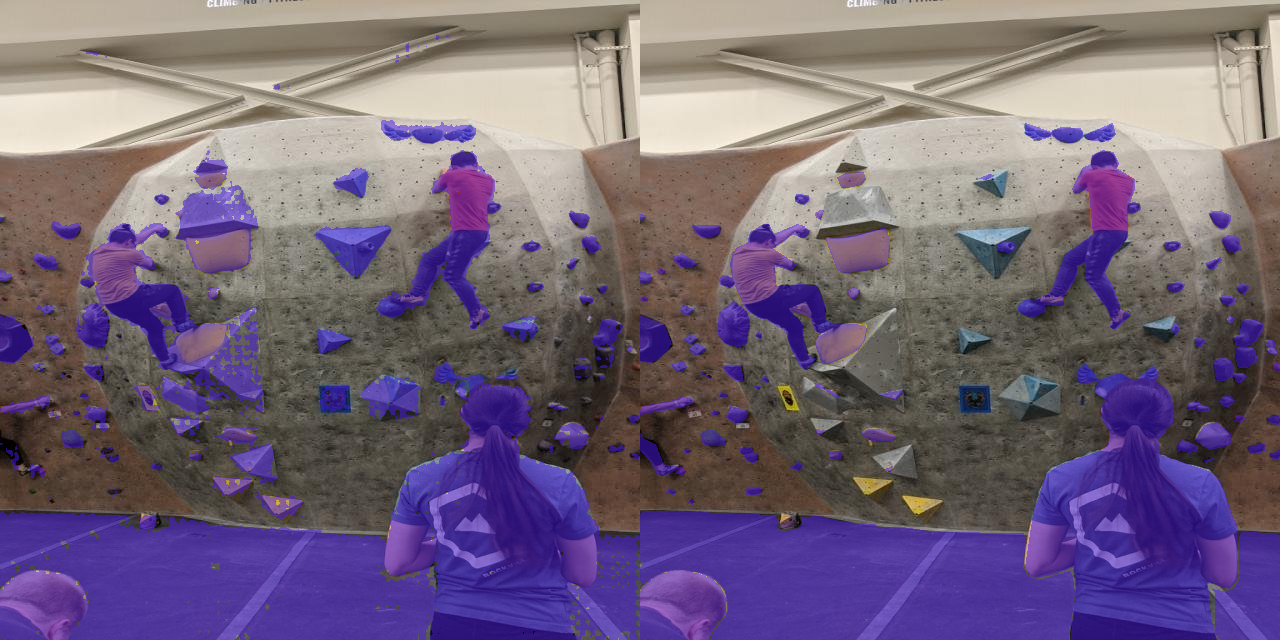

In [ ]:
from random import randint
idx = randint(0,len(valid_curr_dataset)-1)

decoder_input, gt_masks, (input_size,original_size), img, resized_img = valid_curr_dataset[idx]
new_input = {**decoder_input}
print("one mask" if len(gt_masks) == 1 else "multiple masks")

print("img",img.shape,"resized_img",resized_img.shape)
print("input_size",input_size,"original_size",original_size)

with torch.no_grad():
    if use_cnn:
        cnn_embedding = cnn_sam(resized_img)[0]

        curr_embedding = decoder_input["image_embeddings"]

        new_input["image_embeddings"] = curr_embedding + cnn_embedding
    low_res_masks, iou_predictions = mask_decoder(**new_input)

# upscaled_masks = F.interpolate(low_res_masks, size=img.shape[:2], mode="bilinear", align_corners=False)

upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).to(device)
binary_masks = normalize(threshold(upscaled_masks + 0.1, 0.0, 0)).to(device)[0,:,:,:]

# gt_binary_mask = torch.from_numpy(det_mask.astype(np.float32)).to(device)
# gt_binary_mask = get_gt_mask(gt_mask,gt_masks,binary_mask)
gt_binary_mask, binary_mask,*_ = get_max_iou_masks(gt_masks,binary_masks)

print(gt_binary_mask.shape, binary_mask.shape)

binary_mask = binary_masks[torch.argmax(iou_predictions).item()]

# binary_mask = binary_masks[0]
from PIL import Image
import numpy as np

from persam.persam_f import calculate_iou_loss, calculate_dice_loss, calculate_sigmoid_focal_loss

with torch.no_grad():
    flat_binary_mask = binary_mask.view(1,-1)
    flat_gt_binary_mask = gt_binary_mask.view(1,-1)

    focal_loss = calculate_sigmoid_focal_loss(flat_binary_mask, flat_gt_binary_mask,should_sigmoid=False)
    dice_loss = calculate_dice_loss(flat_binary_mask, flat_gt_binary_mask, should_sigmoid=False)
    iou_loss = calculate_iou_loss(flat_binary_mask, flat_gt_binary_mask, should_sigmoid=False)
    loss = focal_loss + dice_loss
    print(f"Loss: {loss:.4f}, Focal Loss: {focal_loss:.4f}, Dice Loss: {dice_loss:.4f}, IoU Loss: {iou_loss:.4f}")

from supervision import Detections,MaskAnnotator
from supervision.detection.utils import mask_to_xyxy

annotator = MaskAnnotator()
def mask_to_img(mask,img):
    # return Image.fromarray(mask.cpu().detach().numpy().astype(float) * 255).convert('RGB')
    mask = mask.cpu().detach().numpy()[None,:,:]
    dets = Detections(
        mask=mask,
        xyxy=mask_to_xyxy(mask),
    )
    ann_img = annotator.annotate(scene=img,detections=dets)
    return Image.fromarray(ann_img).convert('RGB')
    # return Image.fromarray(img * mask.logical_not().cpu().detach().numpy().astype(np.uint8)[:,:,None]).convert('RGB')

def clip_together_imgs(img1,img2):
    return Image.fromarray(np.hstack((img1,img2))).convert('RGB')

clip_together_imgs(mask_to_img(binary_mask,img),mask_to_img(gt_binary_mask,img))

torch.Size([256, 64, 64])
torch.Size([1, 256, 640, 640])


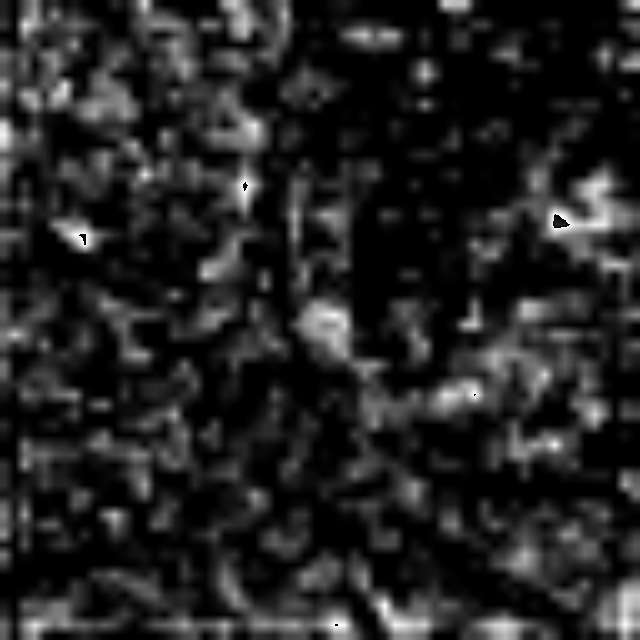

In [ ]:
print(cnn_embedding.shape)
new_cnn_embedding = predictor.model.postprocess_masks(cnn_embedding.cpu().detach()[None,...],input_size,original_size)
print(new_cnn_embedding.shape)
Image.fromarray((new_cnn_embedding.cpu().numpy()[0,0] * 255).astype(np.uint8)).convert("RGB")

torch.Size([1, 3, 640, 640])


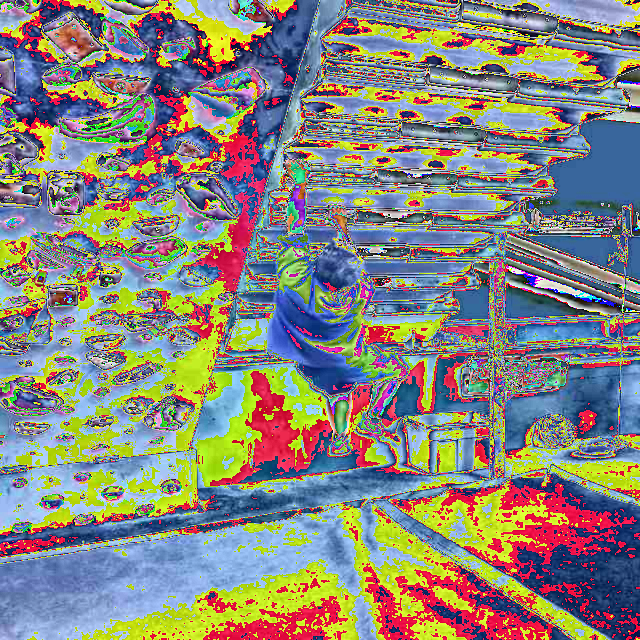

In [ ]:
out_img = resized_img.cpu()#.permute(0,2,3,1).cpu()
new_out_img = predictor.model.postprocess_masks(out_img, input_size, original_size)
print(new_out_img.shape)

Image.fromarray((new_out_img.permute(0,2,3,1).cpu().numpy()[0] * 255).astype(np.uint8)).convert("RGB")

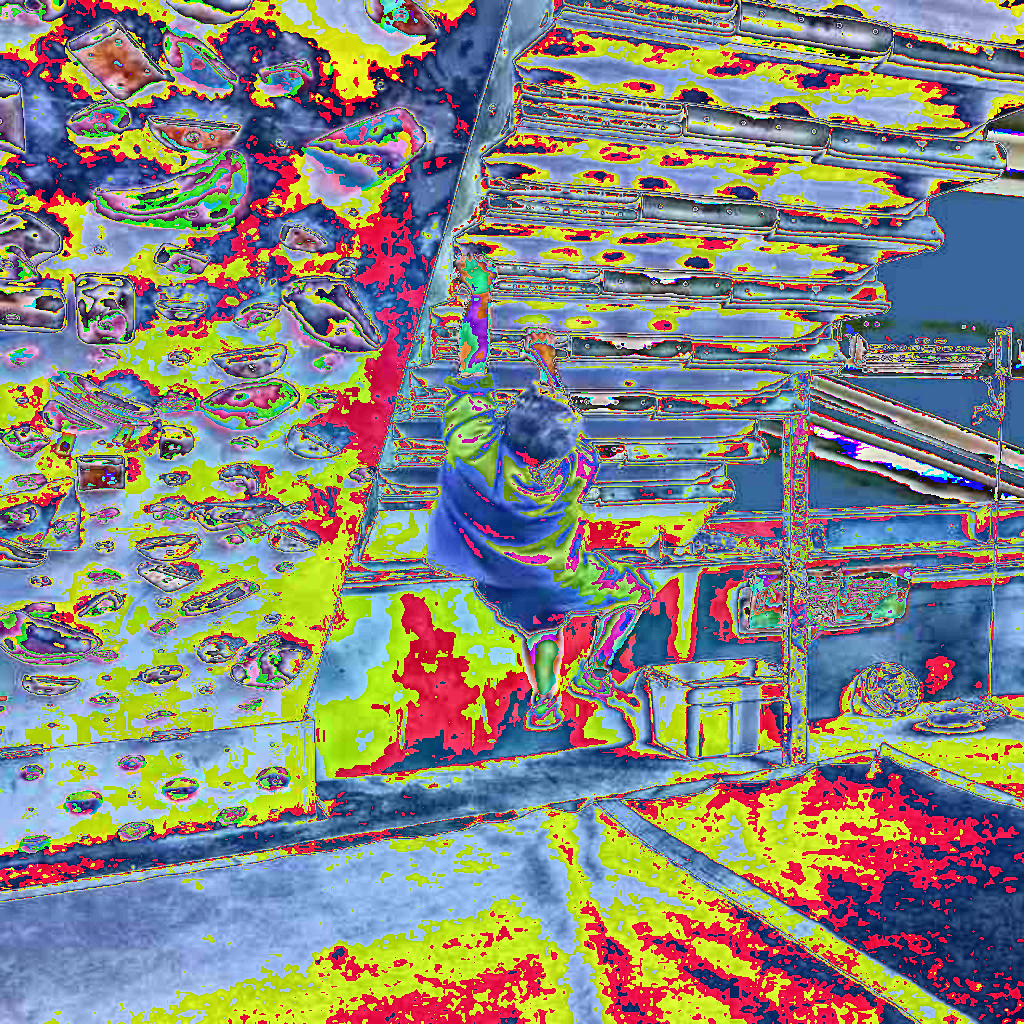

In [ ]:
Image.fromarray((resized_img.permute(0,2,3,1).cpu().numpy()[0] * 255).astype(np.uint8)).convert("RGB")

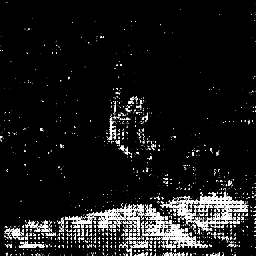

In [ ]:
Image.fromarray(low_res_masks.cpu().numpy()[0,0] * 255).convert("RGB")

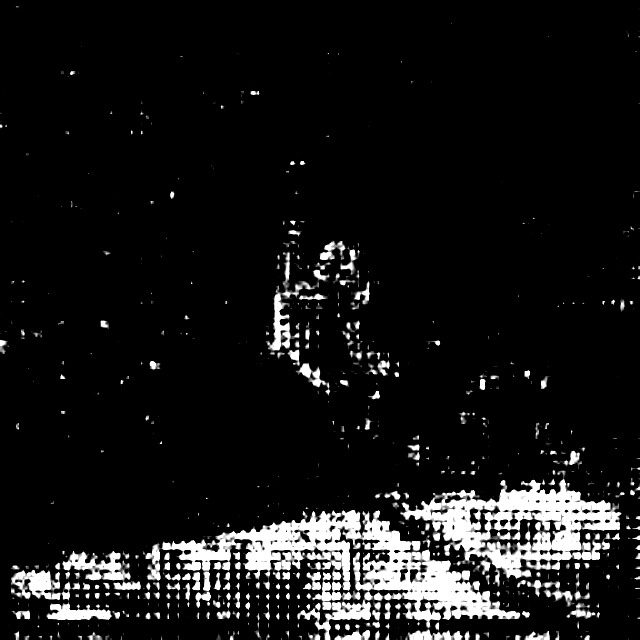

In [ ]:
upscaled_masks = F.interpolate(low_res_masks, size=img.shape[:2], mode="bilinear", align_corners=False)

# upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).to(device)

# Image.fromarray(upscaled_masks.cpu().).convert("RGB")
Image.fromarray(upscaled_masks.cpu().numpy()[0,0] * 255).convert("RGB")

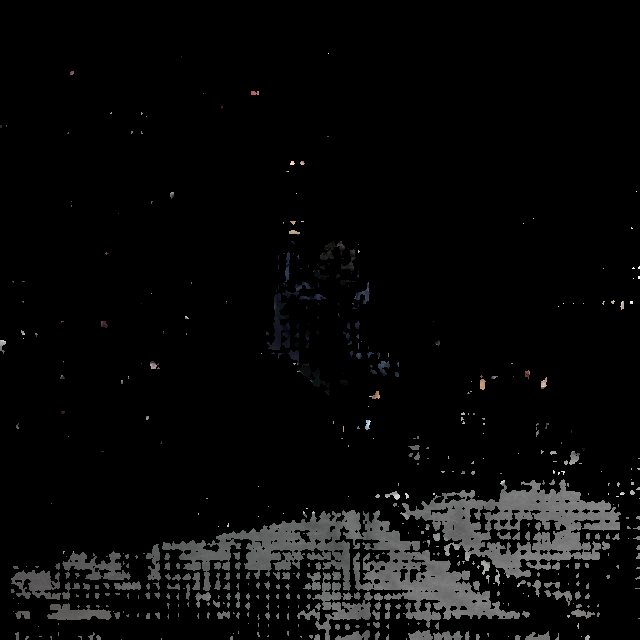

In [ ]:
# upscale low_res_masks to 1024x1024
high_res_masks = F.interpolate(low_res_masks, size=img.shape[:2], mode="bilinear", align_corners=False).detach().cpu().numpy()[0,0]

thresholded = (high_res_masks > 0.5).astype(np.uint8)
Image.fromarray(img * thresholded[...,None]).convert("RGB")

In [ ]:
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import automatic_mask_generator
from persam.load import load_predictor
import cv2

model = load_predictor("vit_h").model.cuda()
# model.mask_decoder = mask_decoder

img = cv2.imread("demo-img.png")#list(train_dataset.images.values())[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# raise NotImplementedError("TODO: fix this")

mask_generator = SamAutomaticMaskGenerator(model,stability_score_thresh=0.1)
print(f"Model threshold: {model.mask_threshold}, offset: {mask_generator.stability_score_offset}")

sam_result = mask_generator.generate(img)
raw_masks = automatic_mask_generator.latest_masks

if len(sam_result) == 0:
    print("No detections found")
    raise NotImplementedError("TODO: fix this")
detections = sv.Detections.from_sam(sam_result=sam_result)

annotator = sv.MaskAnnotator()
# paste each image into the new image
# detections = pred_dataset.annotations[img_name]
tmp_img = annotator.annotate(scene=img,detections=detections)
tmp_img = Image.fromarray(tmp_img)

tmp_img

Model threshold: 0.0, offset: 1.0
masks torch.bool
Mask threshold: 0.0, offset: 1.0, max: True
Intersections: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0', dtype=torch.int32)
Masks: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
Unions: tensor([409600, 40

NotImplementedError: TODO: fix this

torch.Size([192, 640, 640]) torch.bool


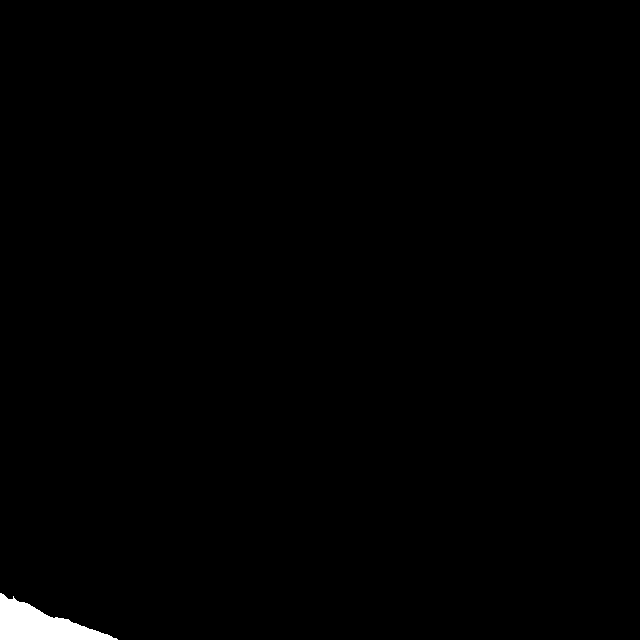

In [ ]:
from PIL import Image
import numpy as np
print(raw_masks.shape,raw_masks.dtype)
Image.fromarray(raw_masks[0].detach().cpu().numpy().astype(np.uint8) * 255)

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
from fine_tune.samed import LoRA_Mask_Decoder

lora_mask_decoder = LoRA_Mask_Decoder(sam.mask_decoder,r=5)

lora_mask_decoder.load_lora_parameters("lora.pt")
mask_decoder = lora_mask_decoder.mask_decoder.cuda()

In [ ]:
import cv2
img = cv2.imread("demo-img.png")#list(train_dataset.images.values())[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(img)

masks

[]

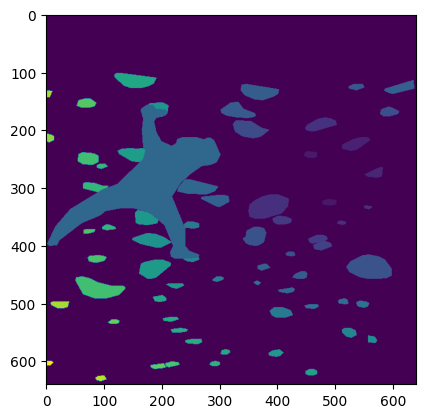

In [ ]:
from supervision.dataset.utils import approximate_mask_with_polygons

from random import choice
rand_img_name = choice(list(train_dataset.images.keys()))

rand_img_dets = train_dataset.annotations[rand_img_name]

biggest_mask = rand_img_dets.mask[rand_img_dets.area.argmax()]

from supervision.dataset.utils import approximate_mask_with_polygons
def dets_to_polygonss(dets):
    polygons = []
    for _,det_mask,*_ in dets:
        polygons.append(approximate_mask_with_polygons(det_mask))
    return polygons

def get_distances(point, polygonss):
    distances = np.zeros(len(polygonss), dtype=np.float32)
    for i,polygons in enumerate(polygonss):
        distances[i] = min([-cv2.pointPolygonTest(polygon, point, True) for polygon in polygons])
    
    distances = np.maximum(distances, 0)
    return distances

def show_closest_distances(point, dets):
    # get the distance of each det
    polygonss = dets_to_polygonss(dets)
    distances = get_distances(point, polygonss)

    # render the masks with their respective distances

    empty_map = np.zeros_like(dets.mask[0], dtype=np.float32)

    for i,(_,det_mask,*_) in enumerate(dets):
        empty_map[det_mask] = distances[i]

    return empty_map

polygons = approximate_mask_with_polygons(biggest_mask)

# make a signed distance map

empty_map = np.zeros(biggest_mask.shape, dtype=np.float32)

for i in range(biggest_mask.shape[0]):
    for j in range(biggest_mask.shape[1]):
        redPoint = (j,i)
        closestDist = cv2.pointPolygonTest(polygons[0], redPoint, True)

        empty_map[i, j] = -closestDist

empty_map = np.maximum(empty_map, 0)

from matplotlib import pyplot as plt

# plt.imshow(empty_map)

rand_point = (choice(range(biggest_mask.shape[0])), choice(range(biggest_mask.shape[1])))

plt.imshow(show_closest_distances(rand_point, rand_img_dets))